In [1]:
import datetime
import os
import random
import readline
from datetime import date
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import netCDF4
import numpy
import pandas
import scipy
import seaborn
import xarray as xr
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from matplotlib import colors, font_manager, pyplot
from matplotlib.cm import ScalarMappable
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from scipy import fft, linalg, stats
from scipy.stats import poisson, ttest_ind
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import normalize
from statsmodels.tsa.ar_model import AutoReg

In [2]:
Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Data/Output_Files_V6/'
Output_Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Github/RCP_Figs/Analysis_Figs_V6/'

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri):
    Data_DF = Open_File(Diri+Model+'_Data_ExTC_Output_V6.csv')
    ET_DF = Open_File(Diri+Model+'_ET_ExTC_Output_V6.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V6.csv')
    Time = []
    Months = []
    Birth_Time = []
    Start_Time = []
    End_Time = []
    Death_Time = []
    Peak_Time = []
# Edit Time Format
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
        Months.append(Month(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Birth_Time.append(Datetime(ET_DF["Genesis Time"][j]))
        Start_Time.append(Datetime(ET_DF["ET Begin Time"][j]))
        End_Time.append(Datetime(ET_DF["ET Complete Time"][j]))
        Death_Time.append(Datetime(ET_DF["Dissipate Time"][j]))
        Peak_Time.append(Datetime(ET_DF["Peak Time"][j]))
    Data_DF["Time(Z)"] = Time
    Data_DF["Month"] = Months
    ET_DF["Genesis Time"] = Birth_Time
    ET_DF["ET Begin Time"] = Start_Time
    ET_DF["ET Complete Time"] = End_Time
    ET_DF["Dissipate Time"] = Death_Time
    ET_DF["Peak Time"] = Peak_Time
    return (Data_DF, ET_DF, Codes_DF)

In [5]:
def Datetime(Time):
    try:
        New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    except:
        New_Time = numpy.nan
    return (New_Time)

In [6]:
def Month(Time):
    try:
        New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
        Month = New_Time.month
    except:
        Month = numpy.nan
    return (Month)

In [7]:
# Create Phase Distribution Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)
VLT_Bins = Create_Bins(-600,600,50)
B_Bins = Create_Bins(-45,135,7.5)
Bins_Bounds = numpy.array([-600,600,50,-45,135,7.5])

In [8]:
Num_Years = numpy.array([90,93,93])

In [9]:
Control_Data, Control_ET, Control_Codes = Files_Open("Control", Diri)
RCP45_Data, RCP45_ET, RCP45_Codes = Files_Open("RCP45", Diri)
RCP85_Data, RCP85_ET, RCP85_Codes = Files_Open("RCP85", Diri)

In [10]:
# Create Function to Calculate Phase Space Distribution
def Phase_Space_Distribution(DF, VLT_Bins, B_Bins, Model, Rela):
    VLT_B_Count = numpy.zeros((len(VLT_Bins)-1, len(B_Bins)-1))
    VLT_VUT_Count = numpy.zeros((len(VLT_Bins)-1, len(VLT_Bins)-1))
    VLT_B_Length = 0
    VLT_VUT_Length = 0
#
# Count Phase Space Distribution
    for i in range(len(DF["VLT"])):
        for j in range(len(VLT_Bins)-1):
            if DF["VLT"][i] > VLT_Bins[j] and DF["VLT"][i] <= VLT_Bins[j+1]:
                for k in range(len(B_Bins)-1):
                    if DF["B"][i] > B_Bins[k] and DF["B"][i] <= B_Bins[k+1]:
                        VLT_B_Count[j][k] += 1
                        VLT_B_Length += 1
                for l in range(len(VLT_Bins)-1):
                    if DF["VUT"][i] > VLT_Bins[l] and DF["VUT"][i] <= VLT_Bins[l+1]:
                        VLT_VUT_Count[j][l] += 1
                        VLT_VUT_Length += 1
#
# Calculate Phase Space Density
    if Rela == True:
        VLT_B_Density = VLT_B_Count / VLT_B_Length * 1000
        VLT_VUT_Density = VLT_VUT_Count / VLT_VUT_Length * 1000
        return (VLT_B_Density, VLT_VUT_Density)
#
# Calculate Phase Space Annual
    else:
        if Model == "Control":
            Num_Year = 90
        else:
            Num_Year = 93
        VLT_B_Annual = VLT_B_Count / Num_Year
        VLT_VUT_Annual = VLT_VUT_Count / Num_Year
        return (VLT_B_Annual, VLT_VUT_Annual)

In [11]:
# Calculate Percentage of Points in Each Quadrant
def Phase_Space_Quadrant(Density, Var, Rela):
    if Rela == True:
        Density = Density / 1000
    x_Length = len(Density)
    y_Length = len(Density[0])
    x_Mid = int(x_Length / 2)
    Right_Half = Density[x_Mid:]
    Left_Half = Density[:x_Mid]
    Q1 = 0
    Q2 = 0
    Q3 = 0
    Q4 = 0
    if Var == "VUT":
        y_Mid = int(y_Length / 2)
    elif Var == "B":
        y_Mid = int(y_Length / 3)
    for i in range(len(Right_Half)):
        Top_Right = numpy.sum(Right_Half[i][y_Mid:])
        Q1 += Top_Right
        Bottom_Right = numpy.sum(Right_Half[i][:y_Mid])
        Q4 += Bottom_Right
    for j in range(len(Left_Half)):
        Top_Left = numpy.sum(Left_Half[j][y_Mid:])
        Q2 += Top_Left
        Bottom_Left = numpy.sum(Left_Half[j][:y_Mid])
        Q3 += Bottom_Left
    return (numpy.array([Q1, Q2, Q3, Q4]))

In [12]:
# Create Function For Colours
#Distr_Colours = ['lightskyblue', 'deepskyblue', 'dodgerblue', 'darkcyan', 'lightseagreen', \
#'limegreen', 'greenyellow', 'yellow', 'gold', 'orange', 'darkorange', 'red']
#Rela_Distr_Bounds = numpy.array([0,1,2.5,5,7.5,10,15,20,25,30,40,50])
#Annual_Distr_Bounds = numpy.array([0,0.2,0.5,1,1.5,2,3,4,5,6,8,10])
Distr_Colours = ['lightskyblue', 'deepskyblue', 'lightseagreen', \
'limegreen', 'greenyellow', 'yellow', 'gold', 'orange', 'red']
Rela_Distr_Bounds = numpy.array([0,1,2,5,10,20,30,40,50])
Annual_Distr_Bounds = numpy.array([0,0.1,0.2,0.5,1,2,3,4,5])
# Create Function For Colours
def Distr_Colour(Density, Dist_Colours, Dist_Bounds):
    for k in range(len(Dist_Colours)):
        if Density == 0:
            Colour = 'white'
        else:
            if k != len(Dist_Colours)-1:
                if Density <= Dist_Bounds[k+1] and Density > Dist_Bounds[k]:
                    Colour = Dist_Colours[k]
            else:
                if Density > Dist_Bounds[k]:
                    Colour = Dist_Colours[k]
    return (Colour)

In [13]:
# Plot Cyclone Phase Distribution
def Phase_Distr_Plot(VLT_B, VLT_VUT, Model, Rela, Savefig, Figname):
# Define Colours and Bounds
    if Rela == True:
        Bounds = Rela_Distr_Bounds
        Colours = Distr_Colours
    else:
        Bounds = Annual_Distr_Bounds
        Colours = Distr_Colours
    Fig = pyplot.figure(figsize=(16,8))
#
# VLT B Distribution
    Axis = Fig.add_subplot(1,2,1)
    for j in range(len(VLT_B)):
        for k in range(len(VLT_B[0])):
            Colour = Distr_Colour(VLT_B[j][k], Colours, Bounds)
            pyplot.fill_between([VLT_Bins[j],VLT_Bins[j+1]], B_Bins[k], B_Bins[k+1], color=Colour)
    Phase_Distr_Formatting("B", Model, Rela, Axis)
# Add Quadrant Percent
    Quadrant_Percent = Phase_Space_Quadrant(VLT_B, "B", Rela)
    xloc = [0.88,0.12,0.12,0.88]
    yloc = [0.88,0.88,0.12,0.12]
    for q in range(len(Quadrant_Percent)):
        if Rela == True:
            Axis.text(xloc[q], yloc[q], str('%5.3f' % Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
        else:
            Axis.text(xloc[q], yloc[q], str('%5.2f' % Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
#
# VLT VUT Distribution
    Axis = Fig.add_subplot(1,2,2)
    for j in range(len(VLT_VUT)):
        for l in range(len(VLT_VUT[0])):
            Colour = Distr_Colour(VLT_VUT[j][l], Colours, Bounds)
            pyplot.fill_between([VLT_Bins[j],VLT_Bins[j+1]], VLT_Bins[l], VLT_Bins[l+1], color=Colour)
    Phase_Distr_Formatting("VUT", Model, Rela, Axis)
# Add Quadrant Percent
    Quadrant_Percent = Phase_Space_Quadrant(VLT_VUT, "VUT", Rela)
    xloc = [0.88,0.12,0.12,0.88]
    yloc = [0.88,0.88,0.12,0.12]
    for q in range(len(Quadrant_Percent)):
        if Rela == True:
            Axis.text(xloc[q], yloc[q], str('%5.3f' % Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
        else:
            Axis.text(xloc[q], yloc[q], str('%5.2f' % Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
#
# Colour Bar
    if Rela == True:
        Cbar_Label = 'Density (Per 1000 Data Points)'
    else:
        Cbar_Label = 'Density (Per Year)'
    C_Map = mcolors.LinearSegmentedColormap.from_list("Density (10^-3)", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='max')
    Cax = Axis.inset_axes([-0.75, -0.15, 1.3, 0.05], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, \
    label=Cbar_Label, ticks=Bounds, shrink=0.7)
#
# Save Fig
    if Savefig == True:
        Fig.savefig(Output_Diri+Figname+'.png', bbox_inches='tight')

In [14]:
# Formatting For Cyclone Phase Distribution Plot
def Phase_Distr_Formatting(y_Var, Model, Rela, Axis):
    x_Axis = Create_Bins(Bins_Bounds[0],Bins_Bounds[1],100)
    pyplot.xlim(Bins_Bounds[0],Bins_Bounds[1])
    if y_Var == "B":
        y_Axis = Create_Bins(Bins_Bounds[3],Bins_Bounds[4],15)
        pyplot.ylim(Bins_Bounds[3],Bins_Bounds[4])
        pyplot.plot([-1000,1000], [15,15], 'black', linewidth=0.5)
        pyplot.plot([0,0], [-150,300], 'black', linewidth=0.5)
    else:
        y_Axis = Create_Bins(Bins_Bounds[0],Bins_Bounds[1],100)
        pyplot.ylim(Bins_Bounds[0],Bins_Bounds[1])
        pyplot.plot([-1000,1000], [0,0], 'black', linewidth=0.5)
        pyplot.plot([0,0], [-1000,1000], 'black', linewidth=0.5)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel(y_Var, fontsize=12)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    if Rela == True:
        pyplot.title(str(Model + ' (Relative)'), fontsize=18)
    else:
        pyplot.title(str(Model + ' (Annual)'), fontsize=18)

In [15]:
# Phase Space Distribution For Control Run (Relative)
Control_VLT_B_Rela, Control_VLT_VUT_Rela = Phase_Space_Distribution(Control_Data, VLT_Bins, B_Bins, "Control", True)
# Phase Space Distribution For RCP4.5 Run (Relative)
RCP45_VLT_B_Rela, RCP45_VLT_VUT_Rela = Phase_Space_Distribution(RCP45_Data, VLT_Bins, B_Bins, "RCP4.5", True)
# Phase Space Distribution For RCP8.5 Run (Relative)
RCP85_VLT_B_Rela, RCP85_VLT_VUT_Rela = Phase_Space_Distribution(RCP85_Data, VLT_Bins, B_Bins, "RCP8.5", True)

In [16]:
# Phase Space Distribution For Control Run (Annual)
Control_VLT_B_Annual, Control_VLT_VUT_Annual = Phase_Space_Distribution(Control_Data, VLT_Bins, B_Bins, "Control", False)
# Phase Space Distribution For RCP4.5 Run (Annual)
RCP45_VLT_B_Annual, RCP45_VLT_VUT_Annual = Phase_Space_Distribution(RCP45_Data, VLT_Bins, B_Bins, "RCP4.5", False)
# Phase Space Distribution For RCP8.5 Run (Annual)
RCP85_VLT_B_Annual, RCP85_VLT_VUT_Annual = Phase_Space_Distribution(RCP85_Data, VLT_Bins, B_Bins, "RCP8.5", False)

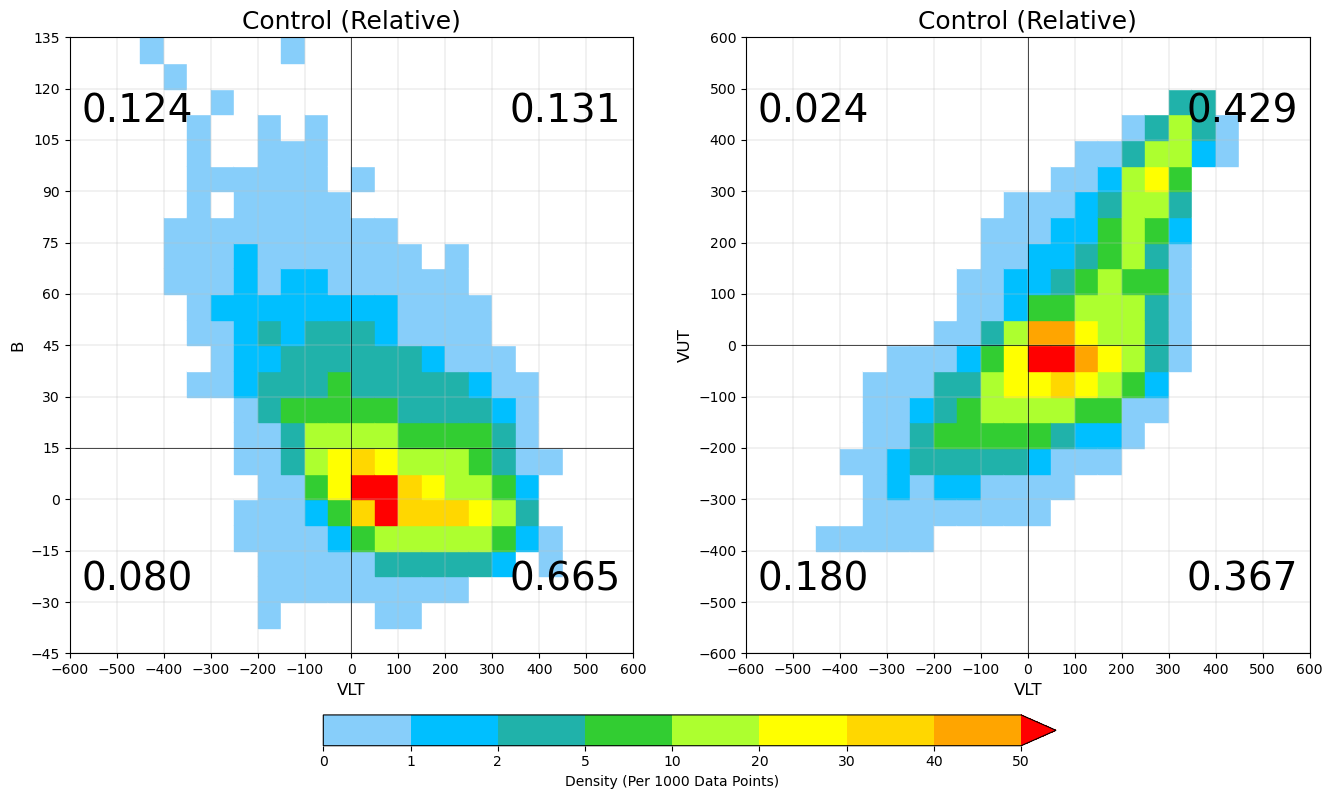

In [17]:
# Plot Relative Phase Space Distribution For Control Run
Fig = Phase_Distr_Plot(Control_VLT_B_Rela, Control_VLT_VUT_Rela, "Control", True, True, \
"Control_Phase_Distr_Rela")

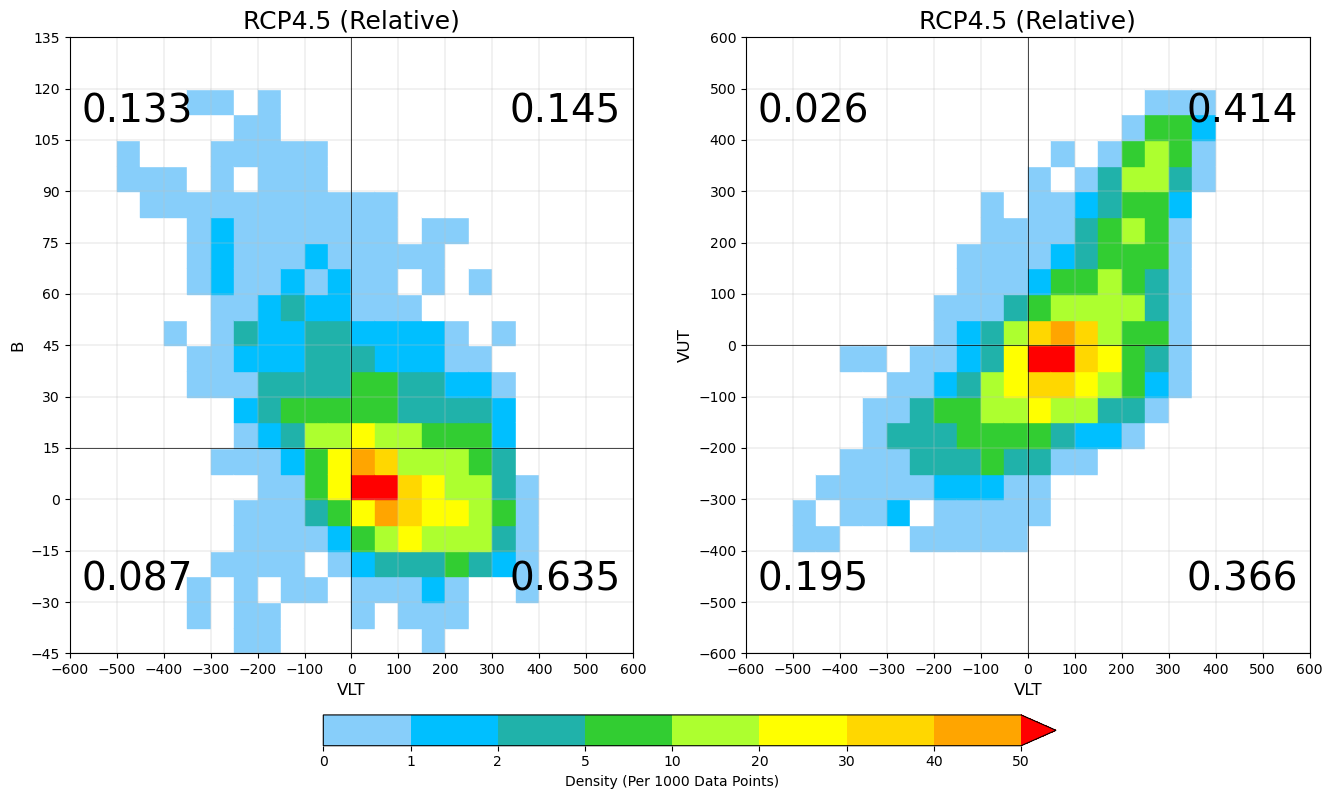

In [18]:
# Plot Relative Phase Space Distribution For RCP4.5 Run
Fig = Phase_Distr_Plot(RCP45_VLT_B_Rela, RCP45_VLT_VUT_Rela, "RCP4.5", True, True, \
"RCP45_Phase_Distr_Rela")

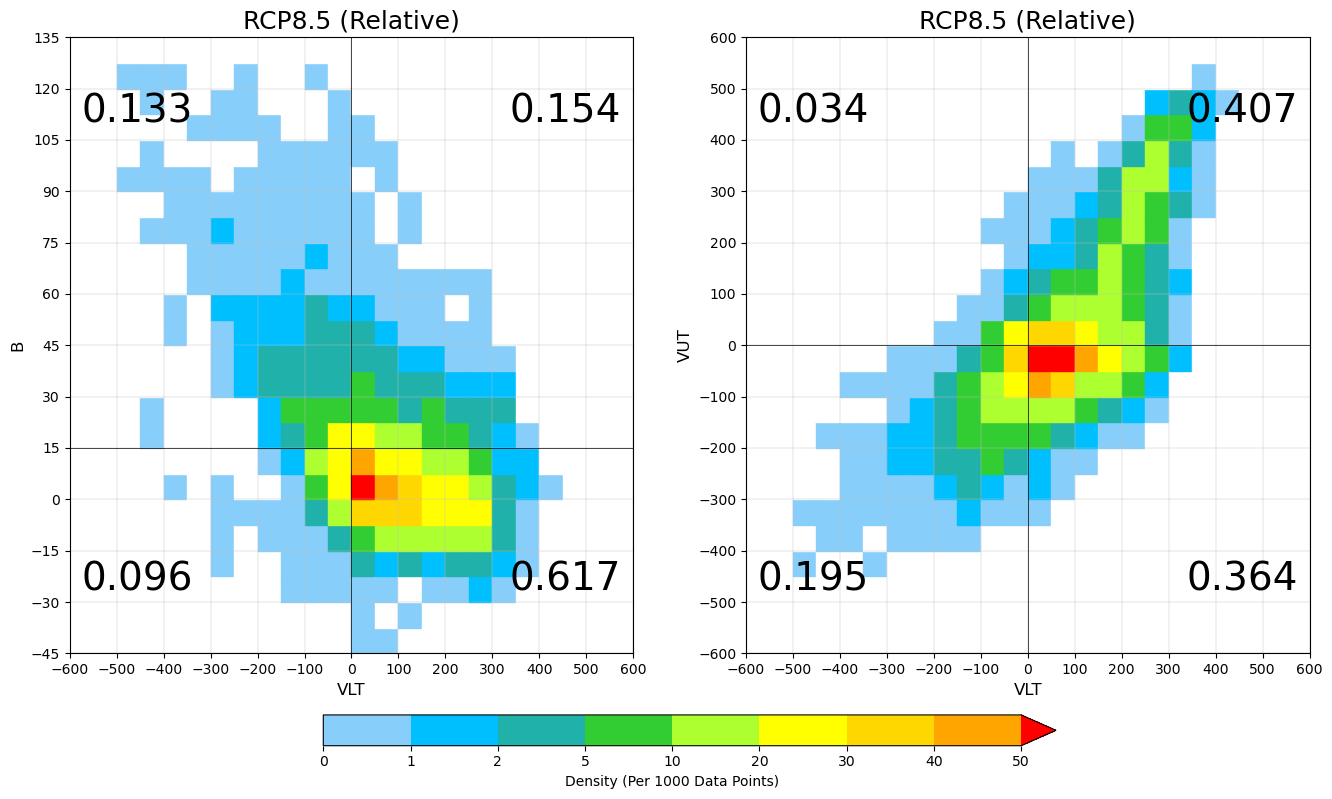

In [19]:
# Plot Relative Phase Space Distribution For RCP8.5 Run
Fig = Phase_Distr_Plot(RCP85_VLT_B_Rela, RCP85_VLT_VUT_Rela, "RCP8.5", True, True, \
"RCP85_Phase_Distr_Rela")

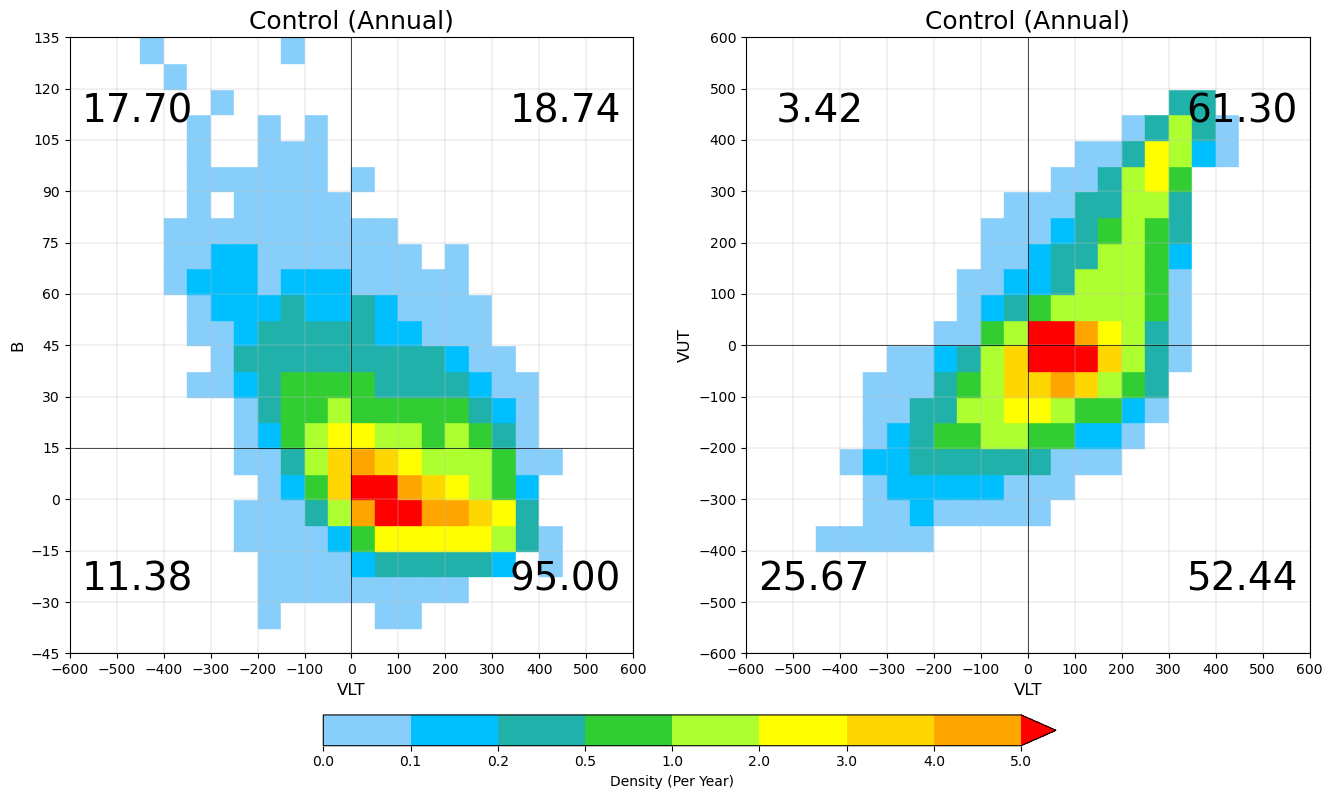

In [20]:
# Plot Annual Phase Space Distribution For Control Run
Fig = Phase_Distr_Plot(Control_VLT_B_Annual, Control_VLT_VUT_Annual, "Control", False, True, \
"Control_Phase_Distr_Annual")

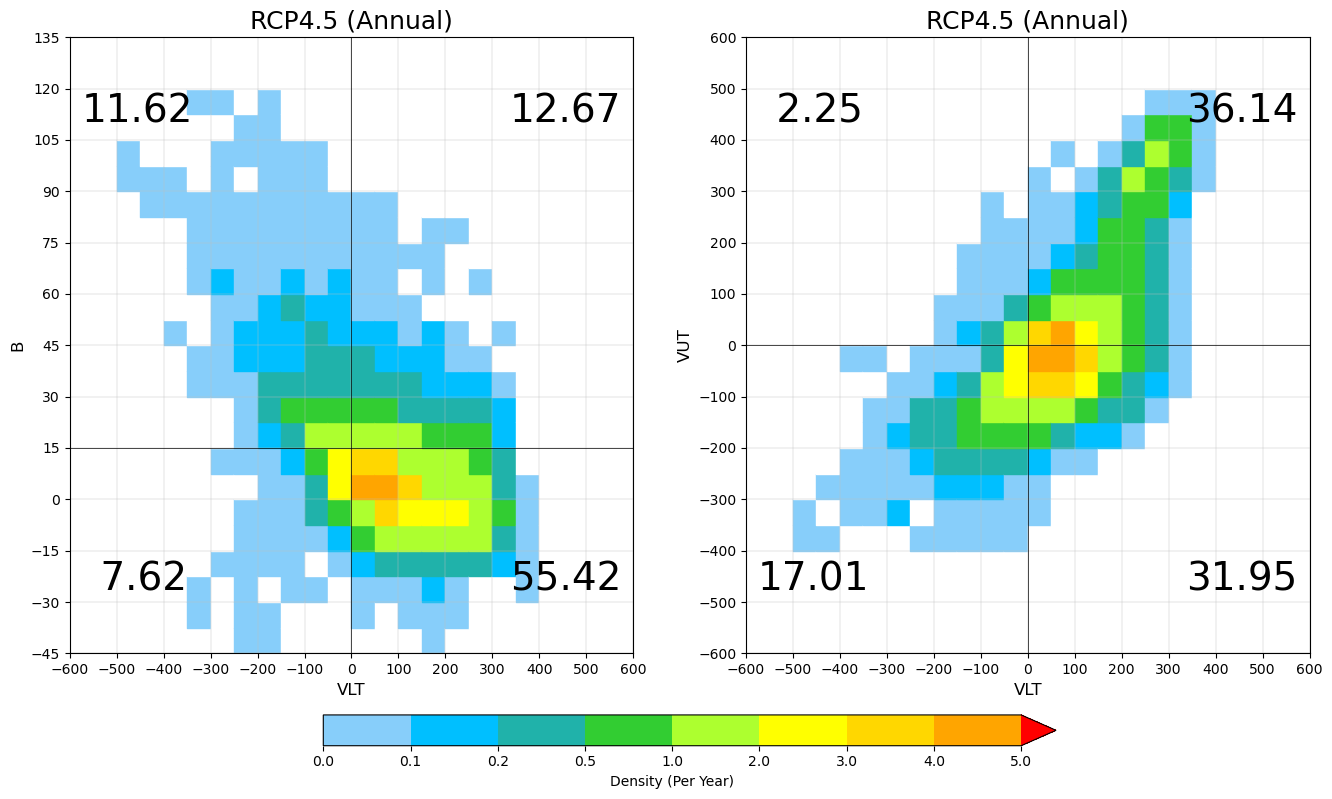

In [21]:
# Plot Annual Phase Space Distribution For RCP4.5 Run
Fig = Phase_Distr_Plot(RCP45_VLT_B_Annual, RCP45_VLT_VUT_Annual, "RCP4.5", False, True, \
"RCP45_Phase_Distr_Annual")

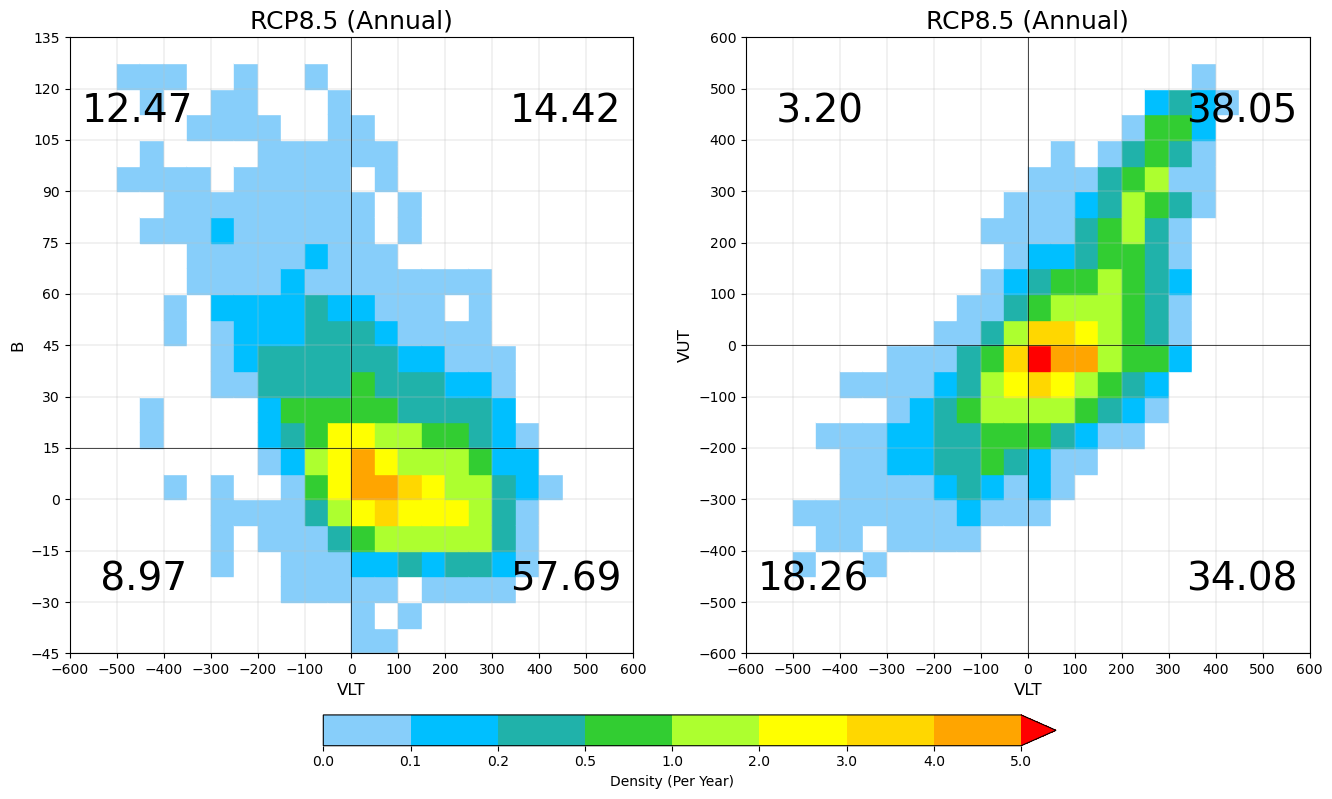

In [22]:
# Plot Annual Phase Space Distribution For RCP8.5 Run
Fig = Phase_Distr_Plot(RCP85_VLT_B_Annual, RCP85_VLT_VUT_Annual, "RCP8.5", False, True, \
"RCP85_Phase_Distr_Annual")

In [23]:
# Calculate Difference Between Models
def Phase_Space_Diff(x1, z1, x2, z2):
    xDiff = x1 - x2
    zDiff = z1 - z2
    return (xDiff, zDiff)

In [24]:
# Create Function of Colours of Cyclone Phase Difference Plots
#Diff_Colours = ['navy', 'mediumblue', 'dodgerblue', 'deepskyblue', 'cyan', 'lawngreen', \
#'gold', 'orange', 'darkorange', 'orangered', 'red']
#Rela_Diff_Bounds = numpy.array([-6,-4.5,-3,-1.5,-0.5,0.5,1.5,3,4.5,6])
Diff_Colours = ['mediumblue', 'deepskyblue', 'cyan', 'lawngreen', \
'gold', 'darkorange', 'red']
Rela_Diff_Bounds = numpy.array([-6,-4,-2,2,4,6])
Annual_Diff_Bounds = numpy.array([-3,-2,-1,1,2,3])
#
def Diff_Colour(Diff, Diff_Colours, Diff_Bounds):
    for k in range(len(Diff_Colours)):
        if Diff == 0:
            Colour = 'white'
        else:
            if k == 0:
                if Diff < Diff_Bounds[k]:
                    Colour = Diff_Colours[k]
            elif k < len(Diff_Colours)-1:
                if Diff <= Diff_Bounds[k] and Diff > Diff_Bounds[k-1]:
                    Colour = Diff_Colours[k]
            else:
                if Diff > Diff_Bounds[k-1]:
                    Colour = Diff_Colours[k]
    return (Colour)

In [25]:
# Plot Cyclone Phase Distribution Difference Between ERA and REA
def Phase_Diff_Plot(Model_1, Model_2, VLT_B_1, VLT_VUT_1, VLT_B_2, VLT_VUT_2, Rela, Savefig, Figname):
# Apply Difference Between Models Function
#    if New == False:
    VLT_B_Diff, VLT_VUT_Diff = Phase_Space_Diff(VLT_B_1, VLT_VUT_1, VLT_B_2, VLT_VUT_2)
#    else:
#        VLT_B_Diff, VLT_VUT_Diff = Phase_Space_Diff_New(VLT_B_1, VLT_VUT_1, VLT_B_2, VLT_VUT_2)
#
# Define Colours and Bounds
    if Rela == True:
        Diff_Bounds = Rela_Diff_Bounds
    else:
        Diff_Bounds = Annual_Diff_Bounds
    Fig = pyplot.figure(figsize=(16,8))
#
# VLT B Distribution
    Axis = Fig.add_subplot(1,2,1)
    for j in range(len(VLT_B_Diff)):
        for k in range(len(VLT_B_Diff[0])):
            Colour = Diff_Colour(VLT_B_Diff[j][k], Diff_Colours, Diff_Bounds)
            pyplot.fill_between([VLT_Bins[j],VLT_Bins[j+1]], B_Bins[k], B_Bins[k+1], color=Colour)
    Phase_Diff_Formatting("B", Model_1, Model_2, Rela, Axis)
# Add Quadrant Percent
    Quadrant_Percent = Phase_Space_Quadrant(VLT_B_1, "B", Rela) - Phase_Space_Quadrant(VLT_B_2, "B", Rela)
    xloc = [0.88,0.12,0.12,0.88]
    yloc = [0.88,0.88,0.12,0.12]
    for q in range(len(Quadrant_Percent)):
        if Rela == True:
            Axis.text(xloc[q], yloc[q], str('%5.3f' % Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
        else:
            Axis.text(xloc[q], yloc[q], str('%5.2f' % Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
#
# VLT VUT Distribution
    Axis = Fig.add_subplot(1,2,2)
    for j in range(len(VLT_VUT_Diff)):
        for l in range(len(VLT_VUT_Diff[0])):
            Colour = Diff_Colour(VLT_VUT_Diff[j][l], Diff_Colours, Diff_Bounds)
            pyplot.fill_between([VLT_Bins[j],VLT_Bins[j+1]], VLT_Bins[l], VLT_Bins[l+1], color=Colour)
    Phase_Diff_Formatting("VUT", Model_1, Model_2, Rela, Axis)
# Add Quadrant Percent
    Quadrant_Percent = Phase_Space_Quadrant(VLT_VUT_1, "VUT", Rela) - Phase_Space_Quadrant(VLT_VUT_2, "VUT", Rela)
    xloc = [0.88,0.12,0.12,0.88]
    yloc = [0.88,0.88,0.12,0.12]
    for q in range(len(Quadrant_Percent)):
        if Rela == True:
            Axis.text(xloc[q], yloc[q], str('%5.3f' % Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
        else:
            Axis.text(xloc[q], yloc[q], str('%5.2f' % Quadrant_Percent[q]), ha='center', va='center', \
            transform=Axis.transAxes, fontdict={'size':28},color='black')
#
# Colour Bar
    if Rela == True:
        Cbar_Label = 'Density Difference (Per 1000 Data Points)'
    else:
        Cbar_Label = 'Density Difference (Per Year)'
    C_Map = mcolors.LinearSegmentedColormap.from_list("Density (10^-3)", Diff_Colours, N=len(Diff_Colours))
    Norm = mcolors.BoundaryNorm(Diff_Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([-0.75, -0.15, 1.3, 0.05], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, \
    label=Cbar_Label, ticks=Diff_Bounds, shrink=0.7)
#
# Save Fig
    if Savefig == True:
        Fig.savefig(Output_Diri+Figname+'.png', bbox_inches='tight')

In [26]:
# Formatting For Cyclone Phase Difference Plot
def Phase_Diff_Formatting(y_Var, Model_1, Model_2, Rela, Axis):
    x_Axis = Create_Bins(Bins_Bounds[0],Bins_Bounds[1],100)
    pyplot.xlim(Bins_Bounds[0],Bins_Bounds[1])
    if y_Var == "B":
        y_Axis = Create_Bins(Bins_Bounds[3],Bins_Bounds[4],15)
        pyplot.ylim(Bins_Bounds[3],Bins_Bounds[4])
        pyplot.plot([-1000,1000], [15,15], 'black', linewidth=0.5)
        pyplot.plot([0,0], [-150,300], 'black', linewidth=0.5)
    else:
        y_Axis = Create_Bins(Bins_Bounds[0],Bins_Bounds[1],100)
        pyplot.ylim(Bins_Bounds[0],Bins_Bounds[1])
        pyplot.plot([-1000,1000], [0,0], 'black', linewidth=0.5)
        pyplot.plot([0,0], [-1000,1000], 'black', linewidth=0.5)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel(y_Var, fontsize=12)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    if Rela == True:
        pyplot.title(str(Model_1 + ' - ' + Model_2 + ' (Relative)'), fontsize=18)
    else:
        pyplot.title(str(Model_1 + ' - ' + Model_2 + ' (Annual)'), fontsize=18)

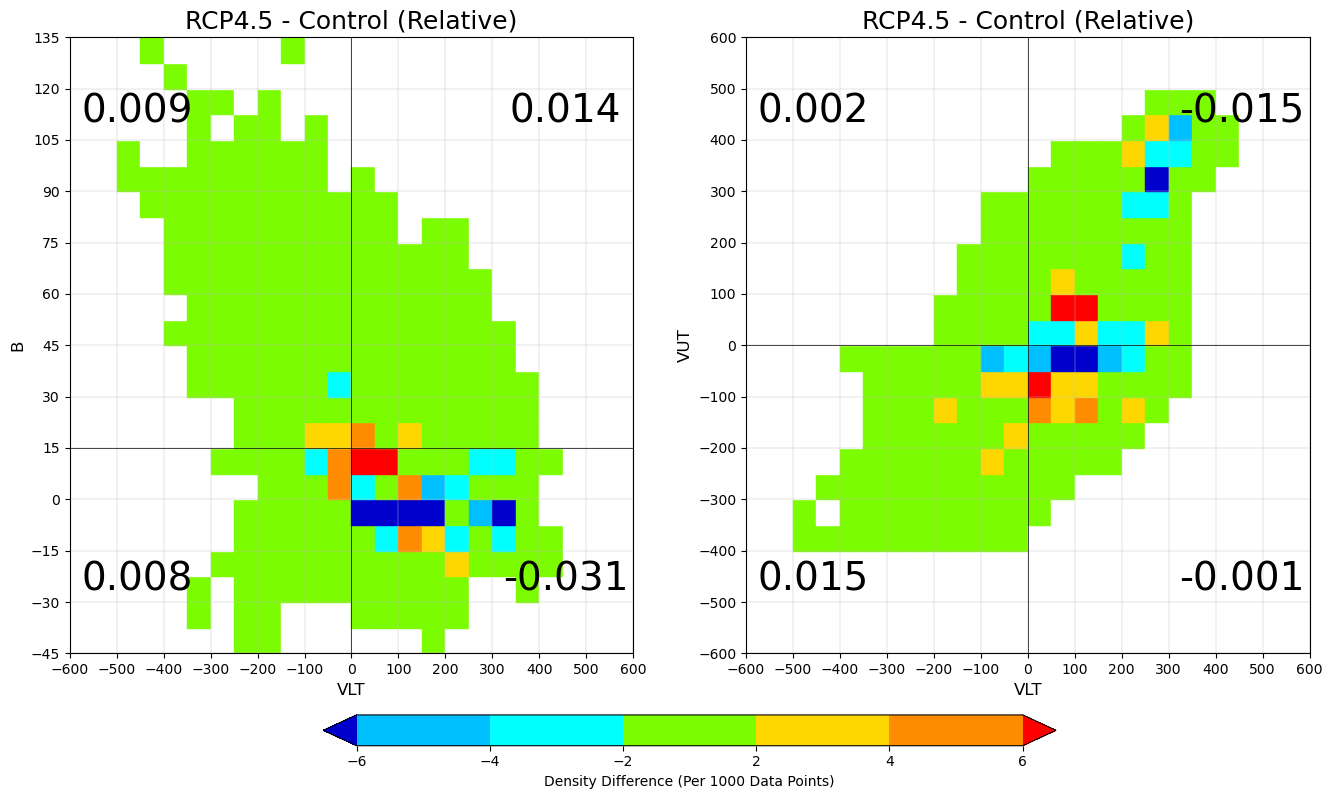

In [27]:
# Plot Relative Difference Between Phase Space Distributions of RCP4.5 - Control
Phase_Diff_Plot("RCP4.5", "Control", RCP45_VLT_B_Rela, RCP45_VLT_VUT_Rela, Control_VLT_B_Rela, Control_VLT_VUT_Rela, \
True, True, "RCP45-Control_Phase_Diff_Rela")

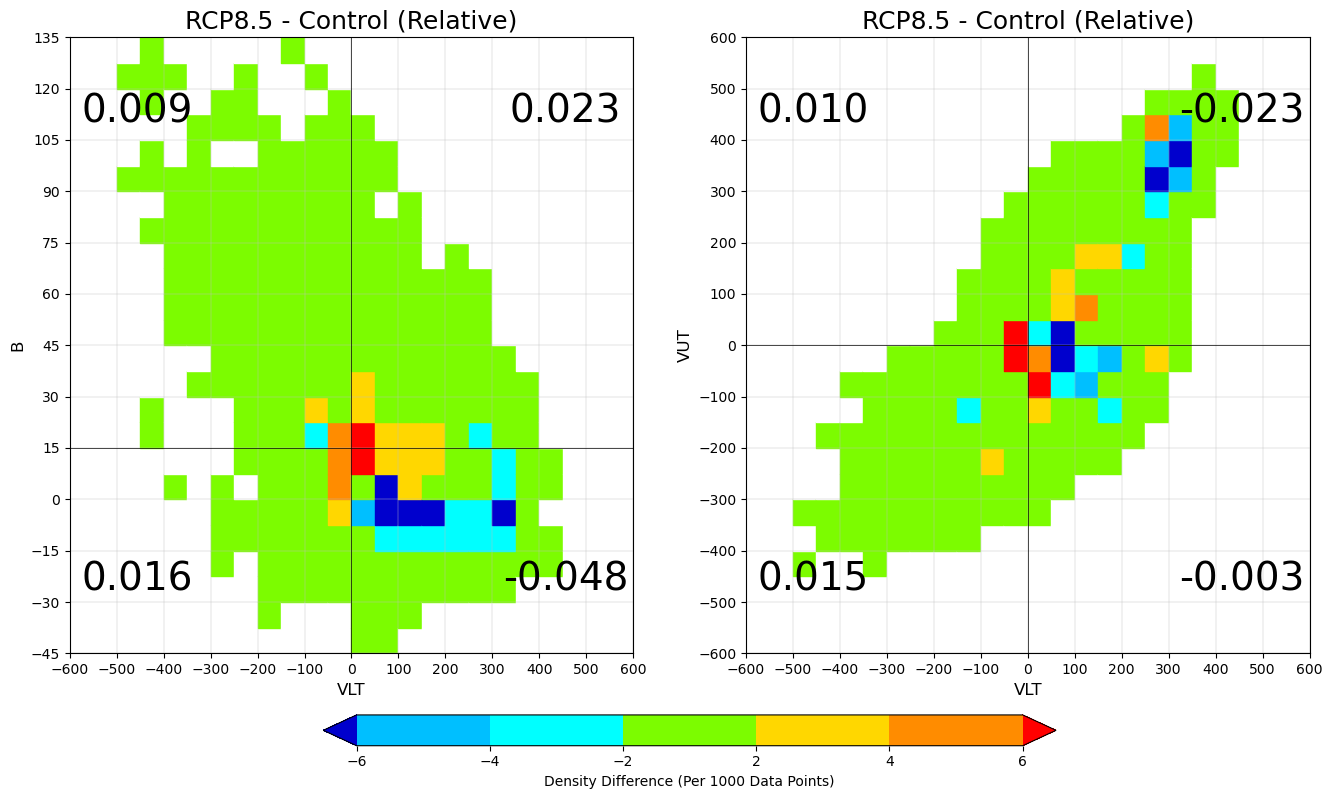

In [28]:
# Plot Relative Difference Between Phase Space Distributions of RCP8.5 - Control
Phase_Diff_Plot("RCP8.5", "Control", RCP85_VLT_B_Rela, RCP85_VLT_VUT_Rela, Control_VLT_B_Rela, Control_VLT_VUT_Rela, \
True, True, "RCP85-Control_Phase_Diff_Rela")

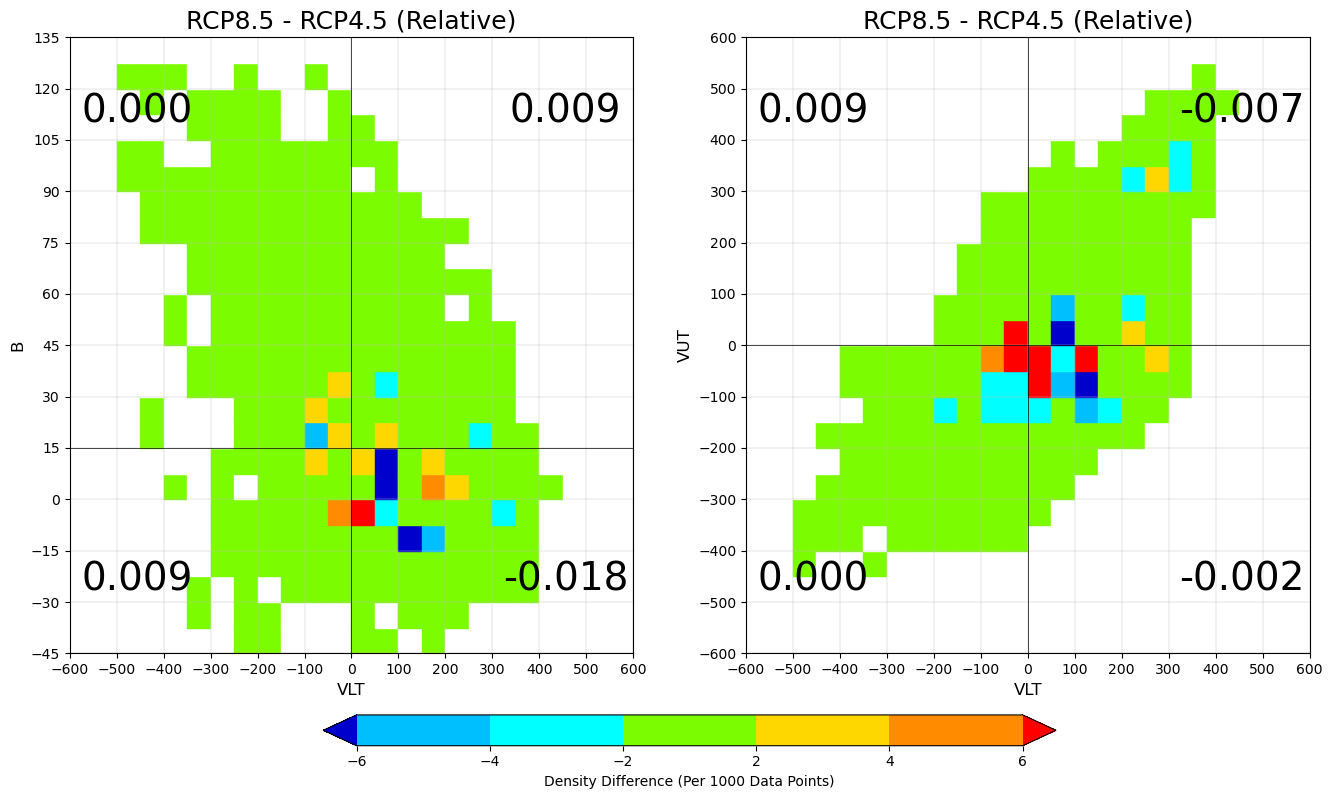

In [29]:
# Plot Relative Difference Between Phase Space Distributions of RCP8.5 - RCP4.5
Phase_Diff_Plot("RCP8.5", "RCP4.5", RCP85_VLT_B_Rela, RCP85_VLT_VUT_Rela, RCP45_VLT_B_Rela, RCP45_VLT_VUT_Rela, \
True, False, "RCP85-RCP45_Phase_Diff_Rela")

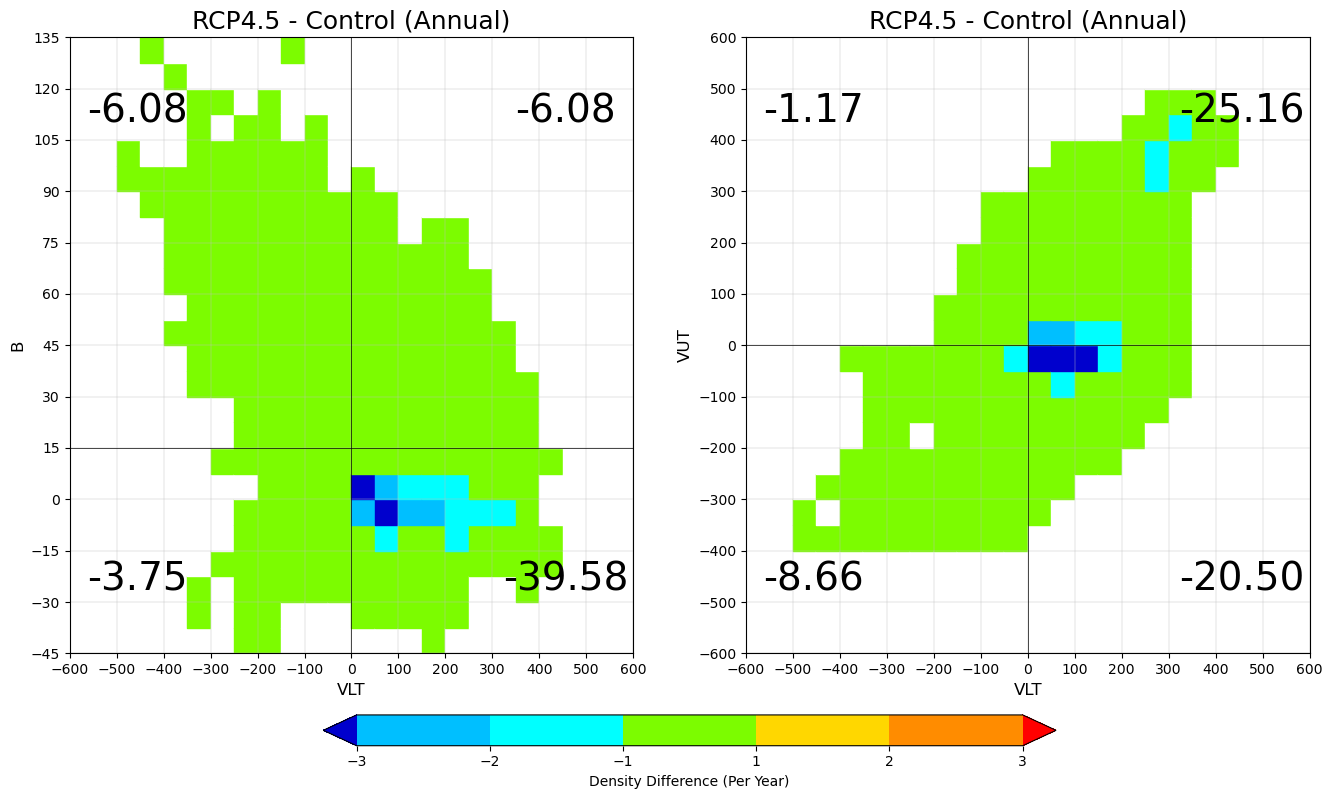

In [30]:
# Plot Annual Difference Between Phase Space Distributions of RCP4.5 - Control
Phase_Diff_Plot("RCP4.5", "Control", RCP45_VLT_B_Annual, RCP45_VLT_VUT_Annual, Control_VLT_B_Annual, Control_VLT_VUT_Annual, \
False, True, "RCP45-Control_Phase_Diff_Annual")

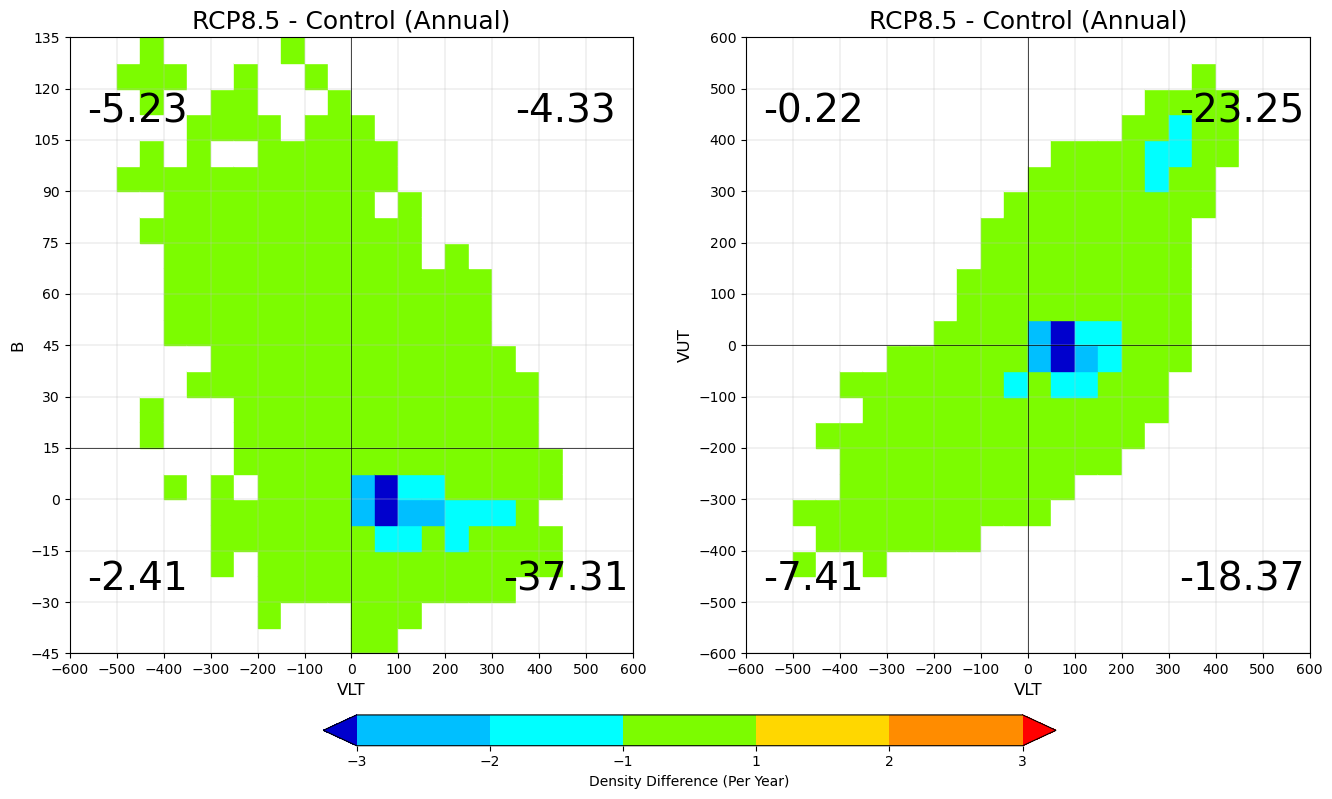

In [31]:
# Plot Annual Difference Between Phase Space Distributions of RCP8.5 - Control
Phase_Diff_Plot("RCP8.5", "Control", RCP85_VLT_B_Annual, RCP85_VLT_VUT_Annual, Control_VLT_B_Annual, Control_VLT_VUT_Annual, \
False, True, "RCP85-Control_Phase_Diff_Annual")

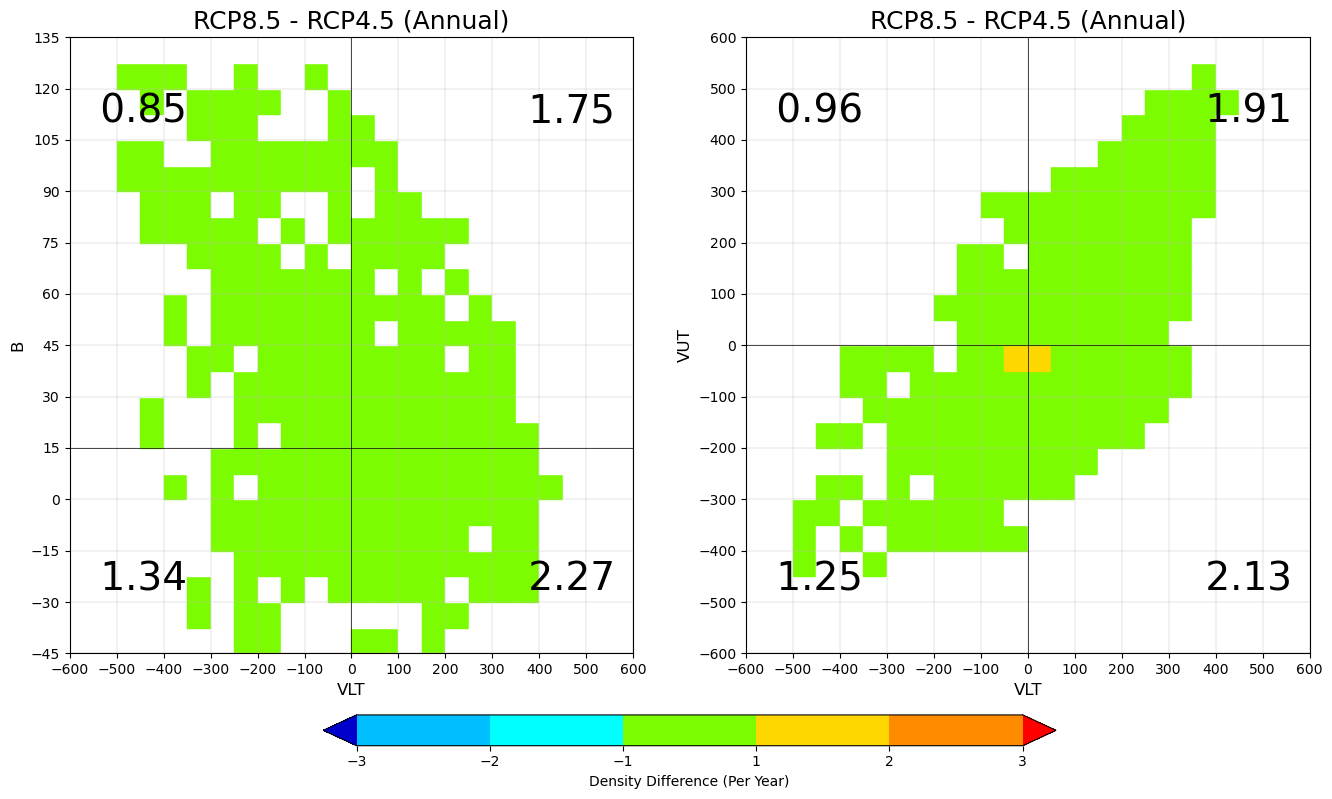

In [32]:
# Plot Annual Difference Between Phase Space Distributions of RCP8.5 - RCP4.5
Phase_Diff_Plot("RCP8.5", "RCP4.5", RCP85_VLT_B_Annual, RCP85_VLT_VUT_Annual, RCP45_VLT_B_Annual, RCP45_VLT_VUT_Annual, \
False, True, "RCP85-RCP45_Phase_Diff_Annual")

In [33]:
# Create Subset of Data: Below 990hPa
Control_990hPa = Control_Data[Control_Data["SLP(hPa)"] <= 990].reset_index()
RCP45_990hPa = RCP45_Data[RCP45_Data["SLP(hPa)"] <= 990].reset_index()
RCP85_990hPa = RCP85_Data[RCP85_Data["SLP(hPa)"] <= 990].reset_index()

In [34]:
# Phase Space Distribution For Control Run (Relative)
Control_VLT_B_Rela_990hPa, Control_VLT_VUT_Rela_990hPa = Phase_Space_Distribution(Control_990hPa, VLT_Bins, B_Bins, "Control", True)
# Phase Space Distribution For RCP4.5 Run (Relative)
RCP45_VLT_B_Rela_990hPa, RCP45_VLT_VUT_Rela_990hPa = Phase_Space_Distribution(RCP45_990hPa, VLT_Bins, B_Bins, "RCP4.5", True)
# Phase Space Distribution For RCP8.5 Run (Relative)
RCP85_VLT_B_Rela_990hPa, RCP85_VLT_VUT_Rela_990hPa = Phase_Space_Distribution(RCP85_990hPa, VLT_Bins, B_Bins, "RCP8.5", True)

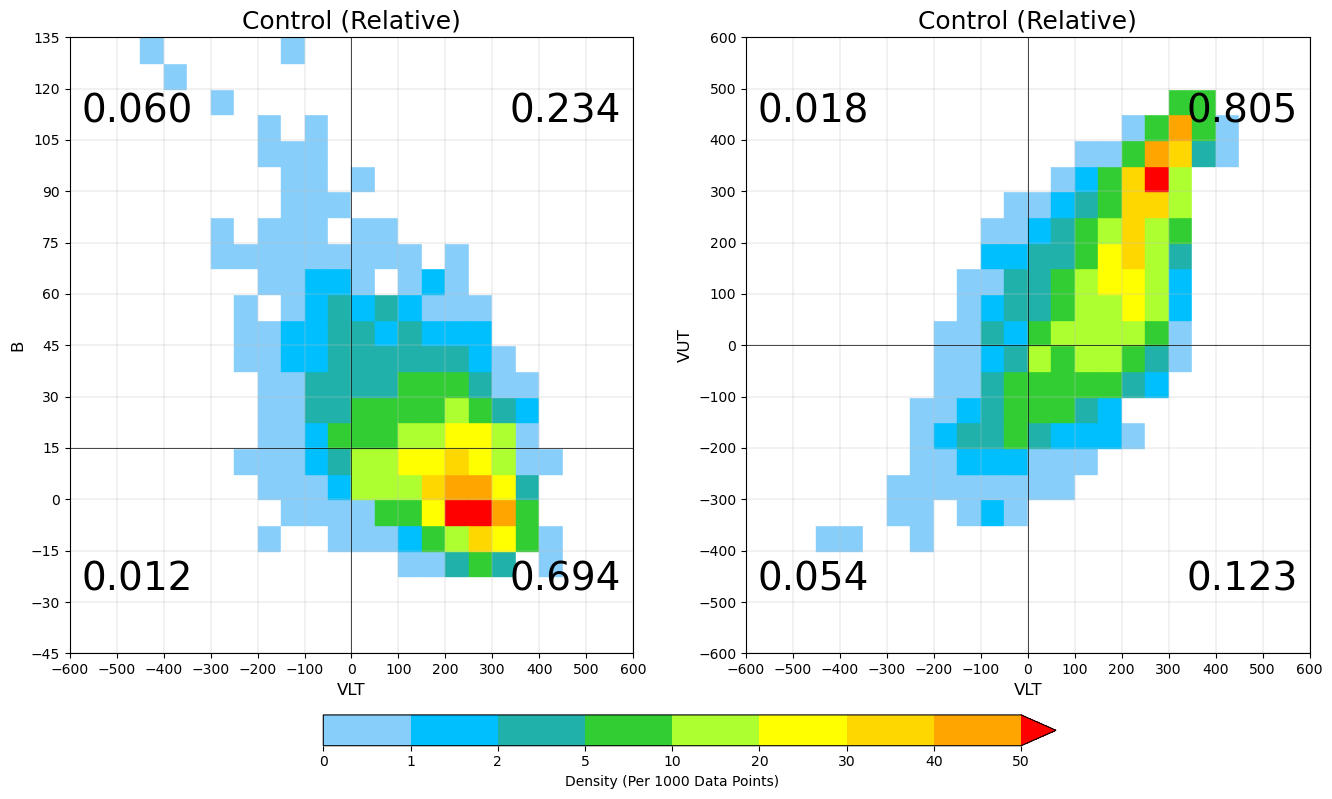

In [35]:
# Plot Relative Phase Space Distribution For Control Run
Fig = Phase_Distr_Plot(Control_VLT_B_Rela_990hPa, Control_VLT_VUT_Rela_990hPa, "Control", True, True, \
"Control_Phase_Distr_990hPa")

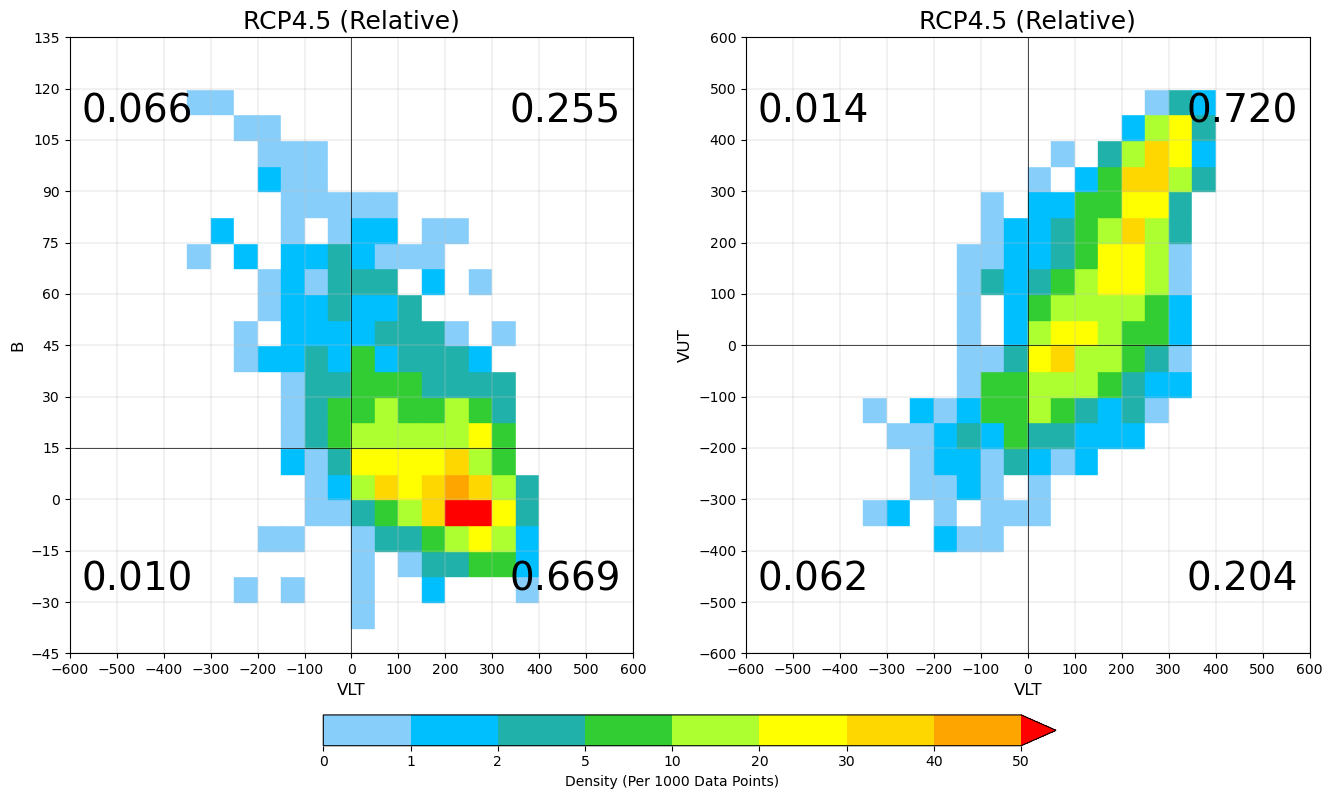

In [36]:
# Plot Relative Phase Space Distribution For RCP4.5 Run
Fig = Phase_Distr_Plot(RCP45_VLT_B_Rela_990hPa, RCP45_VLT_VUT_Rela_990hPa, "RCP4.5", True, False, \
"RCP45_Phase_Distr_990hPa")

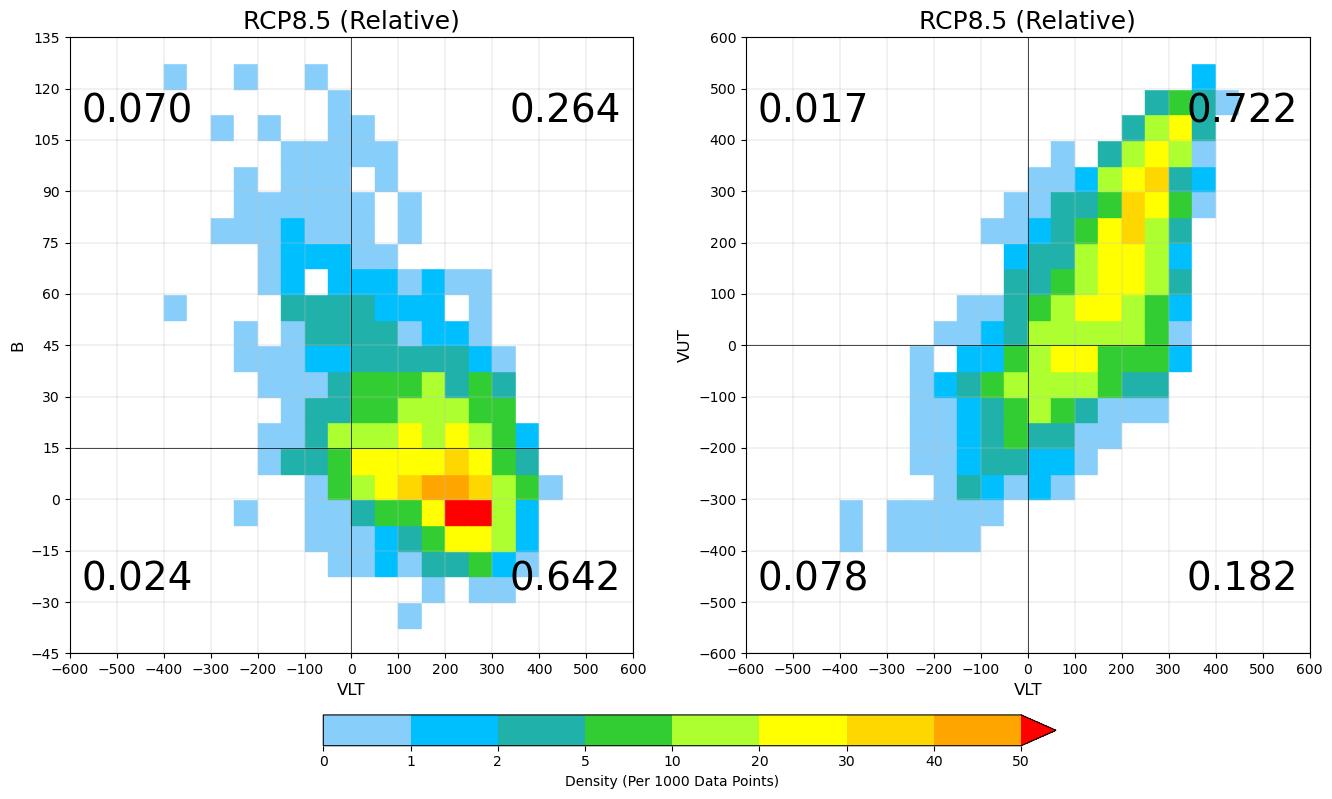

In [37]:
# Plot Relative Phase Space Distribution For RCP8.5 Run
Fig = Phase_Distr_Plot(RCP85_VLT_B_Rela_990hPa, RCP85_VLT_VUT_Rela_990hPa, "RCP8.5", True, False, \
"RCP85_Phase_Distr_990hPa")

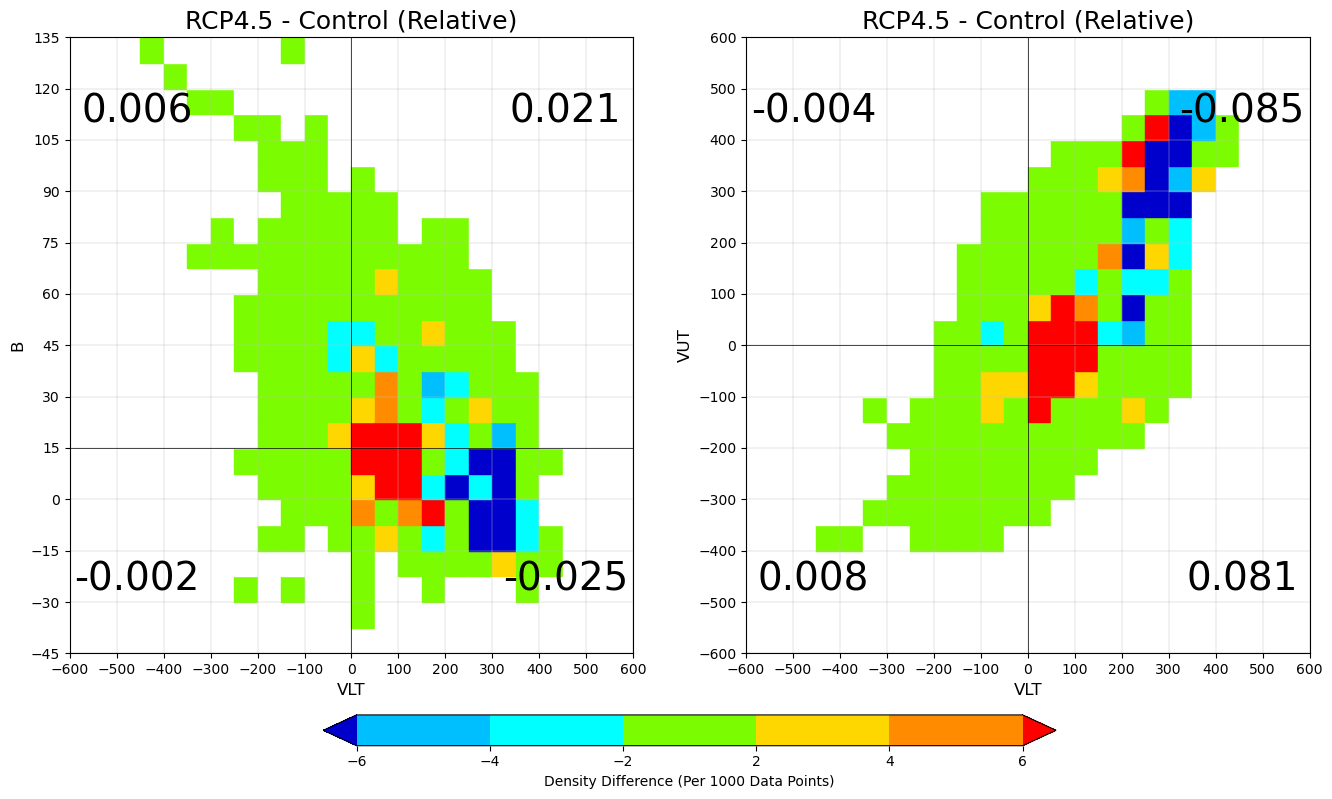

In [38]:
# Plot Relative Difference Between Phase Space Distributions of RCP4.5 - Control
Phase_Diff_Plot("RCP4.5", "Control", RCP45_VLT_B_Rela_990hPa, RCP45_VLT_VUT_Rela_990hPa, Control_VLT_B_Rela_990hPa, Control_VLT_VUT_Rela_990hPa, \
True, True, "RCP45-Control_Phase_Diff_990hPa")

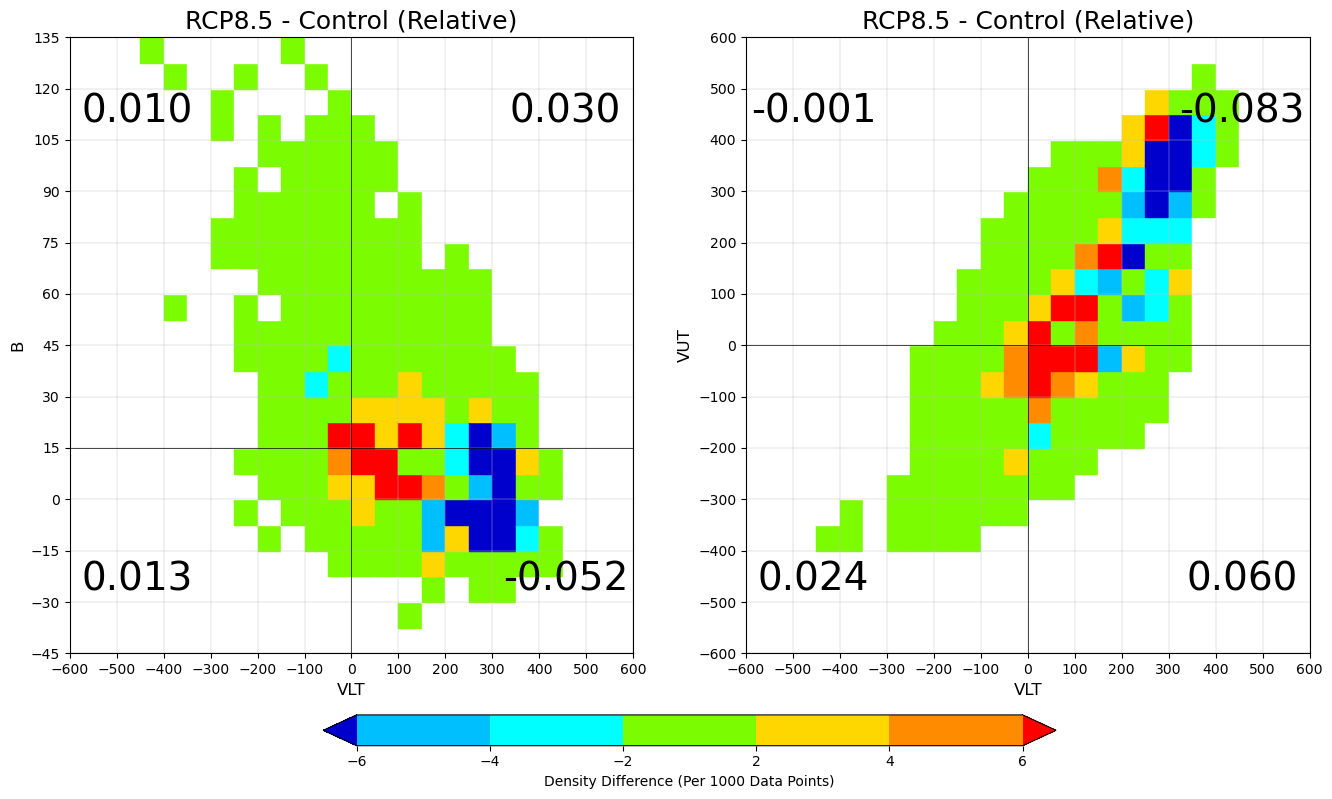

In [39]:
# Plot Relative Difference Between Phase Space Distributions of RCP8.5 - Control
Phase_Diff_Plot("RCP8.5", "Control", RCP85_VLT_B_Rela_990hPa, RCP85_VLT_VUT_Rela_990hPa, Control_VLT_B_Rela_990hPa, Control_VLT_VUT_Rela_990hPa, \
True, True, "RCP85-Control_Phase_Diff_990hPa")

In [40]:
# Create Subset of Data: Below 980hPa
Control_980hPa = Control_Data[Control_Data["SLP(hPa)"] <= 980].reset_index()
RCP45_980hPa = RCP45_Data[RCP45_Data["SLP(hPa)"] <= 980].reset_index()
RCP85_980hPa = RCP85_Data[RCP85_Data["SLP(hPa)"] <= 980].reset_index()

In [41]:
# Phase Space Distribution For Control Run (Relative)
Control_VLT_B_Rela_980hPa, Control_VLT_VUT_Rela_980hPa = Phase_Space_Distribution(Control_980hPa, VLT_Bins, B_Bins, "Control", True)
# Phase Space Distribution For RCP4.5 Run (Relative)
RCP45_VLT_B_Rela_980hPa, RCP45_VLT_VUT_Rela_980hPa = Phase_Space_Distribution(RCP45_980hPa, VLT_Bins, B_Bins, "RCP4.5", True)
# Phase Space Distribution For RCP8.5 Run (Relative)
RCP85_VLT_B_Rela_980hPa, RCP85_VLT_VUT_Rela_980hPa = Phase_Space_Distribution(RCP85_980hPa, VLT_Bins, B_Bins, "RCP8.5", True)

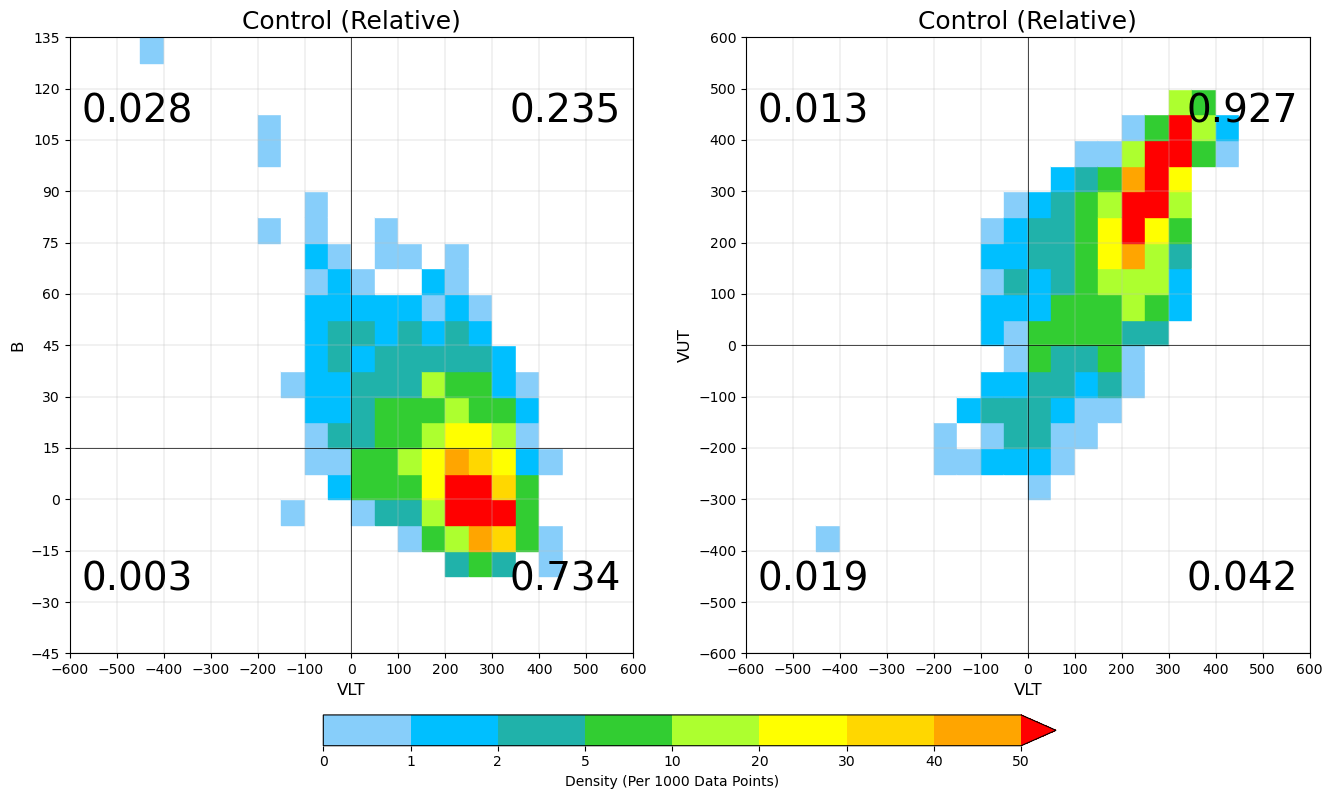

In [42]:
# Plot Relative Phase Space Distribution For Control Run
Fig = Phase_Distr_Plot(Control_VLT_B_Rela_980hPa, Control_VLT_VUT_Rela_980hPa, "Control", True, True, \
"Control_Phase_Distr_980hPa")

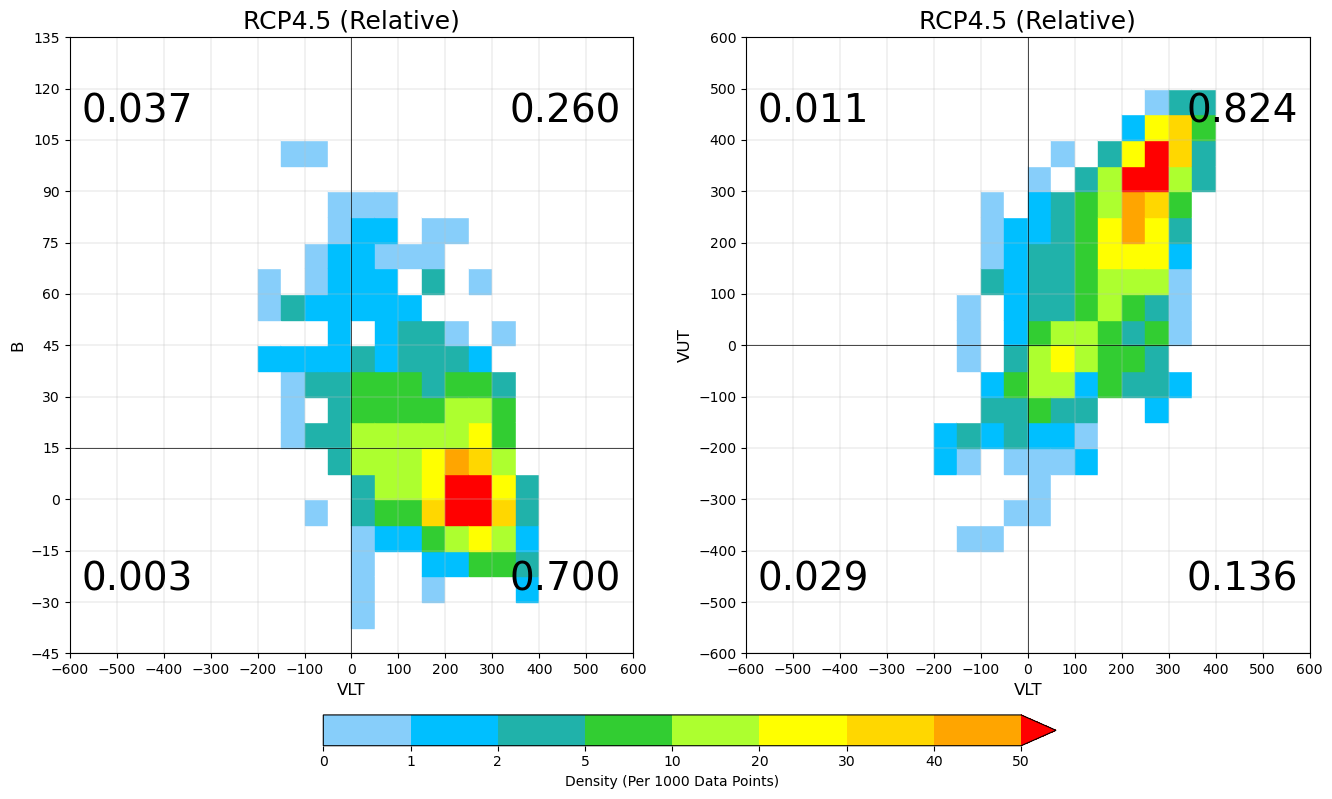

In [43]:
# Plot Relative Phase Space Distribution For RCP4.5 Run
Fig = Phase_Distr_Plot(RCP45_VLT_B_Rela_980hPa, RCP45_VLT_VUT_Rela_980hPa, "RCP4.5", True, False, \
"RCP45_Phase_Distr_980hPa")

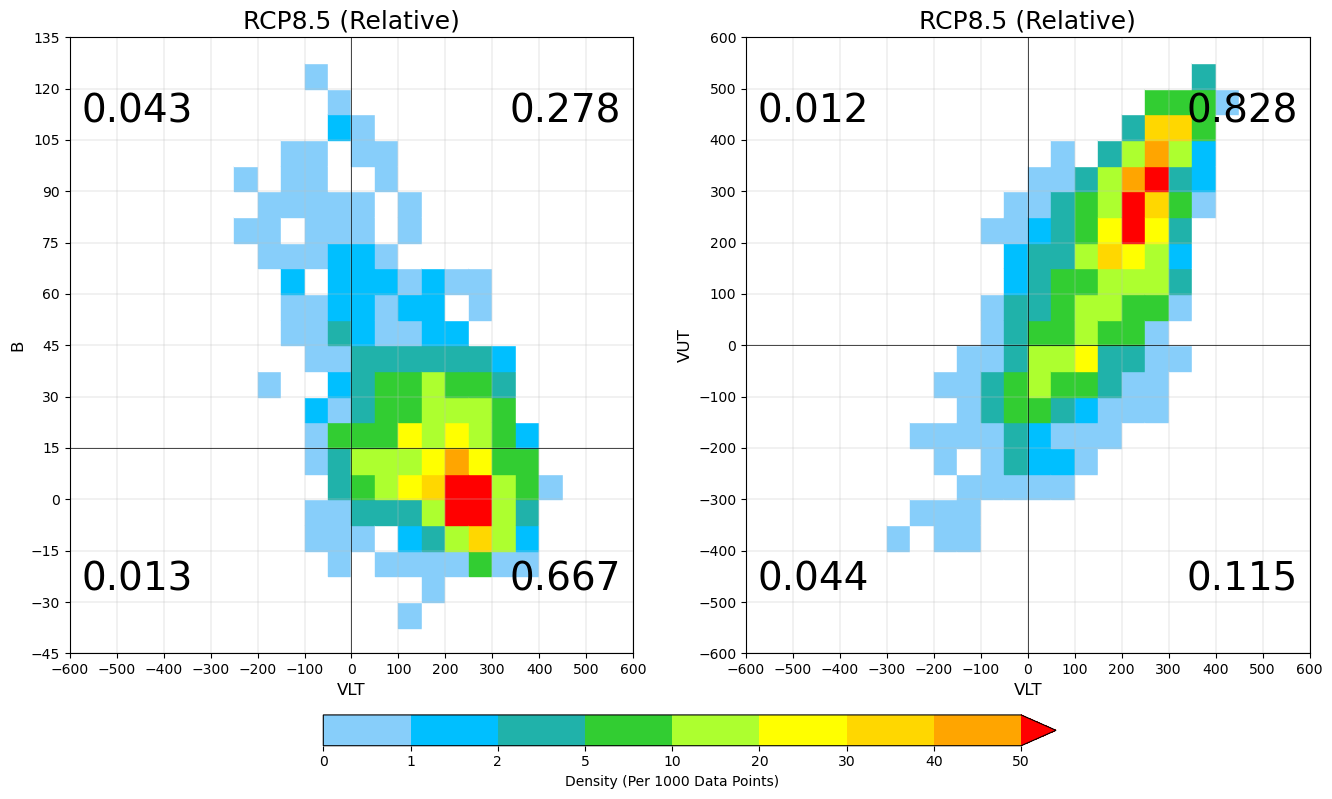

In [44]:
# Plot Relative Phase Space Distribution For RCP8.5 Run
Fig = Phase_Distr_Plot(RCP85_VLT_B_Rela_980hPa, RCP85_VLT_VUT_Rela_980hPa, "RCP8.5", True, False, \
"RCP85_Phase_Distr_980hPa")

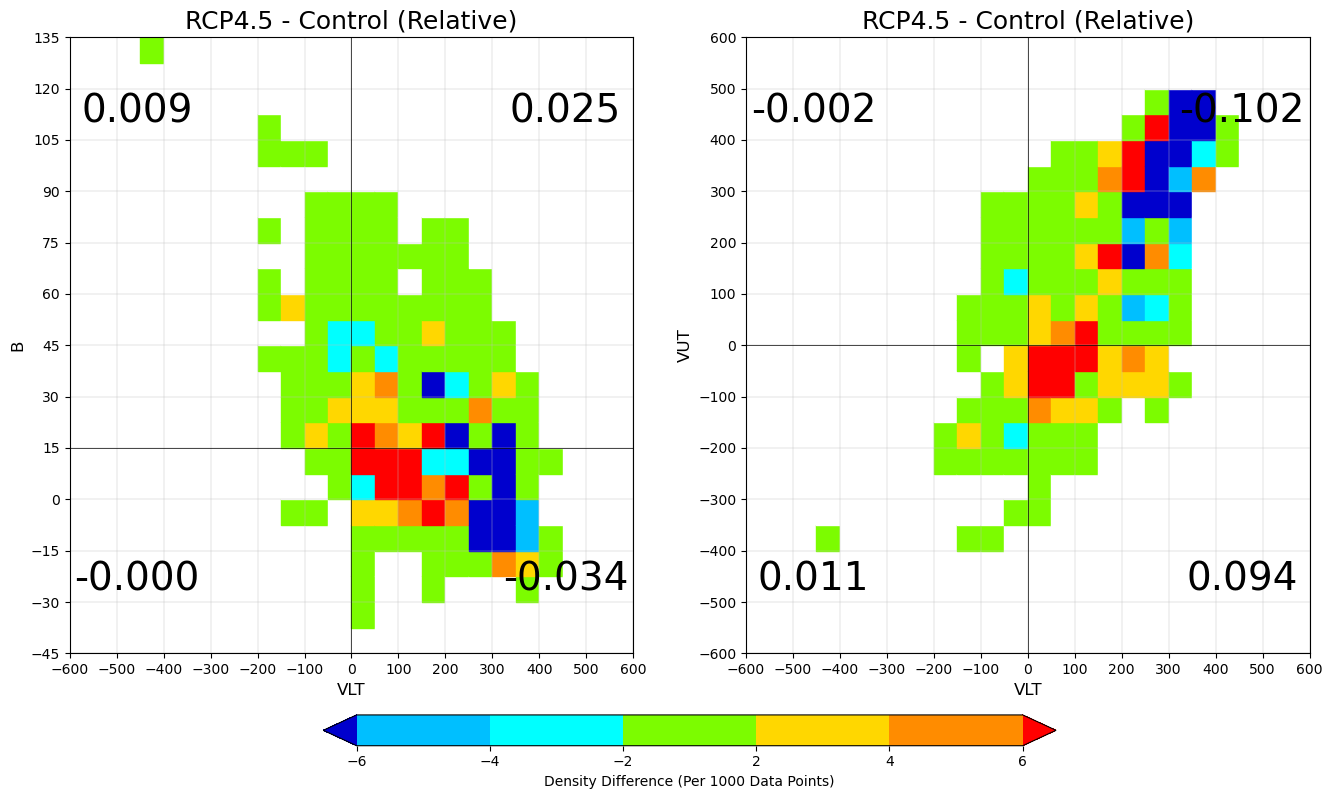

In [45]:
# Plot Relative Difference Between Phase Space Distributions of RCP4.5 - Control
Phase_Diff_Plot("RCP4.5", "Control", RCP45_VLT_B_Rela_980hPa, RCP45_VLT_VUT_Rela_980hPa, Control_VLT_B_Rela_980hPa, Control_VLT_VUT_Rela_980hPa, \
True, True, "RCP45-Control_Phase_Diff_980hPa")

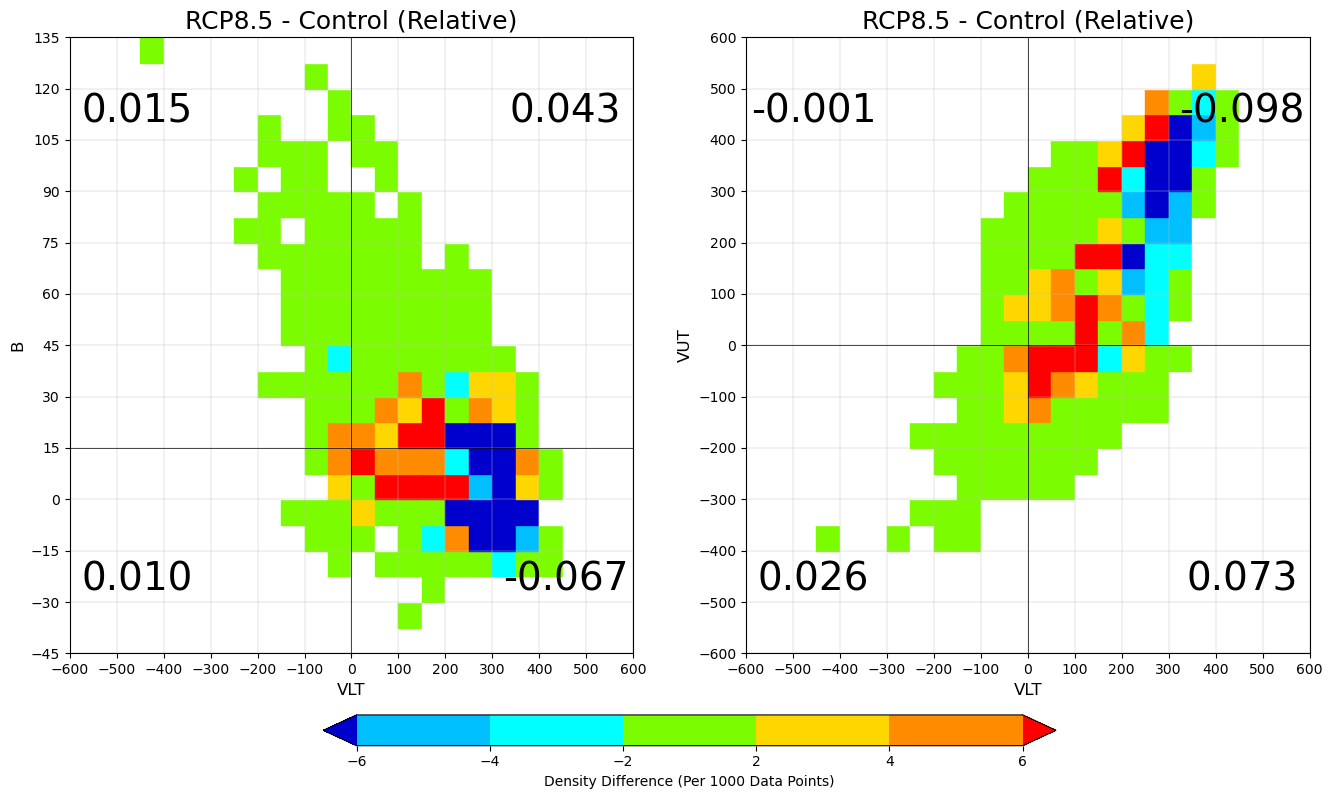

In [46]:
# Plot Relative Difference Between Phase Space Distributions of RCP8.5 - Control
Phase_Diff_Plot("RCP8.5", "Control", RCP85_VLT_B_Rela_980hPa, RCP85_VLT_VUT_Rela_980hPa, Control_VLT_B_Rela_980hPa, Control_VLT_VUT_Rela_980hPa, \
True, True, "RCP85-Control_Phase_Diff_980hPa")

In [47]:
# Create Subset of Data: Below 25N Latitude
Control_25N_Below = Control_Data[Control_Data["Lat"] < 25].reset_index()
RCP45_25N_Below = RCP45_Data[RCP45_Data["Lat"] < 25].reset_index()
RCP85_25N_Below = RCP85_Data[RCP85_Data["Lat"] < 25].reset_index()

In [48]:
# Phase Space Distribution For Control Run (Relative)
Control_VLT_B_25N_Below, Control_VLT_VUT_25N_Below = Phase_Space_Distribution(Control_25N_Below, VLT_Bins, B_Bins, "Control", True)
# Phase Space Distribution For RCP4.5 Run (Relative)
RCP45_VLT_B_25N_Below, RCP45_VLT_VUT_25N_Below = Phase_Space_Distribution(RCP45_25N_Below, VLT_Bins, B_Bins, "RCP4.5", True)
# Phase Space Distribution For RCP8.5 Run (Relative)
RCP85_VLT_B_25N_Below, RCP85_VLT_VUT_25N_Below = Phase_Space_Distribution(RCP85_25N_Below, VLT_Bins, B_Bins, "RCP8.5", True)

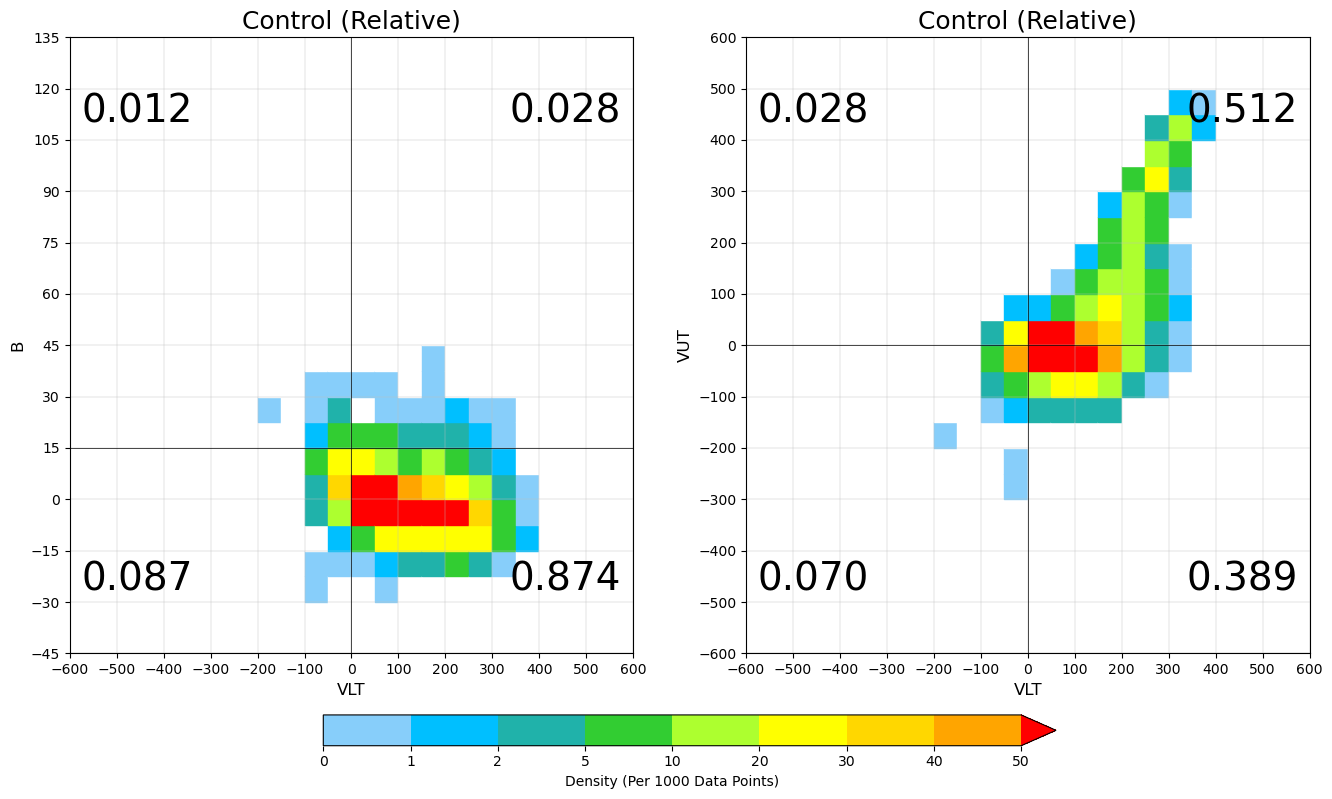

In [49]:
# Plot Relative Phase Space Distribution For Control Run
Fig = Phase_Distr_Plot(Control_VLT_B_25N_Below, Control_VLT_VUT_25N_Below, "Control", True, True, \
"Control_Phase_Distr_25N_Below")

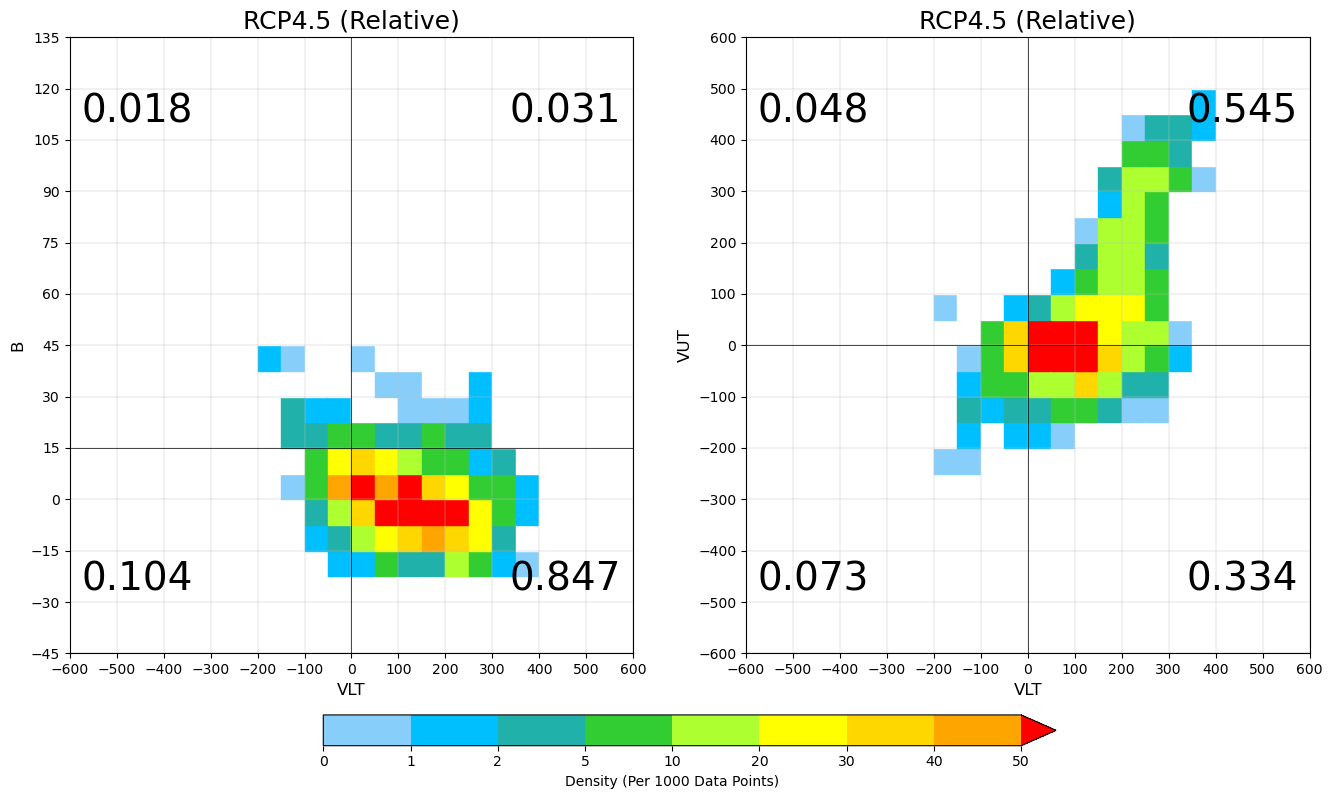

In [50]:
# Plot Relative Phase Space Distribution For RCP4.5 Run
Fig = Phase_Distr_Plot(RCP45_VLT_B_25N_Below, RCP45_VLT_VUT_25N_Below, "RCP4.5", True, False, "")

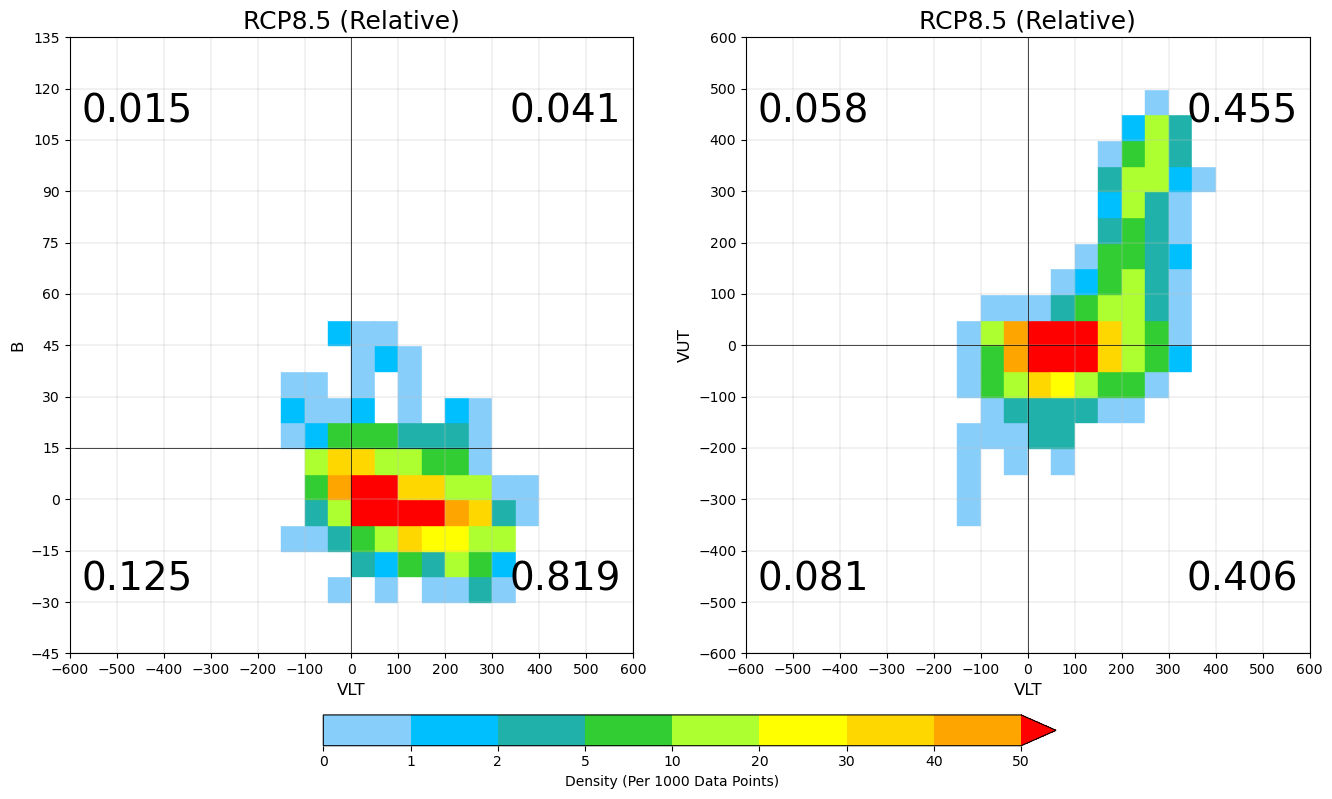

In [51]:
# Plot Relative Phase Space Distribution For RCP8.5 Run
Fig = Phase_Distr_Plot(RCP85_VLT_B_25N_Below, RCP85_VLT_VUT_25N_Below, "RCP8.5", True, False, "")

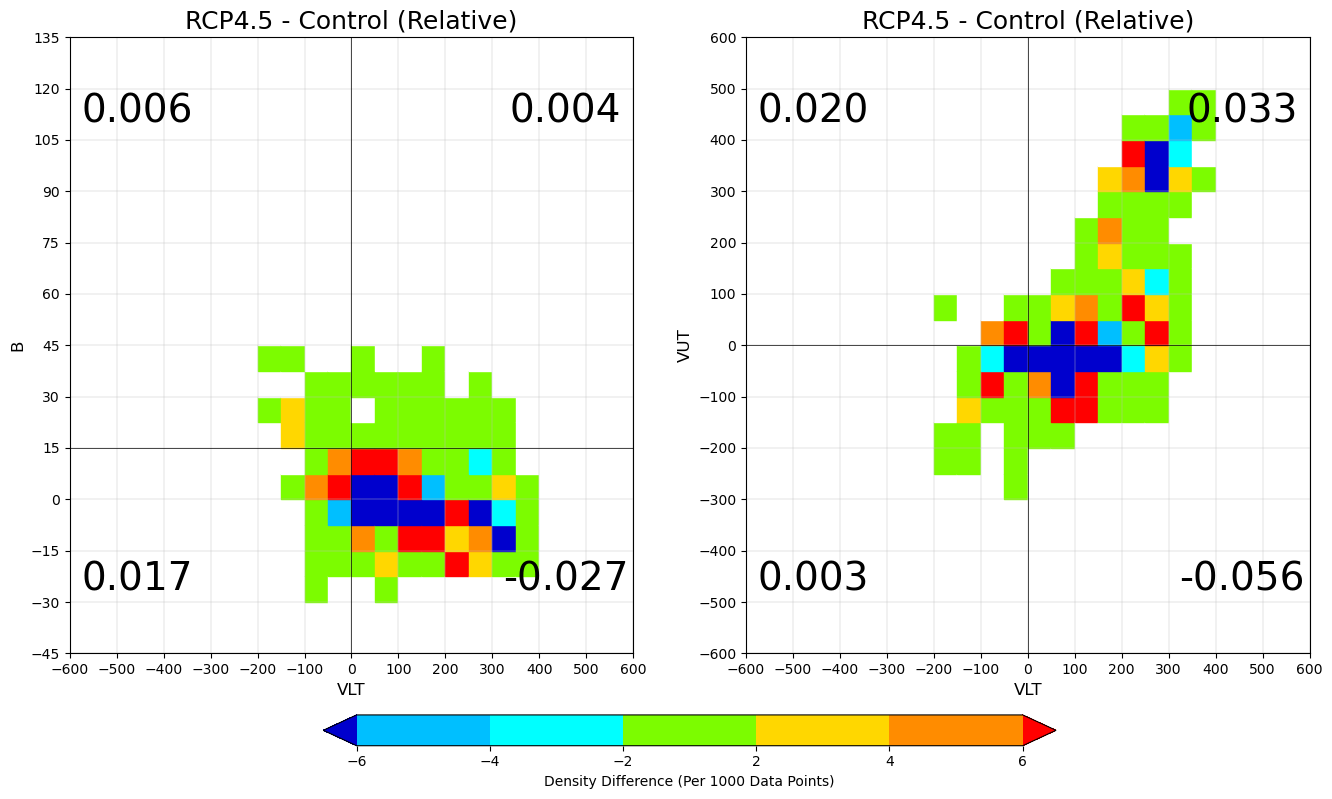

In [52]:
# Plot Relative Difference Between Phase Space Distributions of RCP4.5 - Control
Phase_Diff_Plot("RCP4.5", "Control", RCP45_VLT_B_25N_Below, RCP45_VLT_VUT_25N_Below, Control_VLT_B_25N_Below, Control_VLT_VUT_25N_Below, \
True, True, "RCP45-Control_Phase_Diff_25N_Below")

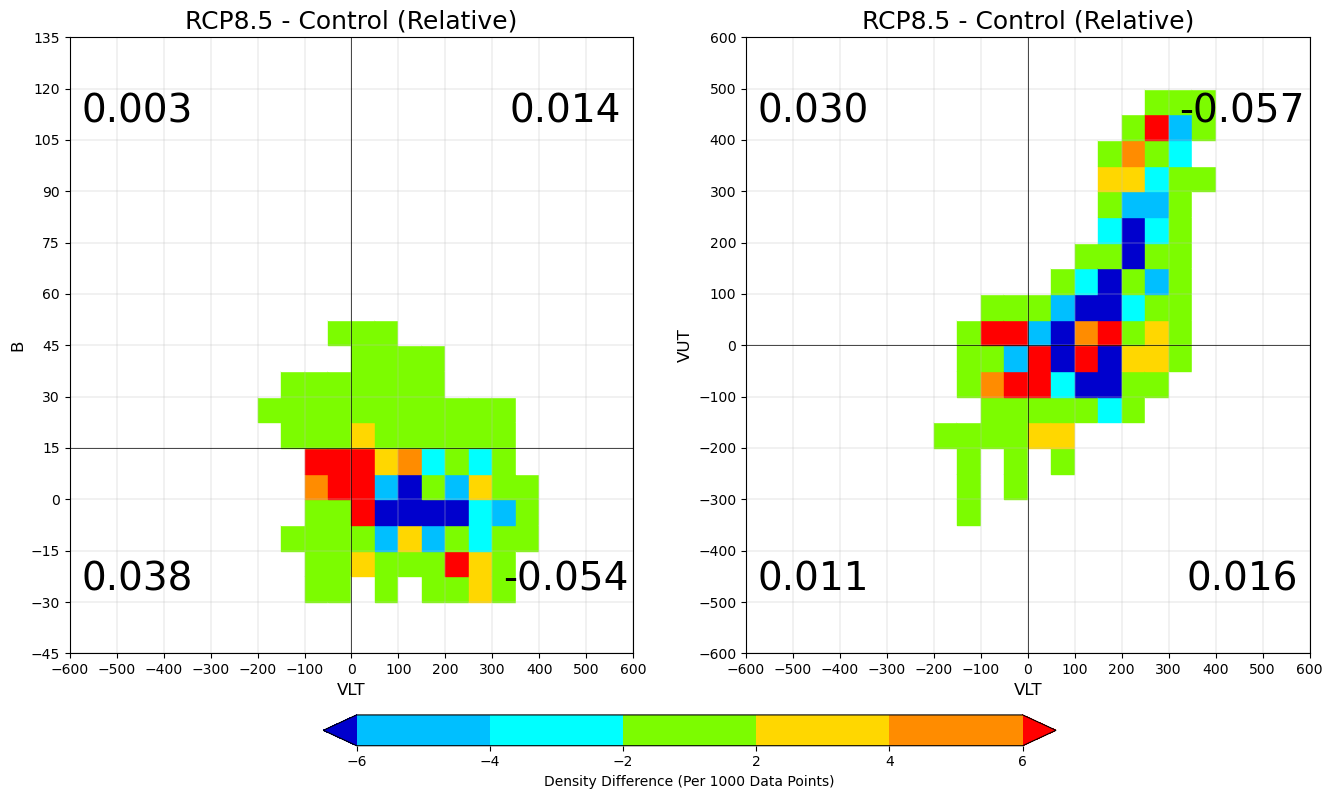

In [53]:
# Plot Relative Difference Between Phase Space Distributions of RCP8.5 - Control
Phase_Diff_Plot("RCP8.5", "Control", RCP85_VLT_B_25N_Below, RCP85_VLT_VUT_25N_Below, Control_VLT_B_25N_Below, Control_VLT_VUT_25N_Below, \
True, True, "RCP85-Control_Phase_Diff_25N_Below")

In [54]:
# Create Subset of Data: 25~30N Latitude
Control_25_30N = Control_Data[(Control_Data["Lat"] >= 25) & (Control_Data["Lat"] < 30)].reset_index()
RCP45_25_30N = RCP45_Data[(RCP45_Data["Lat"] >= 25) & (RCP45_Data["Lat"] < 30)].reset_index()
RCP85_25_30N = RCP85_Data[(RCP85_Data["Lat"] >= 25) & (RCP85_Data["Lat"] < 30)].reset_index()

In [55]:
# Phase Space Distribution For Control Run (Relative)
Control_VLT_B_25_30N, Control_VLT_VUT_25_30N = Phase_Space_Distribution(Control_25_30N, VLT_Bins, B_Bins, "Control", True)
# Phase Space Distribution For RCP4.5 Run (Relative)
RCP45_VLT_B_25_30N, RCP45_VLT_VUT_25_30N = Phase_Space_Distribution(RCP45_25_30N, VLT_Bins, B_Bins, "RCP4.5", True)
# Phase Space Distribution For RCP8.5 Run (Relative)
RCP85_VLT_B_25_30N, RCP85_VLT_VUT_25_30N = Phase_Space_Distribution(RCP85_25_30N, VLT_Bins, B_Bins, "RCP8.5", True)

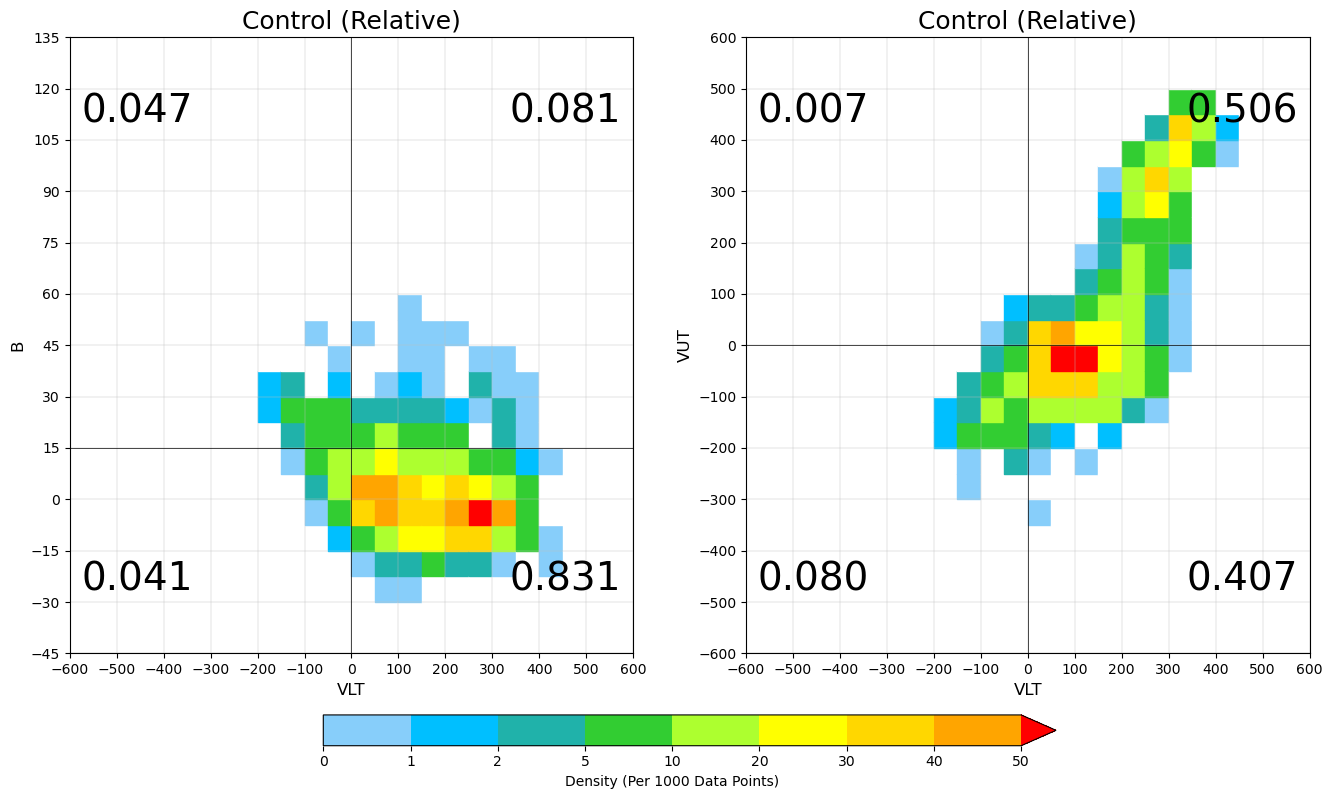

In [56]:
# Plot Relative Phase Space Distribution For Control Run
Fig = Phase_Distr_Plot(Control_VLT_B_25_30N, Control_VLT_VUT_25_30N, "Control", True, False, \
"Control_Phase_Distr_25_30N")

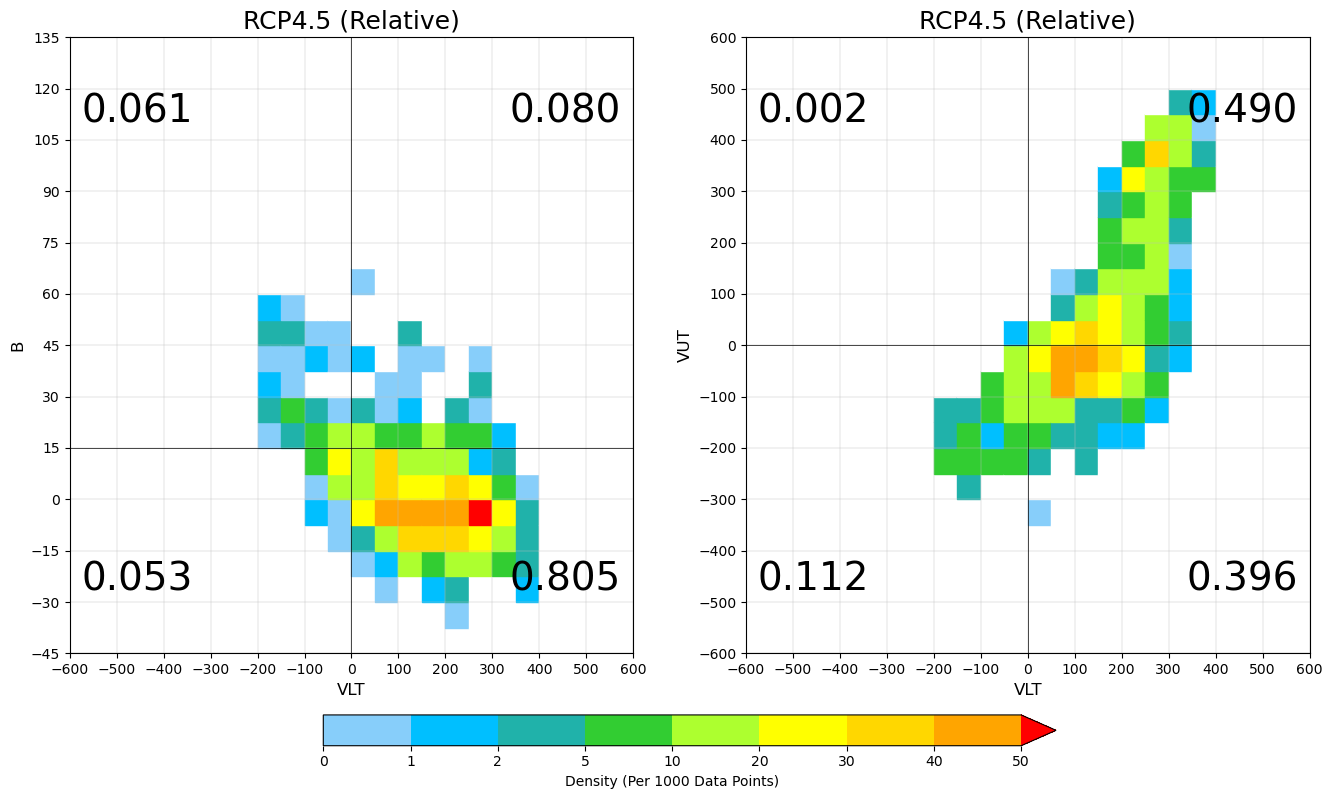

In [57]:
# Plot Relative Phase Space Distribution For RCP4.5 Run
Fig = Phase_Distr_Plot(RCP45_VLT_B_25_30N, RCP45_VLT_VUT_25_30N, "RCP4.5", True, False, "")

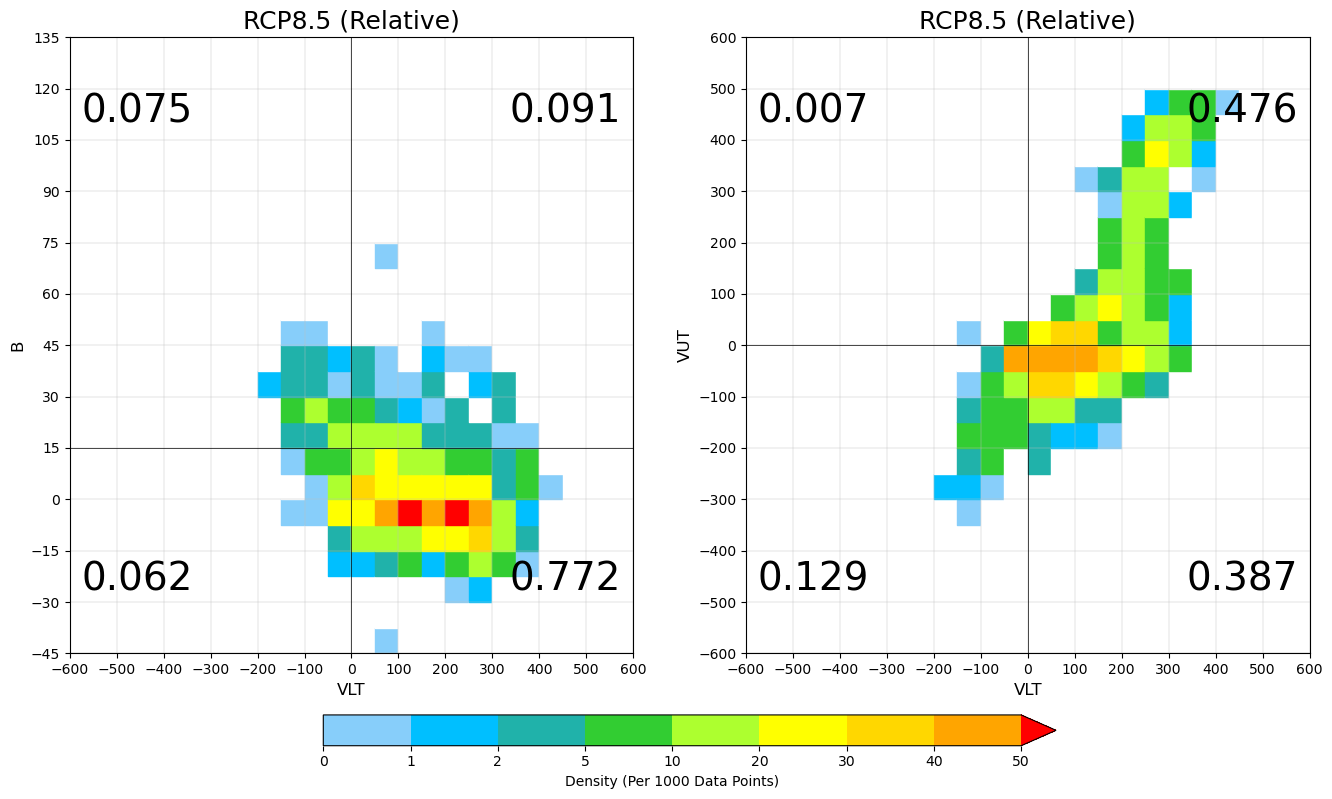

In [58]:
# Plot Relative Phase Space Distribution For RCP8.5 Run
Fig = Phase_Distr_Plot(RCP85_VLT_B_25_30N, RCP85_VLT_VUT_25_30N, "RCP8.5", True, False, "")

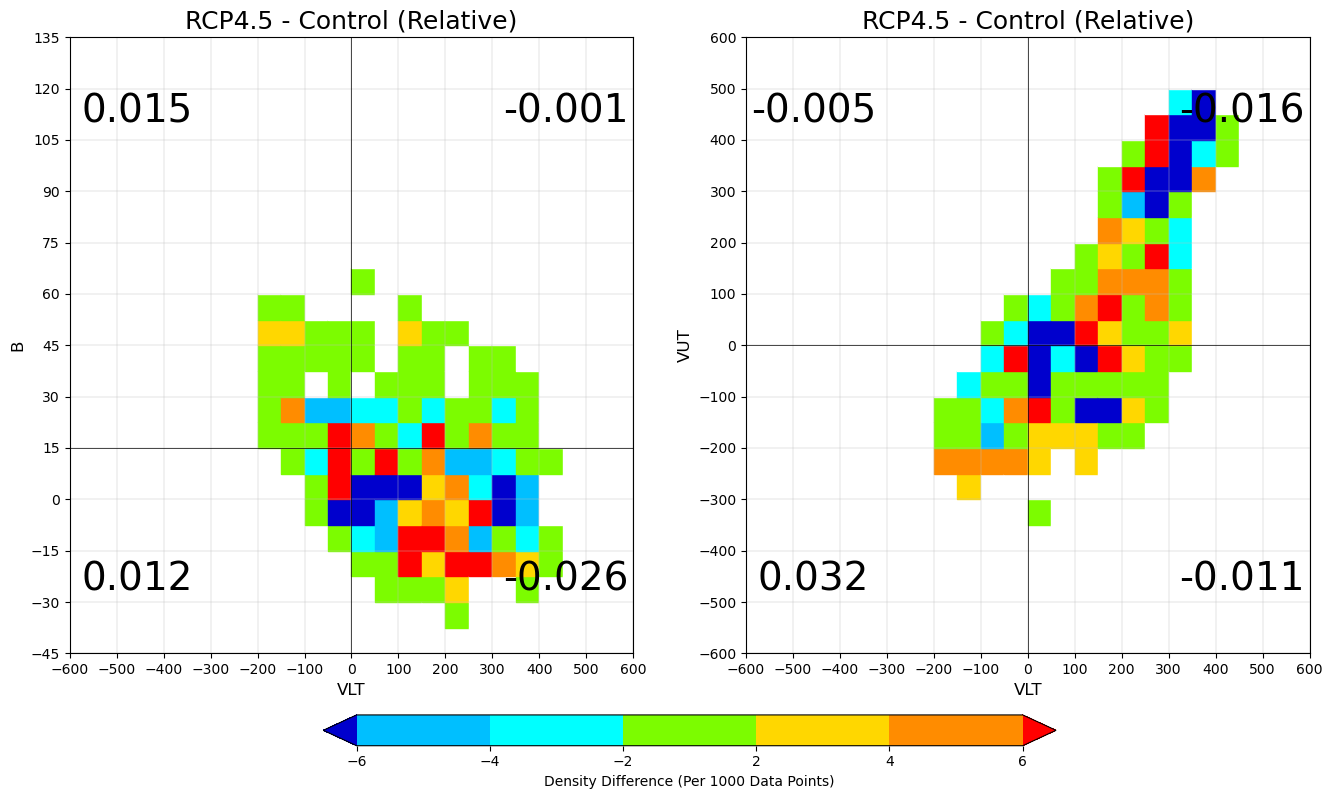

In [59]:
# Plot Relative Difference Between Phase Space Distributions of RCP4.5 - Control
Phase_Diff_Plot("RCP4.5", "Control", RCP45_VLT_B_25_30N, RCP45_VLT_VUT_25_30N, Control_VLT_B_25_30N, Control_VLT_VUT_25_30N, \
True, False, "RCP45-Control_Phase_Diff_25_30N")

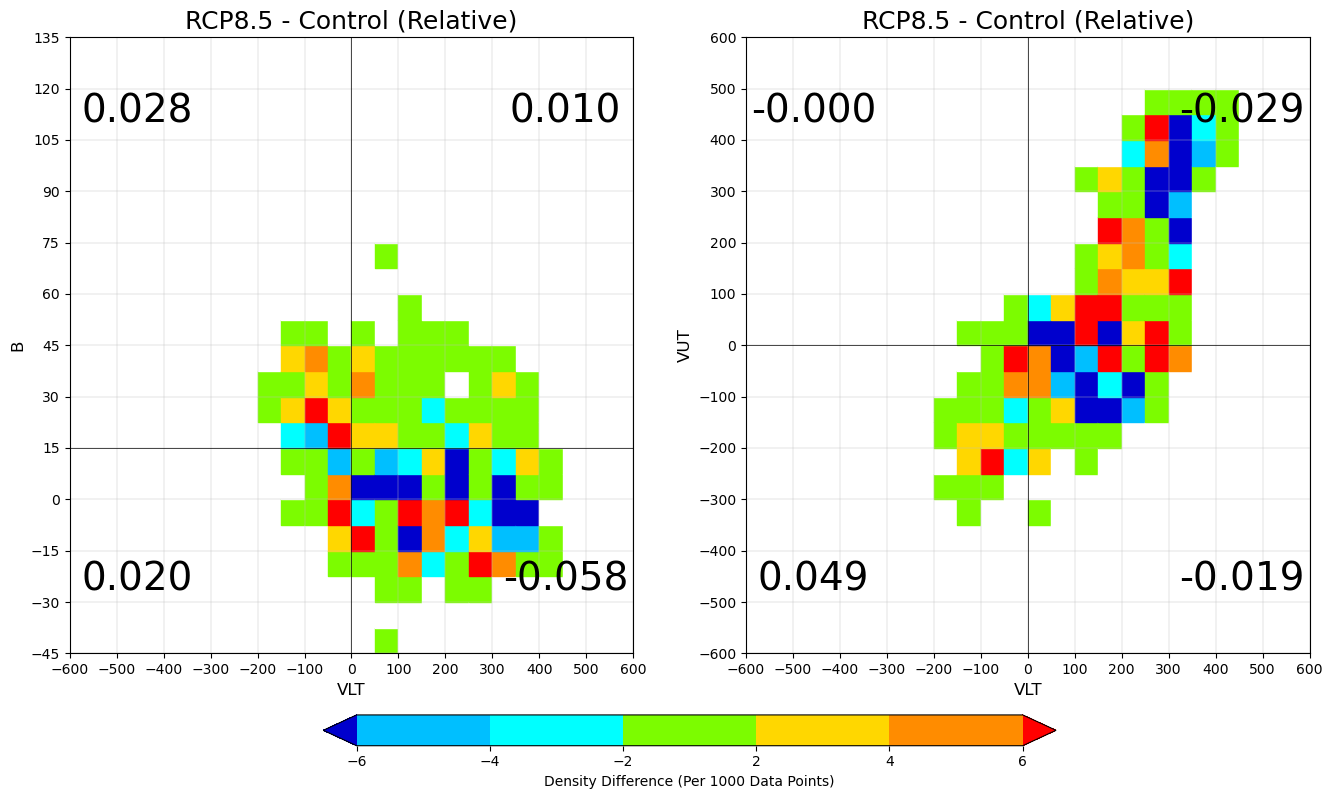

In [60]:
# Plot Relative Difference Between Phase Space Distributions of RCP8.5 - Control
Phase_Diff_Plot("RCP8.5", "Control", RCP85_VLT_B_25_30N, RCP85_VLT_VUT_25_30N, Control_VLT_B_25_30N, Control_VLT_VUT_25_30N, \
True, False, "RCP85-Control_Phase_Diff_25_30N")

In [61]:
# Create Subset of Data: 30~35N Latitude
Control_30_35N = Control_Data[(Control_Data["Lat"] >= 30) & (Control_Data["Lat"] < 35)].reset_index()
RCP45_30_35N = RCP45_Data[(RCP45_Data["Lat"] >= 30) & (RCP45_Data["Lat"] < 35)].reset_index()
RCP85_30_35N = RCP85_Data[(RCP85_Data["Lat"] >= 30) & (RCP85_Data["Lat"] < 35)].reset_index()

In [62]:
# Phase Space Distribution For Control Run (Relative)
Control_VLT_B_30_35N, Control_VLT_VUT_30_35N = Phase_Space_Distribution(Control_30_35N, VLT_Bins, B_Bins, "Control", True)
# Phase Space Distribution For RCP4.5 Run (Relative)
RCP45_VLT_B_30_35N, RCP45_VLT_VUT_30_35N = Phase_Space_Distribution(RCP45_30_35N, VLT_Bins, B_Bins, "RCP4.5", True)
# Phase Space Distribution For RCP8.5 Run (Relative)
RCP85_VLT_B_30_35N, RCP85_VLT_VUT_30_35N = Phase_Space_Distribution(RCP85_30_35N, VLT_Bins, B_Bins, "RCP8.5", True)

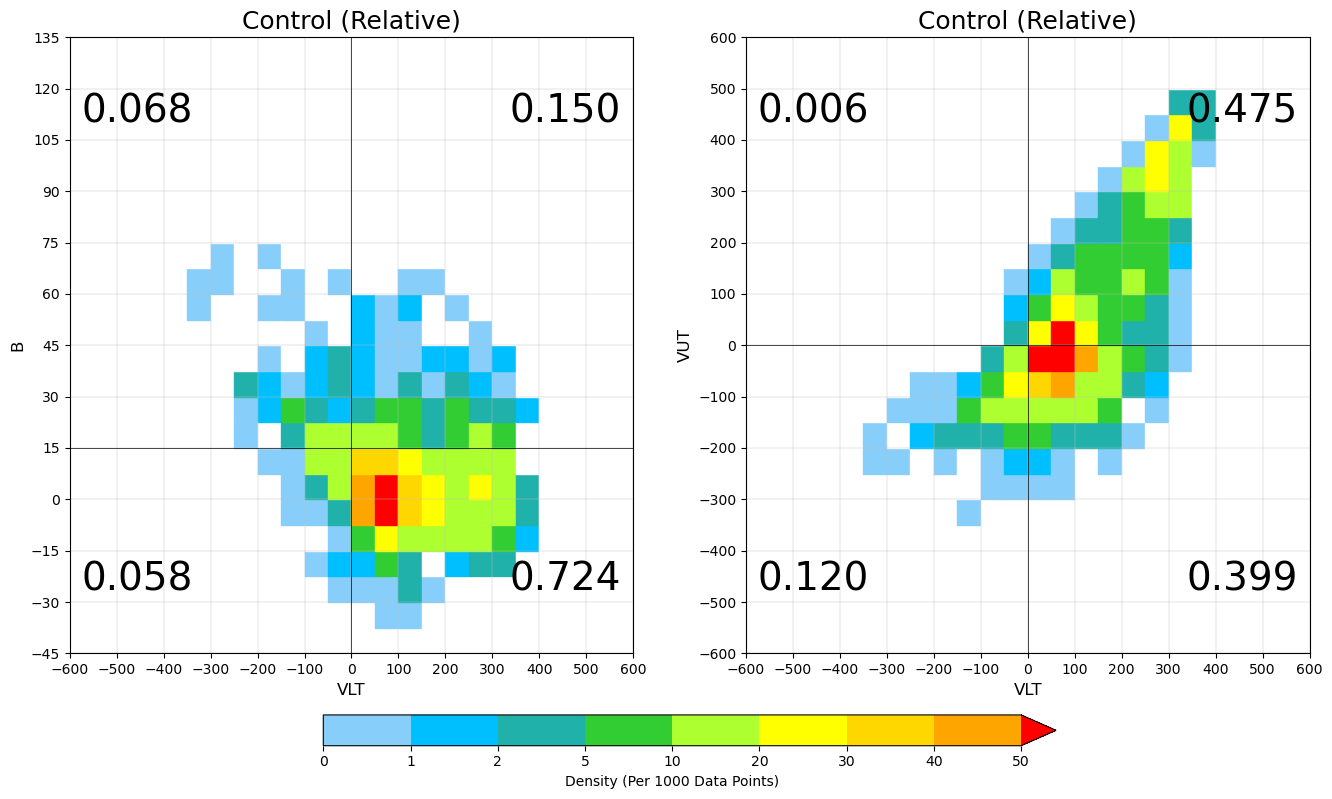

In [63]:
# Plot Relative Phase Space Distribution For Control Run
Fig = Phase_Distr_Plot(Control_VLT_B_30_35N, Control_VLT_VUT_30_35N, "Control", True, False, \
"Control_Phase_Distr_30_35N")

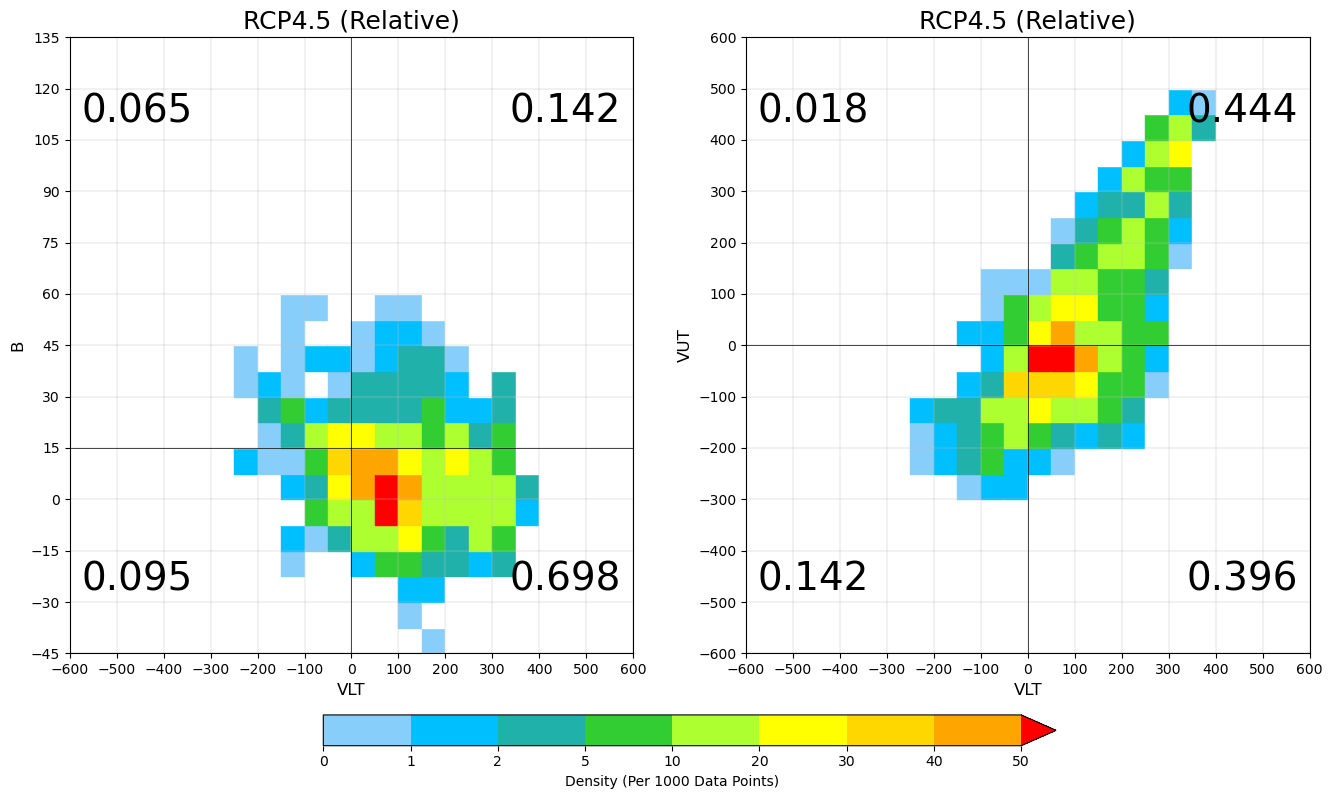

In [64]:
# Plot Relative Phase Space Distribution For RCP4.5 Run
Fig = Phase_Distr_Plot(RCP45_VLT_B_30_35N, RCP45_VLT_VUT_30_35N, "RCP4.5", True, False, "")

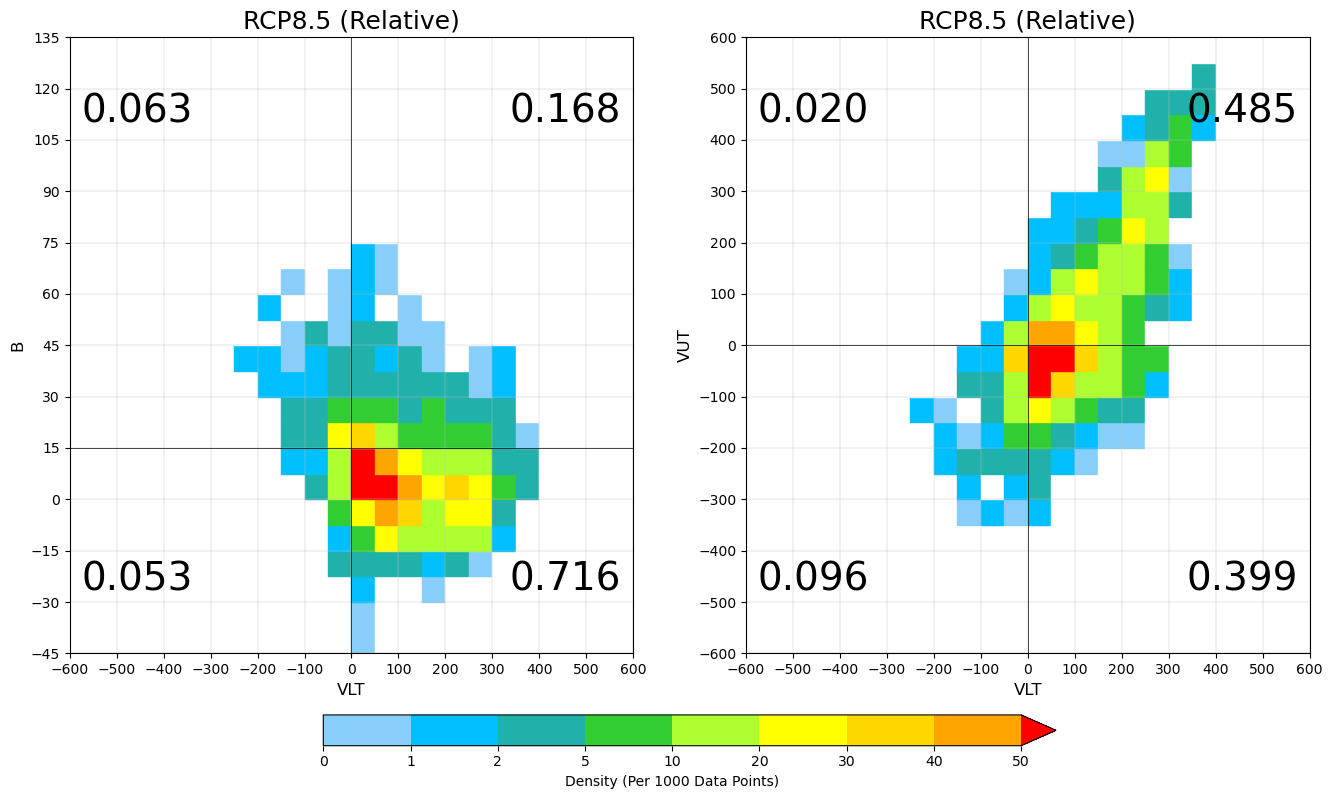

In [65]:
# Plot Relative Phase Space Distribution For RCP8.5 Run
Fig = Phase_Distr_Plot(RCP85_VLT_B_30_35N, RCP85_VLT_VUT_30_35N, "RCP8.5", True, False, "")

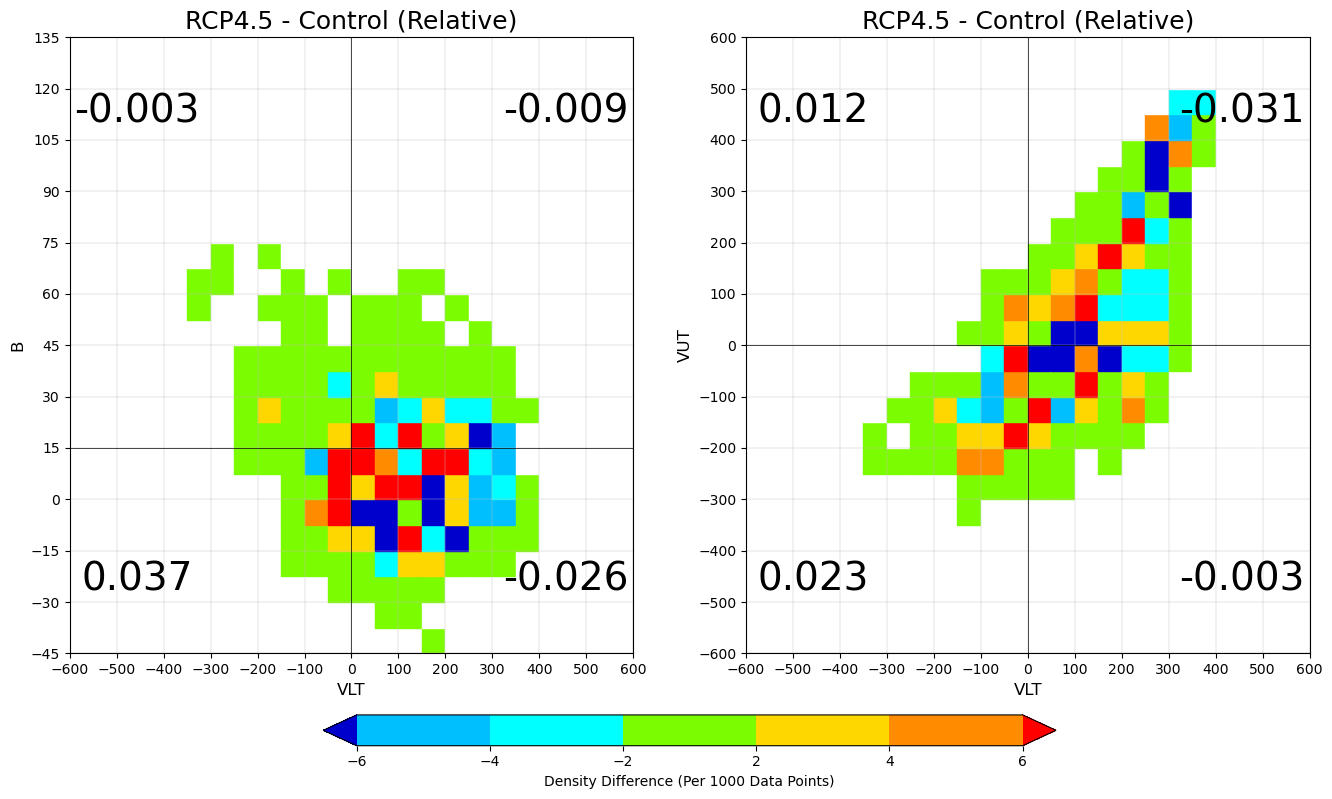

In [66]:
# Plot Relative Difference Between Phase Space Distributions of RCP4.5 - Control
Phase_Diff_Plot("RCP4.5", "Control", RCP45_VLT_B_30_35N, RCP45_VLT_VUT_30_35N, Control_VLT_B_30_35N, Control_VLT_VUT_30_35N, \
True, False, "RCP45-Control_Phase_Diff_30_35N")

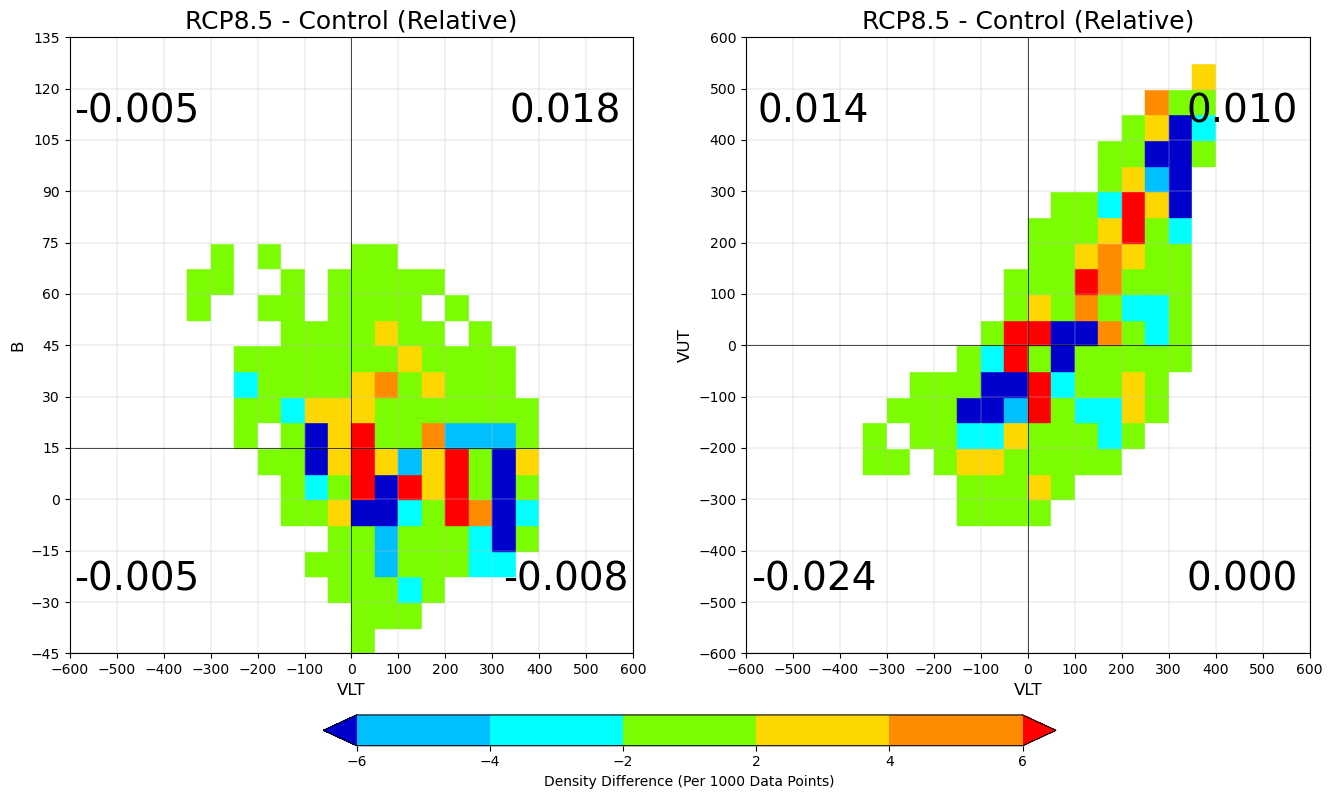

In [67]:
# Plot Relative Difference Between Phase Space Distributions of RCP8.5 - Control
Phase_Diff_Plot("RCP8.5", "Control", RCP85_VLT_B_30_35N, RCP85_VLT_VUT_30_35N, Control_VLT_B_30_35N, Control_VLT_VUT_30_35N, \
True, False, "RCP85-Control_Phase_Diff_30_35N")

In [68]:
# Create Subset of Data: 35~40N Latitude
Control_35_40N = Control_Data[(Control_Data["Lat"] >= 35) & (Control_Data["Lat"] < 40)].reset_index()
RCP45_35_40N = RCP45_Data[(RCP45_Data["Lat"] >= 35) & (RCP45_Data["Lat"] < 40)].reset_index()
RCP85_35_40N = RCP85_Data[(RCP85_Data["Lat"] >= 35) & (RCP85_Data["Lat"] < 40)].reset_index()

In [69]:
# Phase Space Distribution For Control Run (Relative)
Control_VLT_B_35_40N, Control_VLT_VUT_35_40N = Phase_Space_Distribution(Control_35_40N, VLT_Bins, B_Bins, "Control", True)
# Phase Space Distribution For RCP4.5 Run (Relative)
RCP45_VLT_B_35_40N, RCP45_VLT_VUT_35_40N = Phase_Space_Distribution(RCP45_35_40N, VLT_Bins, B_Bins, "RCP4.5", True)
# Phase Space Distribution For RCP8.5 Run (Relative)
RCP85_VLT_B_35_40N, RCP85_VLT_VUT_35_40N = Phase_Space_Distribution(RCP85_35_40N, VLT_Bins, B_Bins, "RCP8.5", True)

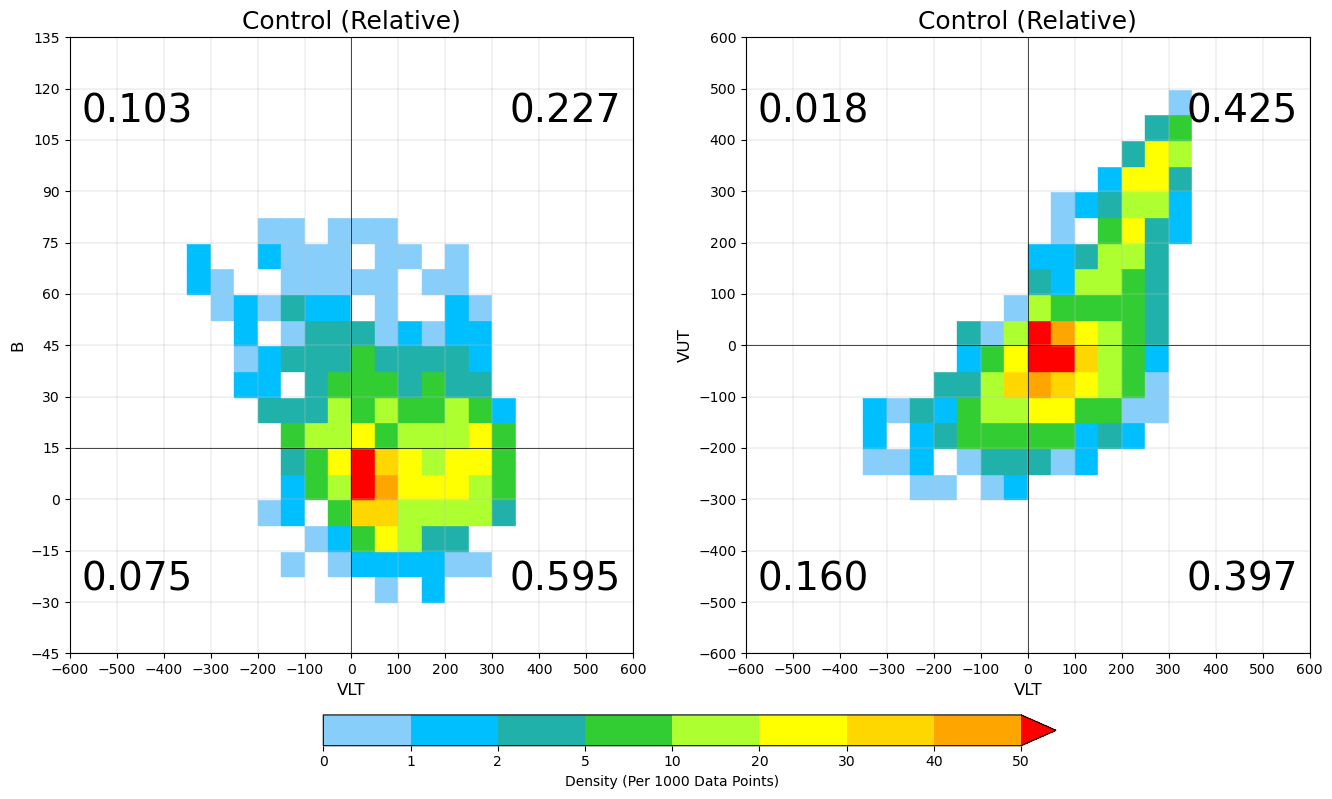

In [70]:
# Plot Relative Phase Space Distribution For Control Run
Fig = Phase_Distr_Plot(Control_VLT_B_35_40N, Control_VLT_VUT_35_40N, "Control", True, False, \
"Control_Phase_Distr_35_40N")

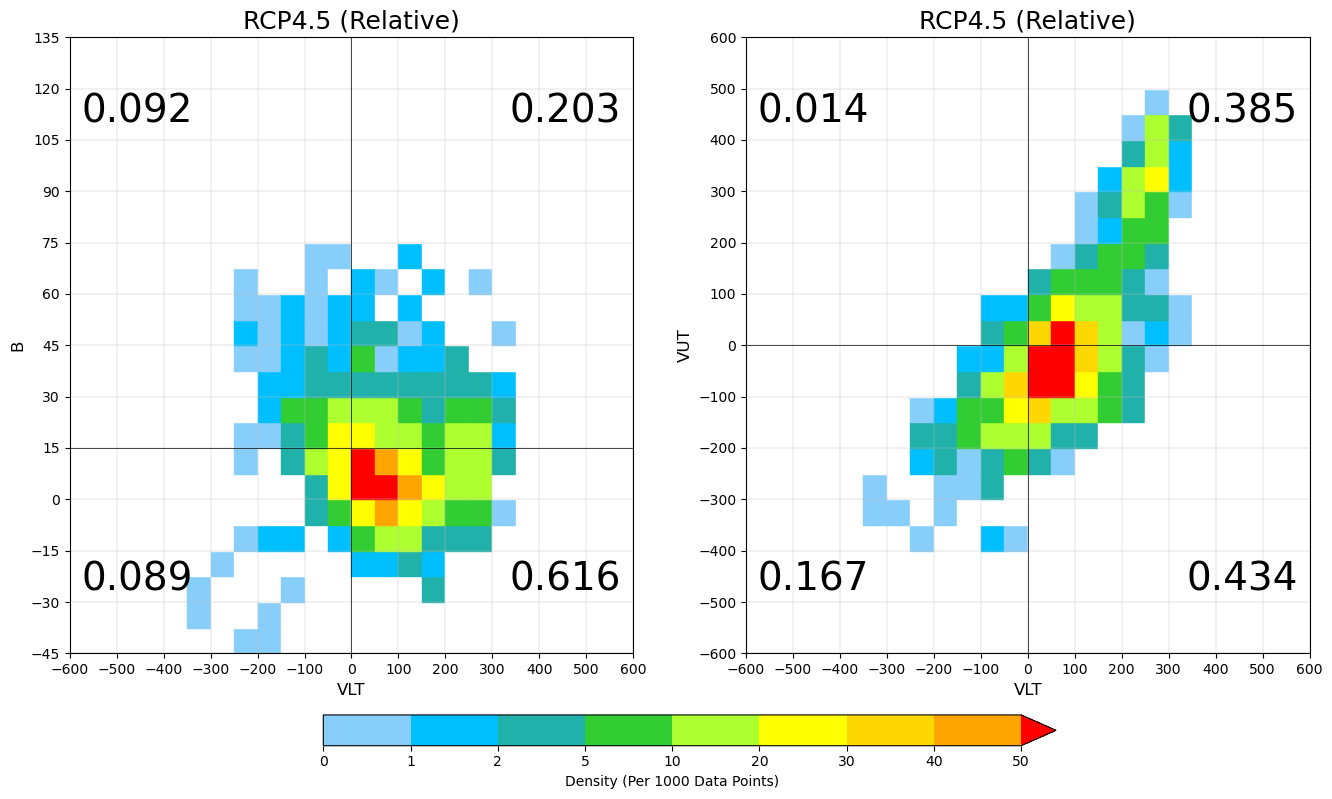

In [71]:
# Plot Relative Phase Space Distribution For RCP4.5 Run
Fig = Phase_Distr_Plot(RCP45_VLT_B_35_40N, RCP45_VLT_VUT_35_40N, "RCP4.5", True, False, "")

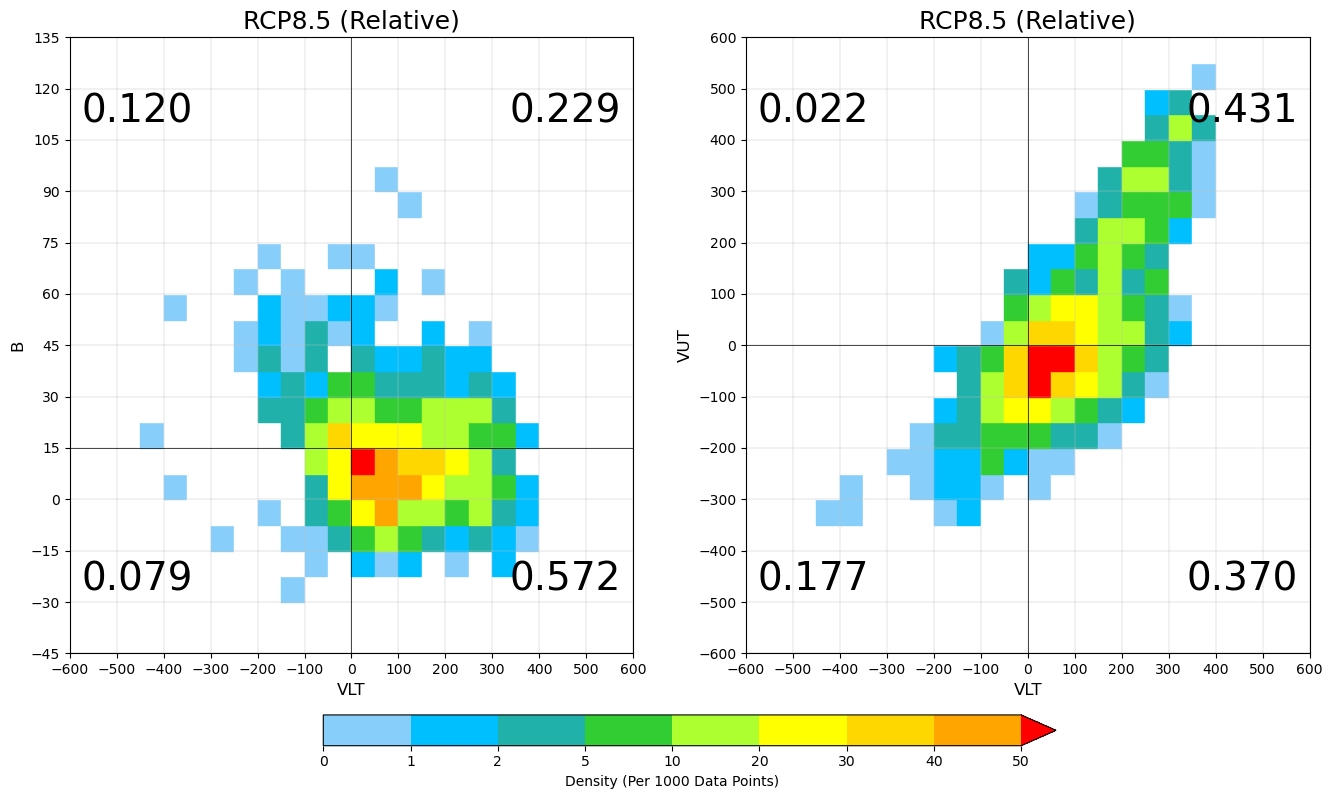

In [72]:
# Plot Relative Phase Space Distribution For RCP8.5 Run
Fig = Phase_Distr_Plot(RCP85_VLT_B_35_40N, RCP85_VLT_VUT_35_40N, "RCP8.5", True, False, "")

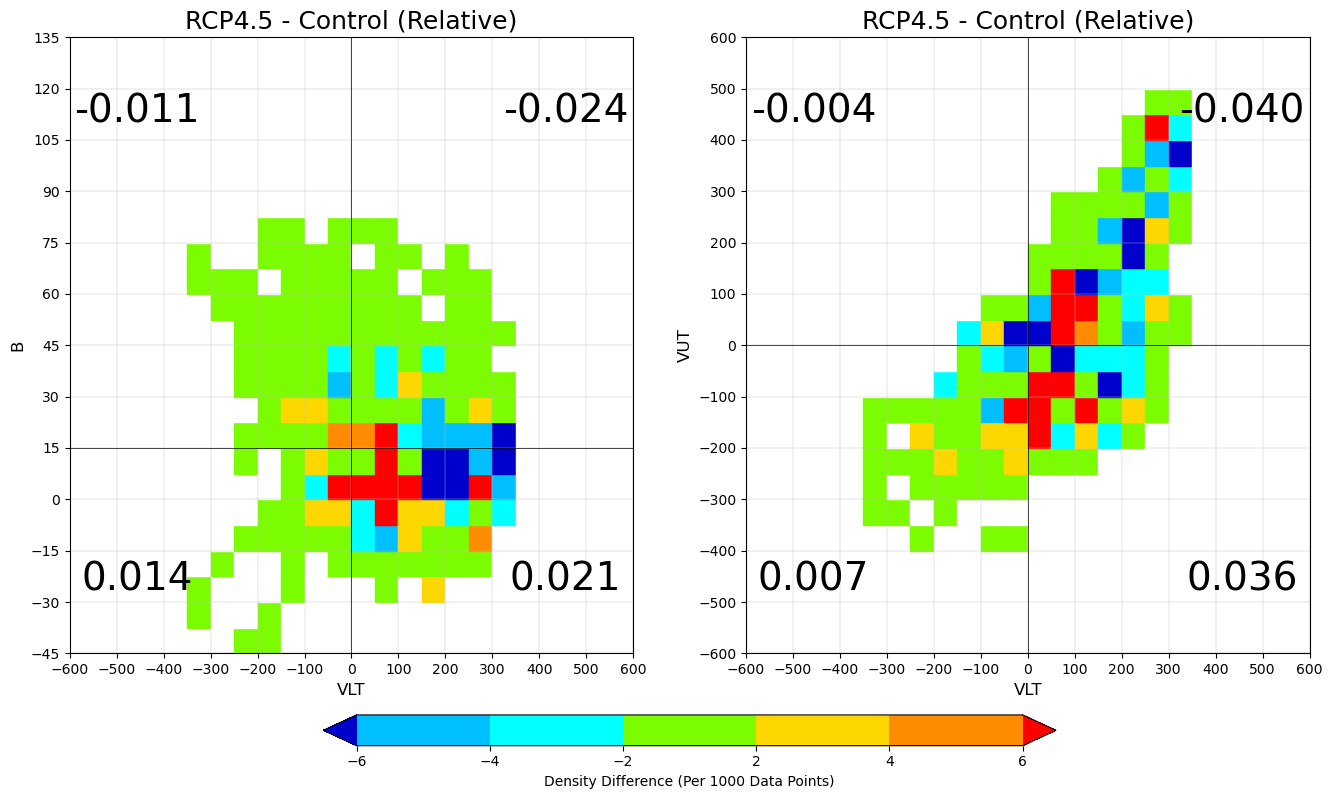

In [73]:
# Plot Relative Difference Between Phase Space Distributions of RCP4.5 - Control
Phase_Diff_Plot("RCP4.5", "Control", RCP45_VLT_B_35_40N, RCP45_VLT_VUT_35_40N, Control_VLT_B_35_40N, Control_VLT_VUT_35_40N, \
True, False, "RCP45-Control_Phase_Diff_35_40N")

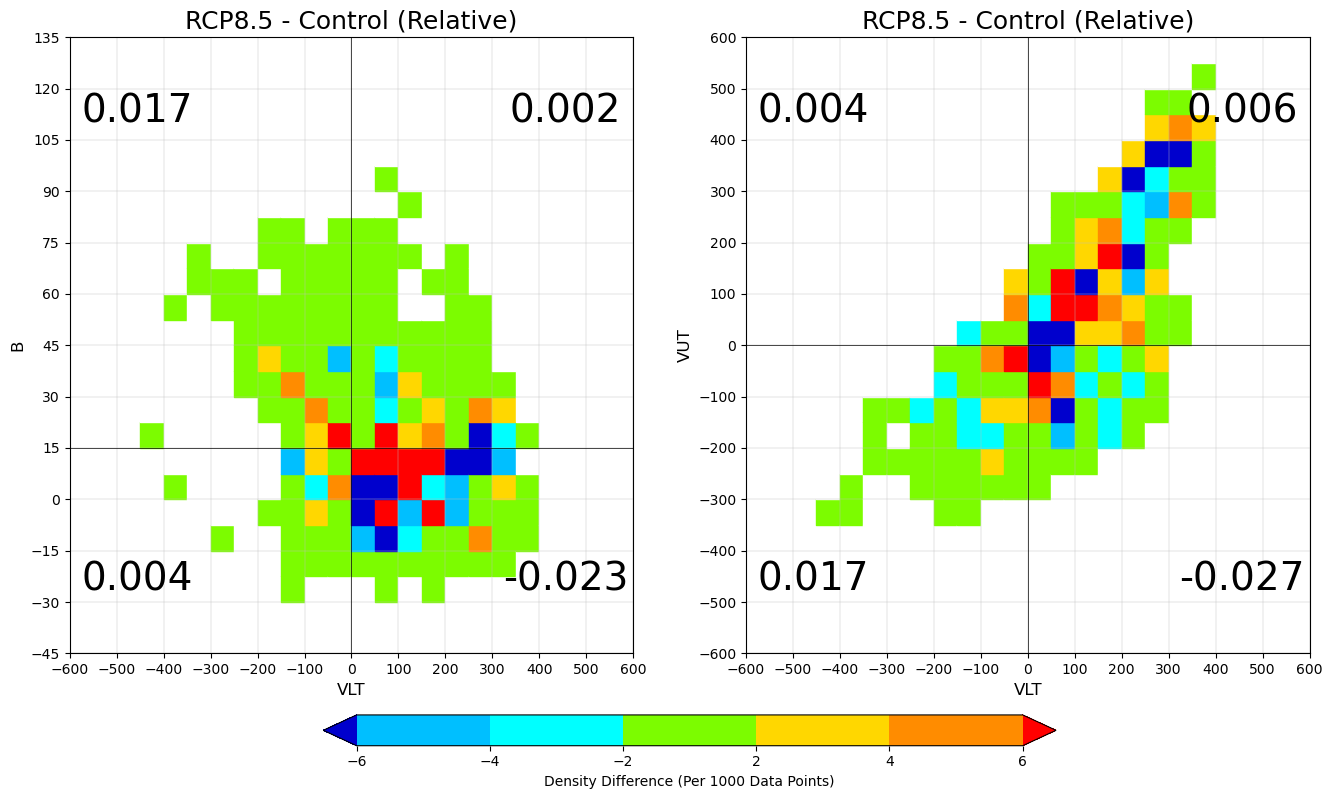

In [74]:
# Plot Relative Difference Between Phase Space Distributions of RCP8.5 - Control
Phase_Diff_Plot("RCP8.5", "Control", RCP85_VLT_B_35_40N, RCP85_VLT_VUT_35_40N, Control_VLT_B_35_40N, Control_VLT_VUT_35_40N, \
True, False, "RCP85-Control_Phase_Diff_35_40N")

In [75]:
# Create Subset of Data: 40~45N Latitude
Control_40_45N = Control_Data[(Control_Data["Lat"] >= 40) & (Control_Data["Lat"] < 45)].reset_index()
RCP45_40_45N = RCP45_Data[(RCP45_Data["Lat"] >= 40) & (RCP45_Data["Lat"] < 45)].reset_index()
RCP85_40_45N = RCP85_Data[(RCP85_Data["Lat"] >= 40) & (RCP85_Data["Lat"] < 45)].reset_index()

In [76]:
# Phase Space Distribution For Control Run (Relative)
Control_VLT_B_40_45N, Control_VLT_VUT_40_45N = Phase_Space_Distribution(Control_40_45N, VLT_Bins, B_Bins, "Control", True)
# Phase Space Distribution For RCP4.5 Run (Relative)
RCP45_VLT_B_40_45N, RCP45_VLT_VUT_40_45N = Phase_Space_Distribution(RCP45_40_45N, VLT_Bins, B_Bins, "RCP4.5", True)
# Phase Space Distribution For RCP8.5 Run (Relative)
RCP85_VLT_B_40_45N, RCP85_VLT_VUT_40_45N = Phase_Space_Distribution(RCP85_40_45N, VLT_Bins, B_Bins, "RCP8.5", True)

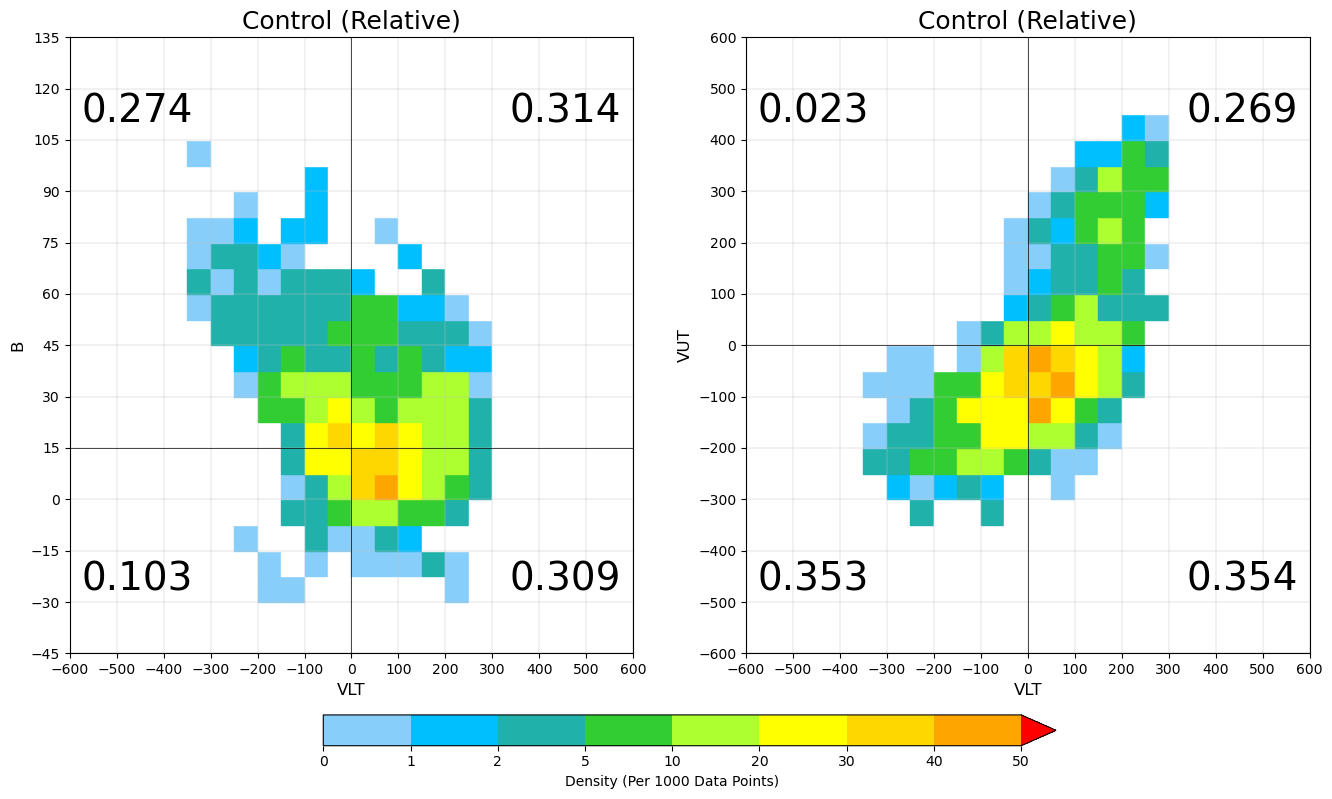

In [77]:
# Plot Relative Phase Space Distribution For Control Run
Fig = Phase_Distr_Plot(Control_VLT_B_40_45N, Control_VLT_VUT_40_45N, "Control", True, False, \
"Control_Phase_Distr_40_45N")

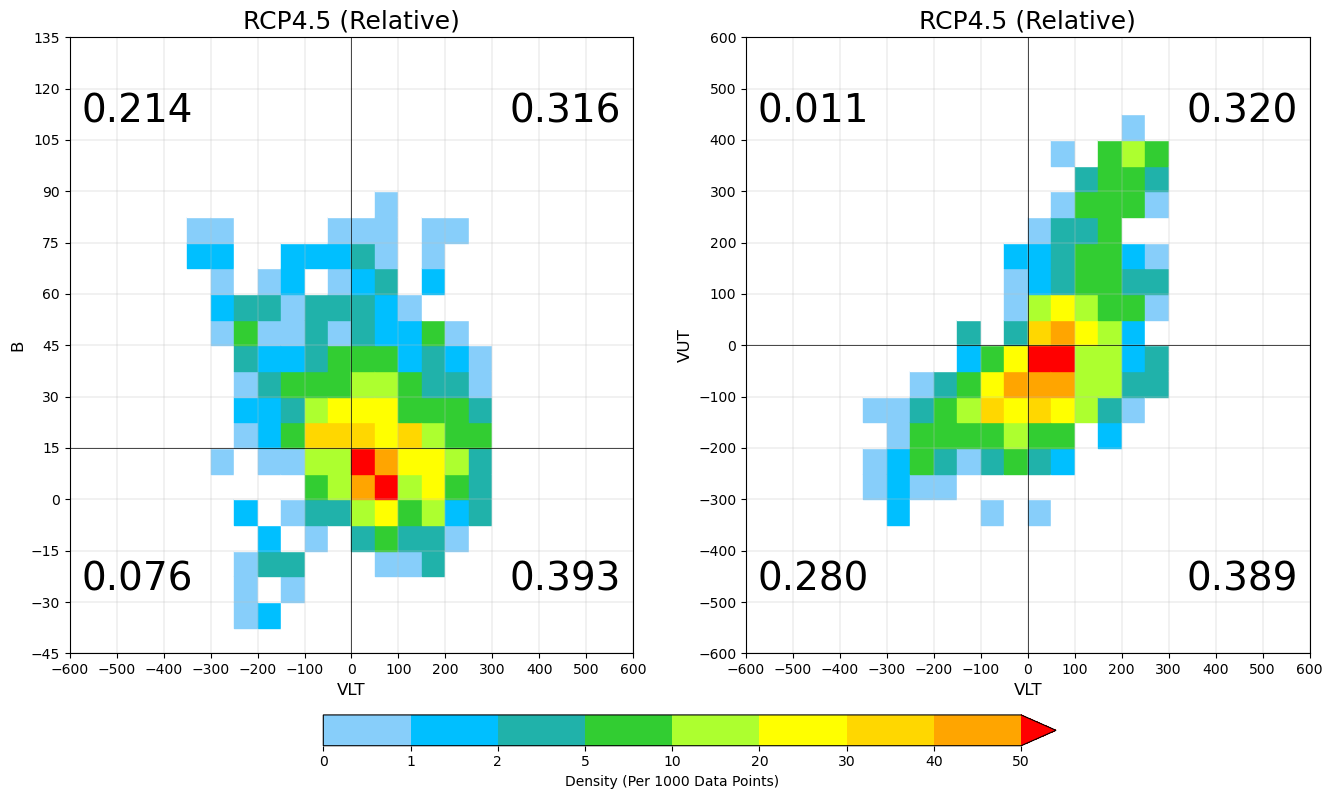

In [78]:
# Plot Relative Phase Space Distribution For RCP4.5 Run
Fig = Phase_Distr_Plot(RCP45_VLT_B_40_45N, RCP45_VLT_VUT_40_45N, "RCP4.5", True, False, "")

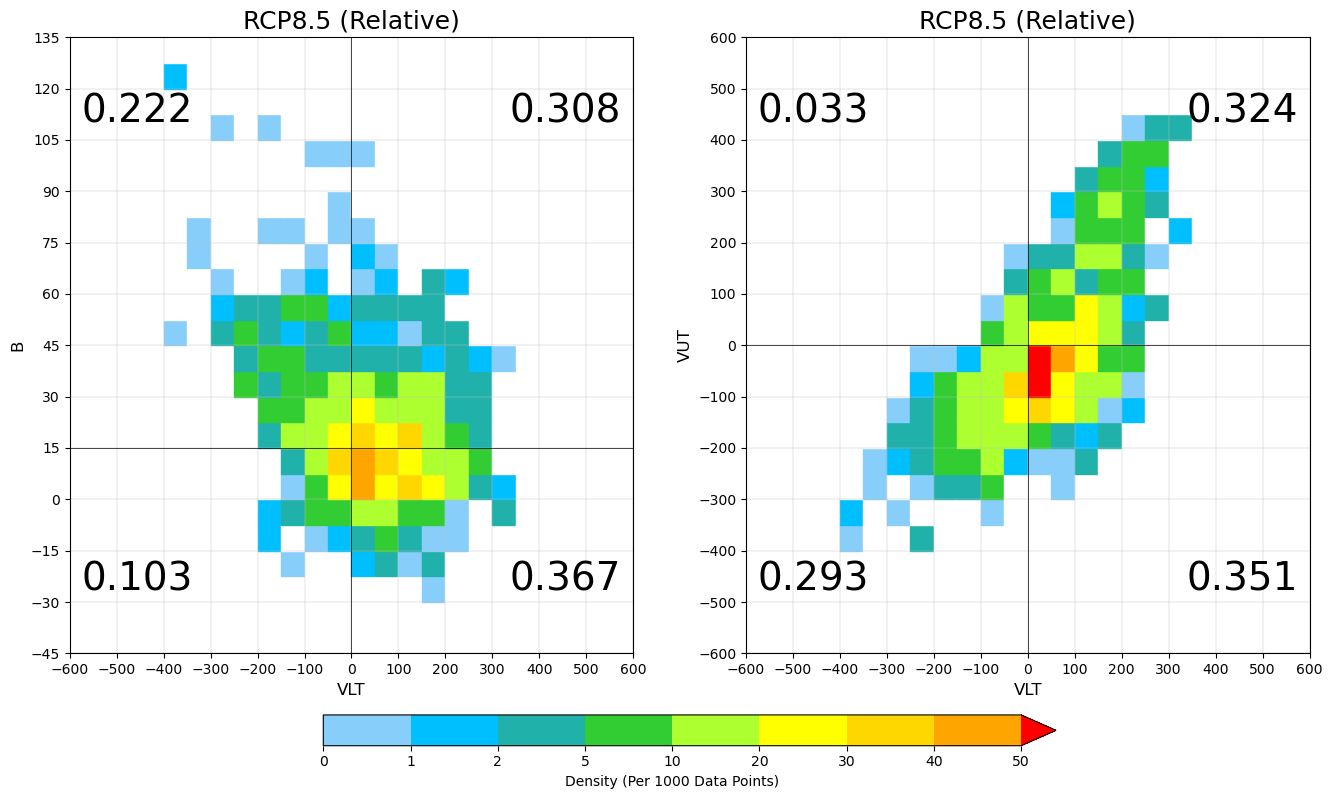

In [79]:
# Plot Relative Phase Space Distribution For RCP8.5 Run
Fig = Phase_Distr_Plot(RCP85_VLT_B_40_45N, RCP85_VLT_VUT_40_45N, "RCP8.5", True, False, "")

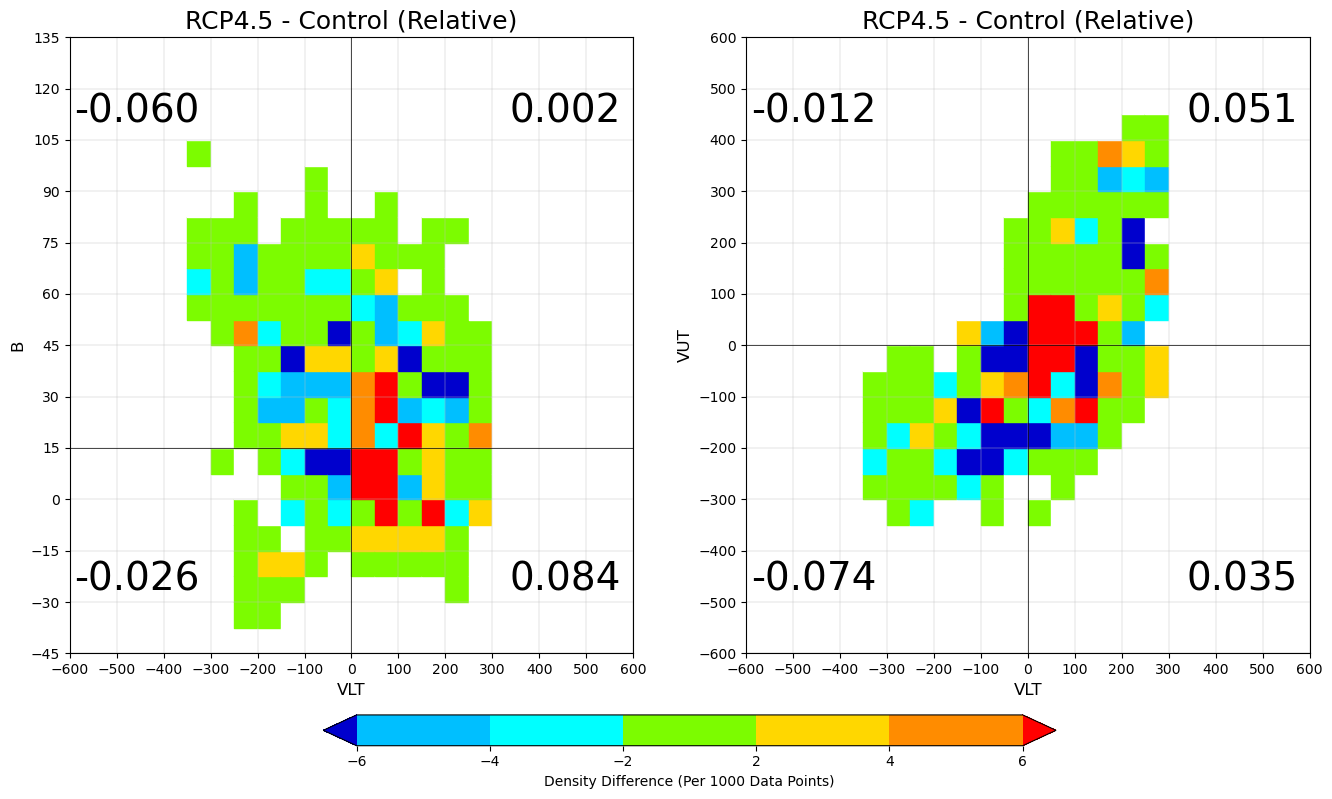

In [80]:
# Plot Relative Difference Between Phase Space Distributions of RCP4.5 - Control
Phase_Diff_Plot("RCP4.5", "Control", RCP45_VLT_B_40_45N, RCP45_VLT_VUT_40_45N, Control_VLT_B_40_45N, Control_VLT_VUT_40_45N, \
True, False, "RCP45-Control_Phase_Diff_40_45N")

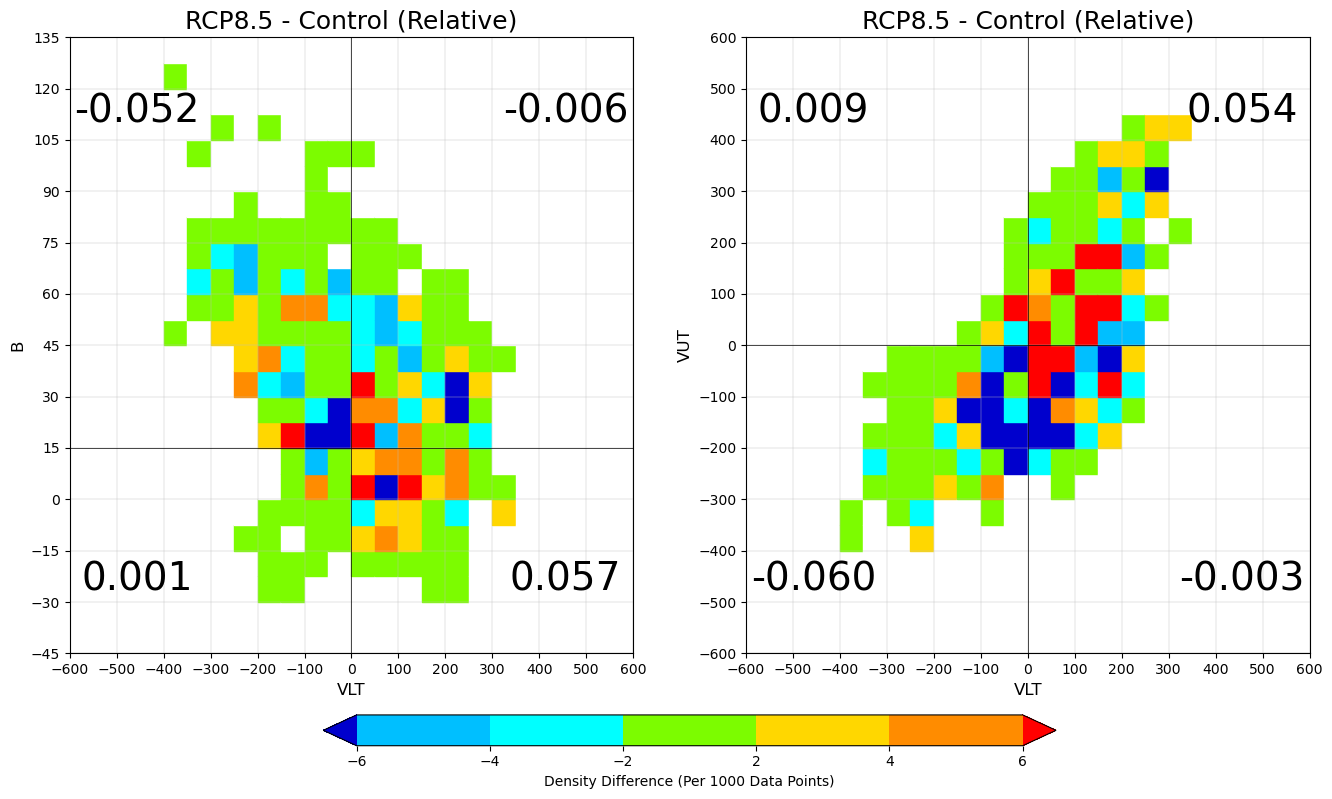

In [81]:
# Plot Relative Difference Between Phase Space Distributions of RCP8.5 - Control
Phase_Diff_Plot("RCP8.5", "Control", RCP85_VLT_B_40_45N, RCP85_VLT_VUT_40_45N, Control_VLT_B_40_45N, Control_VLT_VUT_40_45N, \
True, False, "RCP85-Control_Phase_Diff_40_45N")

In [82]:
# Create Subset of Data: Above 45N Latitude
Control_45N_Above = Control_Data[(Control_Data["Lat"] >= 45)].reset_index()
RCP45_45N_Above = RCP45_Data[(RCP45_Data["Lat"] >= 45)].reset_index()
RCP85_45N_Above = RCP85_Data[(RCP85_Data["Lat"] >= 45)].reset_index()

In [83]:
# Phase Space Distribution For Control Run (Relative)
Control_VLT_B_45N_Above, Control_VLT_VUT_45N_Above = Phase_Space_Distribution(Control_45N_Above, VLT_Bins, B_Bins, "Control", True)
# Phase Space Distribution For RCP4.5 Run (Relative)
RCP45_VLT_B_45N_Above, RCP45_VLT_VUT_45N_Above = Phase_Space_Distribution(RCP45_45N_Above, VLT_Bins, B_Bins, "RCP4.5", True)
# Phase Space Distribution For RCP8.5 Run (Relative)
RCP85_VLT_B_45N_Above, RCP85_VLT_VUT_45N_Above = Phase_Space_Distribution(RCP85_45N_Above, VLT_Bins, B_Bins, "RCP8.5", True)

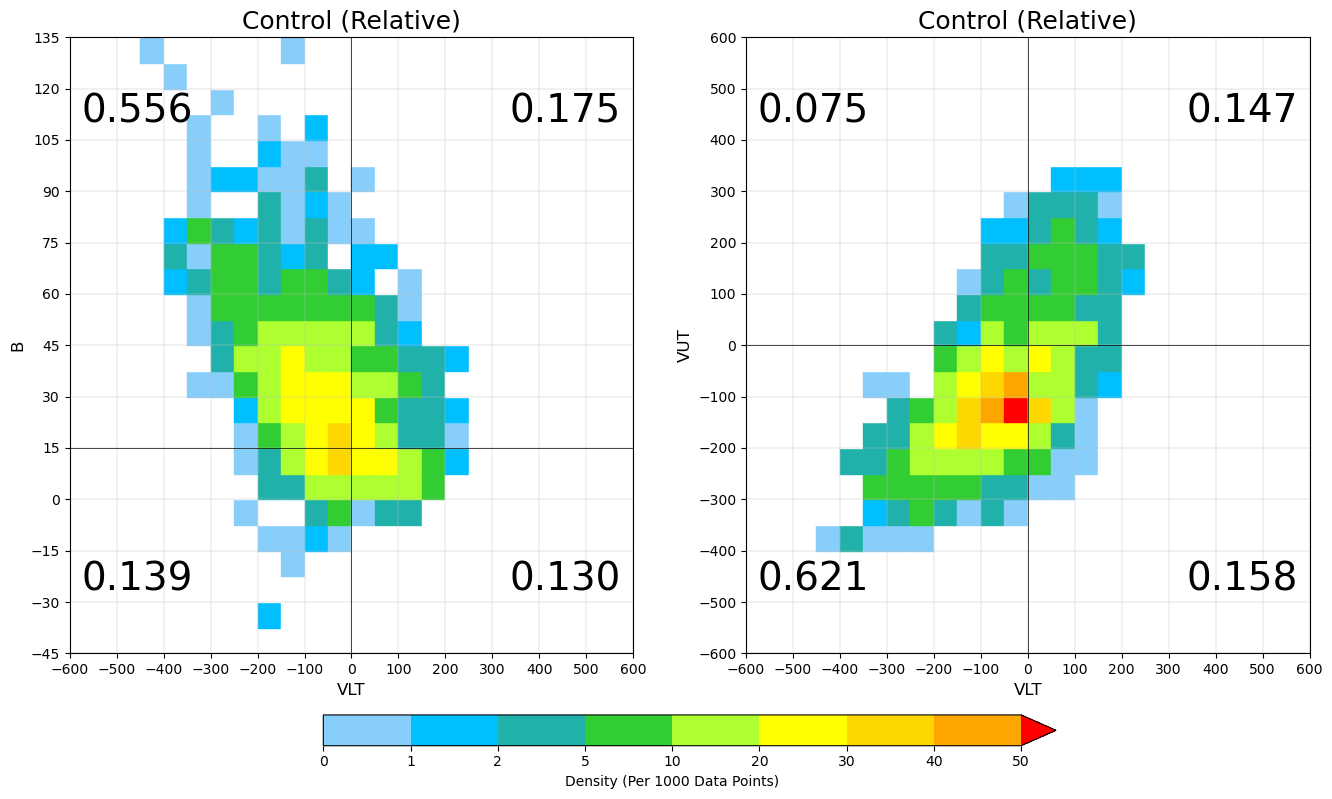

In [84]:
# Plot Relative Phase Space Distribution For Control Run
Fig = Phase_Distr_Plot(Control_VLT_B_45N_Above, Control_VLT_VUT_45N_Above, "Control", True, False, \
"Control_Phase_Distr_45N_Above")

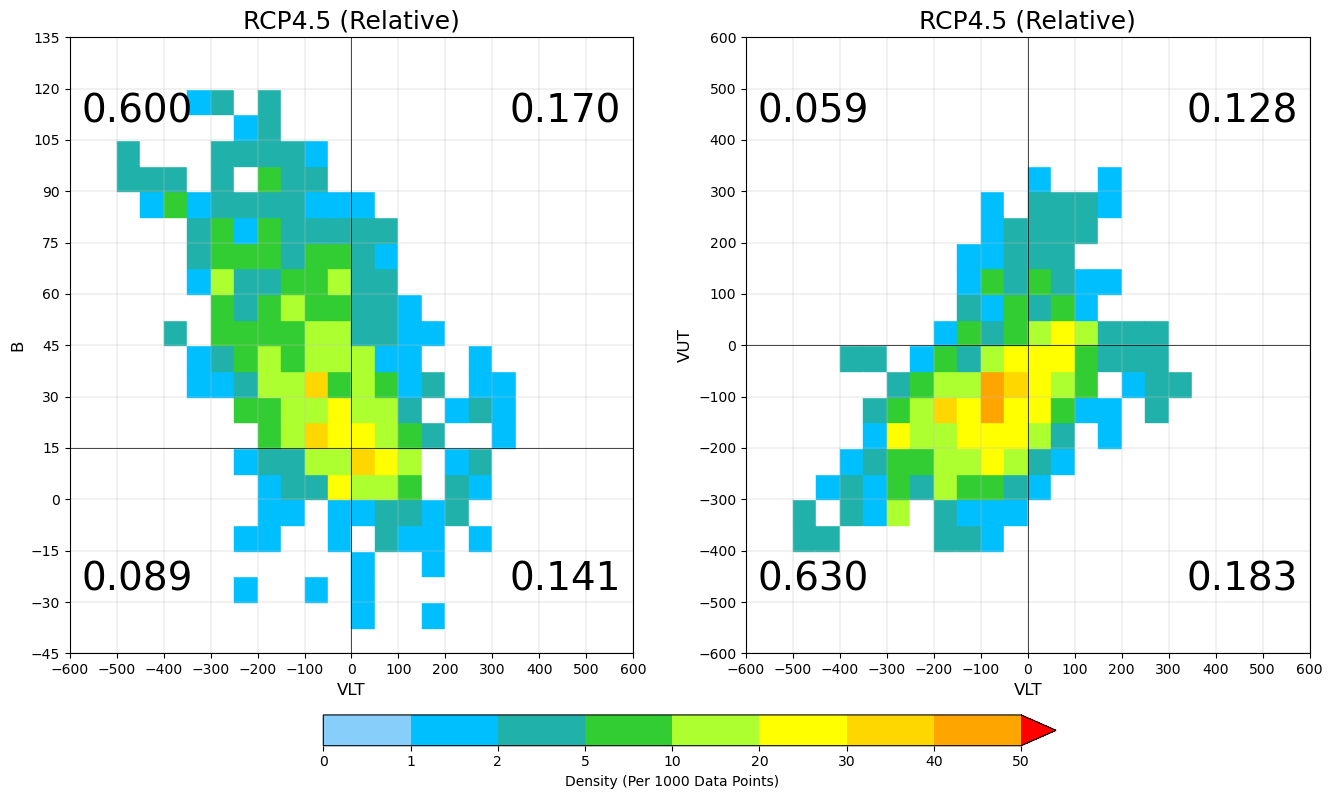

In [85]:
# Plot Relative Phase Space Distribution For RCP4.5 Run
Fig = Phase_Distr_Plot(RCP45_VLT_B_45N_Above, RCP45_VLT_VUT_45N_Above, "RCP4.5", True, False, "")

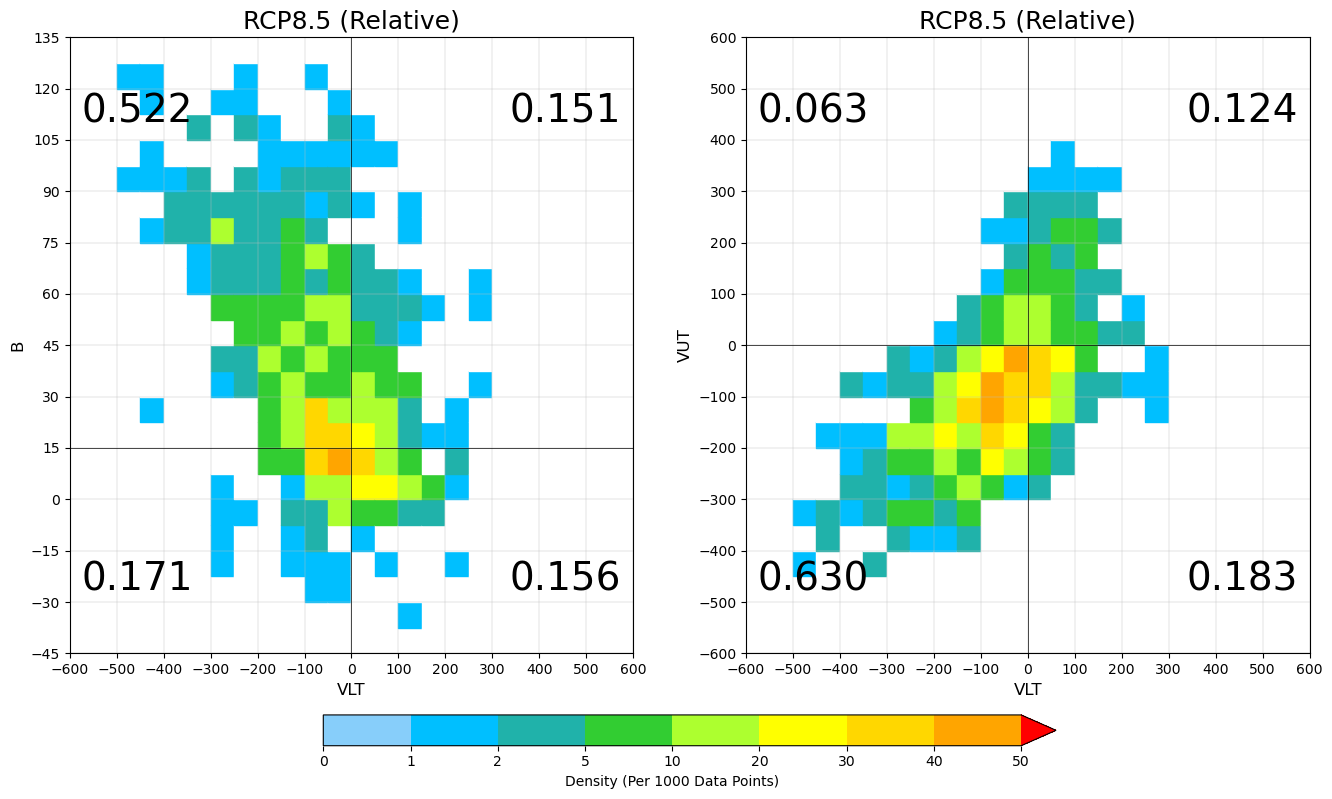

In [86]:
# Plot Relative Phase Space Distribution For RCP8.5 Run
Fig = Phase_Distr_Plot(RCP85_VLT_B_45N_Above, RCP85_VLT_VUT_45N_Above, "RCP8.5", True, False, "")

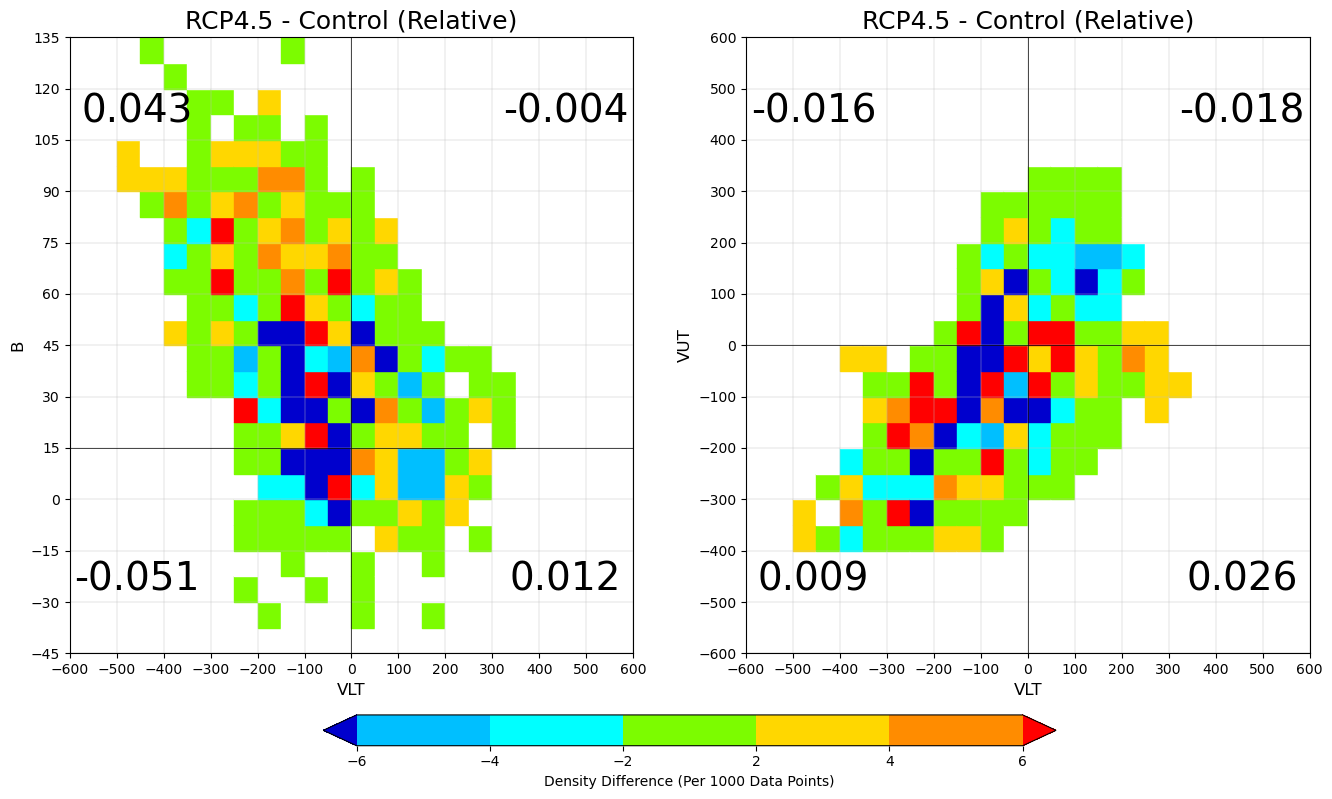

In [87]:
# Plot Relative Difference Between Phase Space Distributions of RCP4.5 - Control
Phase_Diff_Plot("RCP4.5", "Control", RCP45_VLT_B_45N_Above, RCP45_VLT_VUT_45N_Above, Control_VLT_B_45N_Above, Control_VLT_VUT_45N_Above, \
True, False, "RCP45-Control_Phase_Diff_45N_Above")

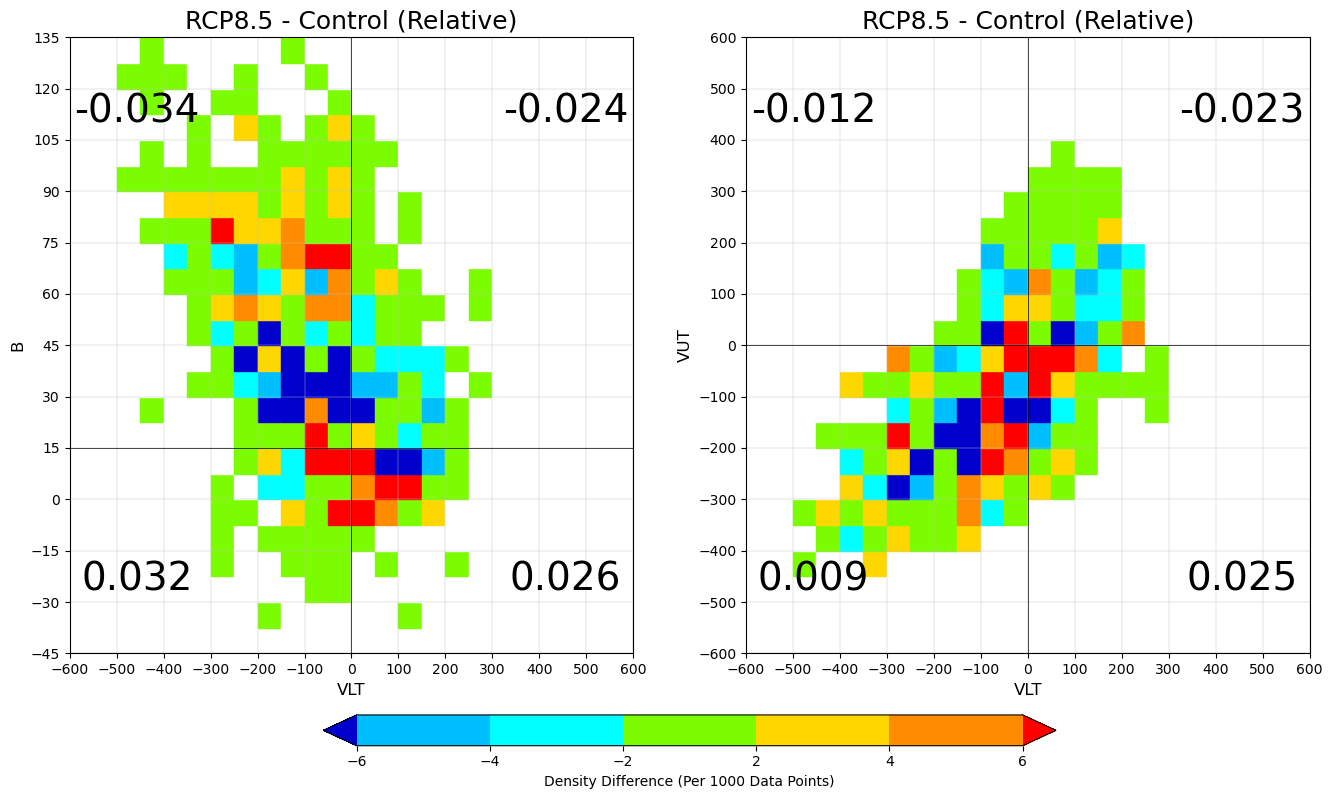

In [88]:
# Plot Relative Difference Between Phase Space Distributions of RCP8.5 - Control
Phase_Diff_Plot("RCP8.5", "Control", RCP85_VLT_B_45N_Above, RCP85_VLT_VUT_45N_Above, Control_VLT_B_45N_Above, Control_VLT_VUT_45N_Above, \
True, False, "RCP85-Control_Phase_Diff_45N_Above")

In [89]:
# Create Subset of Data: October to December
Control_Oct_Dec = Control_Data[(Control_Data["Month"] >= 10)].reset_index()
RCP45_Oct_Dec = RCP45_Data[(RCP45_Data["Month"] >= 10)].reset_index()
RCP85_Oct_Dec = RCP85_Data[(RCP85_Data["Month"] >= 10)].reset_index()

In [90]:
# Phase Space Distribution For Control Run (Relative)
Control_VLT_B_Rela_Oct_Dec, Control_VLT_VUT_Rela_Oct_Dec = Phase_Space_Distribution(Control_Oct_Dec, VLT_Bins, B_Bins, "Control", True)
# Phase Space Distribution For RCP4.5 Run (Relative)
RCP45_VLT_B_Rela_Oct_Dec, RCP45_VLT_VUT_Rela_Oct_Dec = Phase_Space_Distribution(RCP45_Oct_Dec, VLT_Bins, B_Bins, "RCP4.5", True)
# Phase Space Distribution For RCP8.5 Run (Relative)
RCP85_VLT_B_Rela_Oct_Dec, RCP85_VLT_VUT_Rela_Oct_Dec = Phase_Space_Distribution(RCP85_Oct_Dec, VLT_Bins, B_Bins, "RCP8.5", True)

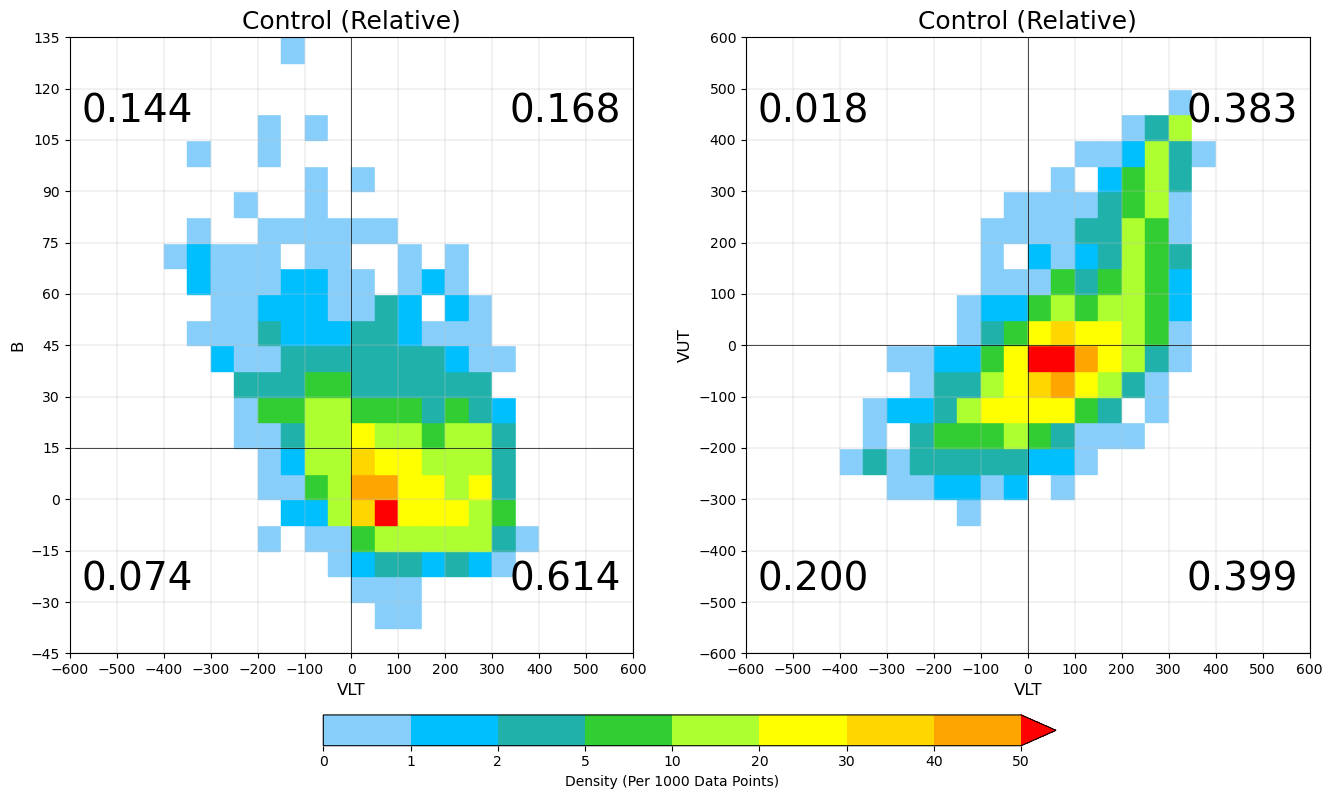

In [91]:
# Plot Relative Phase Space Distribution For Control Run
Fig = Phase_Distr_Plot(Control_VLT_B_Rela_Oct_Dec, Control_VLT_VUT_Rela_Oct_Dec, "Control", True, False, \
"Control_Phase_Distr_Oct_Dec")

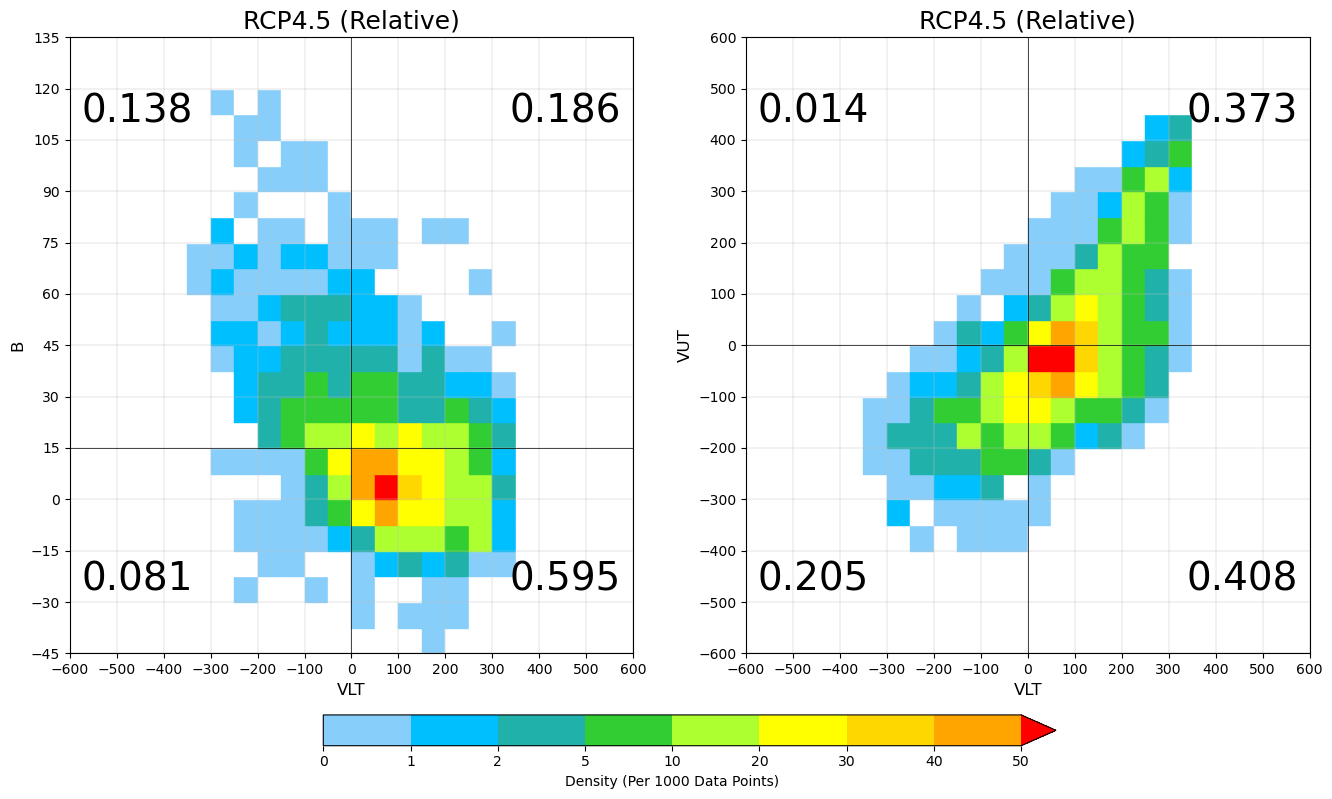

In [92]:
# Plot Relative Phase Space Distribution For RCP4.5 Run
Fig = Phase_Distr_Plot(RCP45_VLT_B_Rela_Oct_Dec, RCP45_VLT_VUT_Rela_Oct_Dec, "RCP4.5", True, False, "")

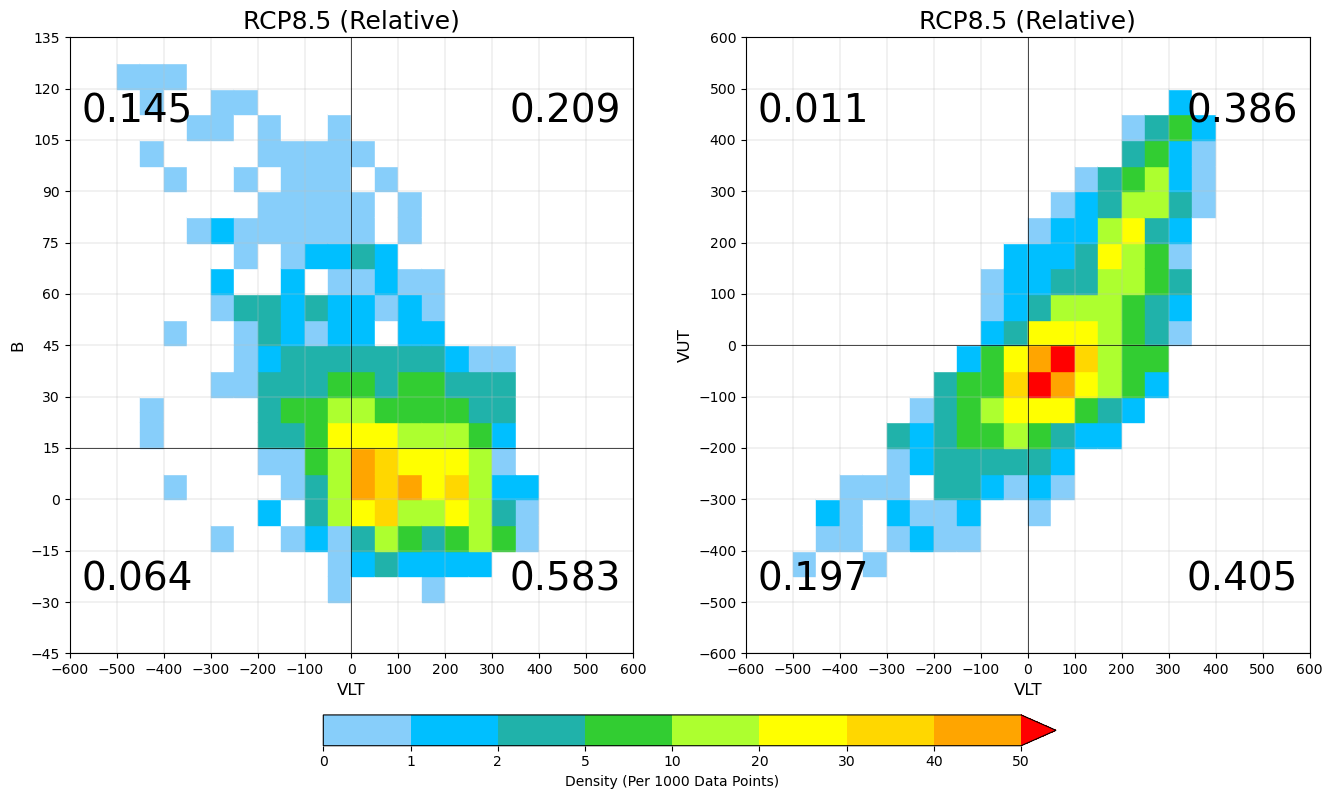

In [93]:
# Plot Relative Phase Space Distribution For RCP8.5 Run
Fig = Phase_Distr_Plot(RCP85_VLT_B_Rela_Oct_Dec, RCP85_VLT_VUT_Rela_Oct_Dec, "RCP8.5", True, False, "")

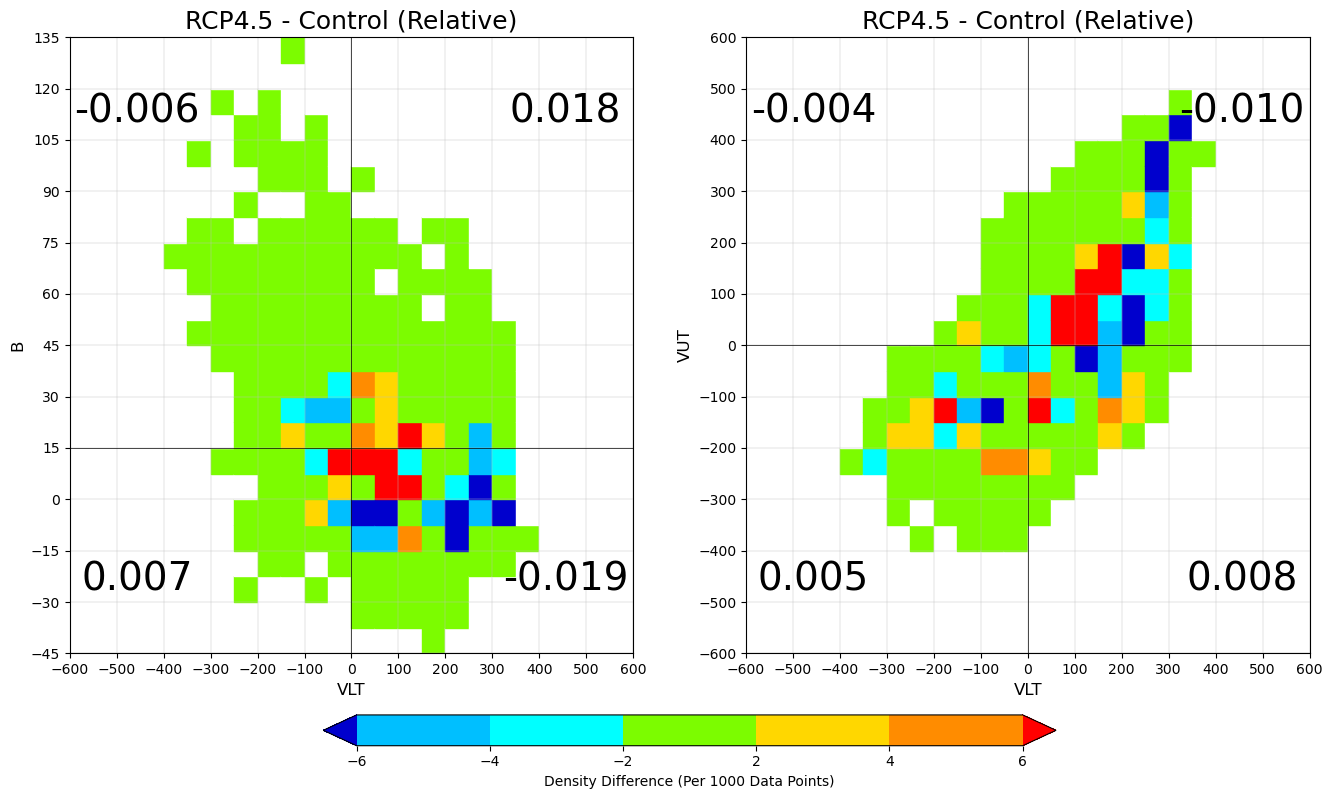

In [94]:
# Plot Relative Difference Between Phase Space Distributions of RCP4.5 - Control
Phase_Diff_Plot("RCP4.5", "Control", RCP45_VLT_B_Rela_Oct_Dec, RCP45_VLT_VUT_Rela_Oct_Dec, Control_VLT_B_Rela_Oct_Dec, Control_VLT_VUT_Rela_Oct_Dec, \
True, False, "RCP45-Control_Phase_Diff_Oct_Dec")

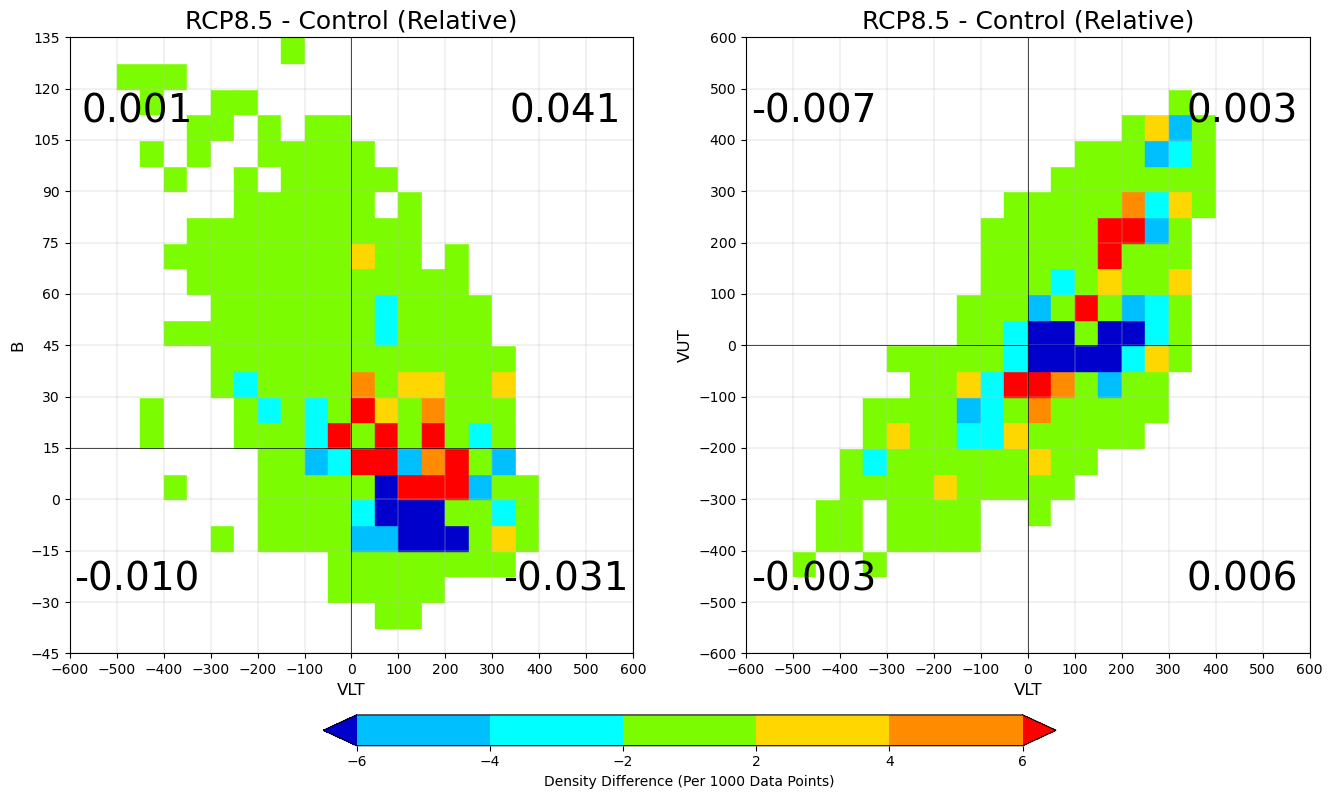

In [95]:
# Plot Relative Difference Between Phase Space Distributions of RCP8.5 - Control
Phase_Diff_Plot("RCP8.5", "Control", RCP85_VLT_B_Rela_Oct_Dec, RCP85_VLT_VUT_Rela_Oct_Dec, Control_VLT_B_Rela_Oct_Dec, Control_VLT_VUT_Rela_Oct_Dec, \
True, False, "RCP85-Control_Phase_Diff_Oct_Dec")